# Capstone 1 Data Wrangling
## Predict Prediabetes from NHANES  2007 - 2016 data
## <https://www.cdc.gov/nchs/nhanes/index.htm>

In [948]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [949]:
def read_nhanes_data(type_dict, basename, sort_opt):
    """
    Read all nhanes data files for a category. Concatenate them all together and return resultant dataframe. 
       
    Parameters:
        type_dict: dictionary
            dictionary used for dtype= in pd.read_csv
        basename: string
            base filename for NHANES data category
        sort_opt: boolean
            option used for sort= in pd.concat
        
    Returns:
        df: dataframe
            dataframe built from NHANES datafiles. 
    """
    
    df_file_list = glob.iglob('nhanes*/' + basename + '*.csv')
    try:
        df = pd.concat((pd.read_csv(f, dtype=type_dict) for f in df_file_list), ignore_index=True, sort=sort_opt)
    except FileNotFoundError:
        df = pd.DataFrame()
                              
    return(df)
    

In [950]:
def move_columns(cols_to_move, df):
    """
    Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
    as not all years (files) have same columns or columns in same order. 
    
    Parameters: 
        cols_to_move: list
            columns to move to front of dataframe
        df: dataframe
            dataframe containing columns to move.
    Returns:
        df: dataframe
            dataframe with reordered column list.
    """

    if df.columns.any():
        cols = cols_to_move + [col for col in df if col not in cols_to_move]
        df = df[cols]
    else:
        df = pd.DataFrame()
    return(df)

In [951]:
# Determine which columns have been added or dropped during 10 year period. 

def changed_columns(basename):
    """
    Return list of columns that do not span all 10 years of interest. If a file is missing, 
    do not report difference for that interval.
    
    Parameters:
        basename: string
            Base of NHANES filename pattern.
            
    Returns:
        list: list
            list of all columns dropped or added between NHANES files. Columns appear in list only once. 
       """
    
    # Get list of columns from each file. 
    try:
        n7_columns = pd.read_csv('nhanes 2007-2008/' + basename + 'E.csv', nrows=0).columns.tolist()
    except FileNotFoundError:
        n7_columns = []
    try:
        n9_columns = pd.read_csv('nhanes 2009-2010/' + basename + 'F.csv', nrows=0).columns.tolist()
    except FileNotFoundError:
        n9_columns = []
    try:
        n11_columns = pd.read_csv('nhanes 2011-2012/' + basename + 'G.csv', nrows=0).columns.tolist()
    except FileNotFoundError:
        n11_columns = []
    try:
        n13_columns = pd.read_csv('nhanes 2013-2014/' + basename + 'H.csv', nrows=0).columns.tolist()
    except FileNotFoundError:
        n13_columns = []
    try:
        n15_columns = pd.read_csv('nhanes 2015-2016/' + basename + 'I.csv', nrows=0).columns.tolist()
    except FileNotFoundError:
        n15_columns = []
    
    # Get differences between two adjadcent survey files by taking union of set of column names minus
    #    intersection of set of column names. This will yield the columns that were added or dropped 
    #    between the two survey cycles. 
    if n7_columns and n9_columns:
        diff_7_9 = (set(n7_columns) | set(n9_columns)) - (set(n7_columns) & set(n9_columns))
    else:
        diff_7_9 = []
    if n9_columns and n11_columns:
        diff_9_11 = (set(n9_columns) | set(n11_columns)) - (set(n9_columns) & set(n11_columns))
    else:
        diff_9_11 = []
    if n11_columns and n13_columns:
        diff_11_13 = (set(n11_columns) | set(n13_columns)) - (set(n11_columns) & set(n13_columns))
    else:
        diff_11_13 = []
    if n13_columns and n15_columns:
        diff_13_15 = (set(n13_columns) | set(n15_columns)) - (set(n13_columns) & set(n15_columns))
    else:
        diff_13_15 = []
    
    # Create union of all four sets of column differences to eliminate duplicates, convert to list, return list. 
    return(list(set(diff_7_9) | set(diff_9_11) | set(diff_11_13) | set(diff_13_15)))

## Look at demographics files, then read them in and concatenate them into one datafile.

In [952]:
demo = pd.read_csv('nhanes 2007-2008/DEMO_E.csv')
demo.head()

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,DMQMILIT,...,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANG,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA
0,41475.0,5.0,2.0,2.0,2.0,62.0,751.0,752.0,5.0,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,59356.356426,60045.772497,1.0,60.0
1,41476.0,5.0,2.0,1.0,2.0,6.0,81.0,82.0,5.0,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,35057.218405,35353.210440,1.0,70.0
2,41477.0,5.0,2.0,2.0,1.0,71.0,859.0,860.0,3.0,1.0,...,2.0,2.0,1.0,2.0,2.0,1.0,9935.266183,10074.150074,1.0,67.0
3,41478.0,5.0,2.0,2.0,2.0,1.0,17.0,17.0,3.0,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,12846.712058,14560.472652,2.0,59.0
4,41479.0,5.0,2.0,1.0,1.0,52.0,629.0,630.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,8727.797555,9234.055759,1.0,70.0


In [953]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10149 entries, 0 to 10148
Data columns (total 43 columns):
SEQN        10149 non-null float64
SDDSRVYR    10149 non-null float64
RIDSTATR    10149 non-null float64
RIDEXMON    9762 non-null float64
RIAGENDR    10149 non-null float64
RIDAGEYR    10149 non-null float64
RIDAGEMN    9710 non-null float64
RIDAGEEX    9367 non-null float64
RIDRETH1    10149 non-null float64
DMQMILIT    6371 non-null float64
DMDBORN2    10149 non-null float64
DMDCITZN    10143 non-null float64
DMDYRSUS    1710 non-null float64
DMDEDUC3    2500 non-null float64
DMDEDUC2    5935 non-null float64
DMDSCHOL    2270 non-null float64
DMDMARTL    5935 non-null float64
DMDHHSIZ    10149 non-null float64
DMDFMSIZ    10149 non-null float64
INDHHIN2    10072 non-null float64
INDFMIN2    10055 non-null float64
INDFMPIR    9255 non-null float64
RIDEXPRG    1208 non-null float64
DMDHRGND    10149 non-null float64
DMDHRAGE    10149 non-null float64
DMDHRBR2    9881 non-null f

In [954]:
# Read all five years of demographics data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
demo_dtype_dict = {"SEQN": int, "SDDSRVYR": int, "RIDSTATR": int, "RIAGENDR": int, "RIDAGEYR": int, 
                   "RIDRETH1": int, "DMDBORN2": int, "DMDHHSIZ": int, "DMDFMSIZ": int, 
                   "DMDHRGND": int, "DMDHRAGE": int, "SDMVPSU": int, "SDMVSTRA": int}
demo_all = read_nhanes_data(demo_dtype_dict, "DEMO_", True)
demo_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 54 columns):
AIALANG     13222 non-null float64
AIALANGA    18033 non-null float64
DMDBORN2    20686 non-null float64
DMDBORN4    29902 non-null float64
DMDCITZN    50564 non-null float64
DMDEDUC2    29201 non-null float64
DMDEDUC3    13144 non-null float64
DMDFMSIZ    50588 non-null int32
DMDHHSIZ    50588 non-null int32
DMDHHSZA    29902 non-null float64
DMDHHSZB    29902 non-null float64
DMDHHSZE    29902 non-null float64
DMDHRAGE    50588 non-null int32
DMDHRBR2    20141 non-null float64
DMDHRBR4    28844 non-null float64
DMDHREDU    48993 non-null float64
DMDHRGND    50588 non-null int32
DMDHRMAR    49801 non-null float64
DMDHSEDU    26327 non-null float64
DMDMARTL    29201 non-null float64
DMDSCHOL    4623 non-null float64
DMDYRSUS    9909 non-null float64
DMQADFC     1621 non-null float64
DMQMILIT    13094 non-null float64
DMQMILIZ    18417 non-null float64
FIAINTRP    49837 non-null 

In [955]:
# Move unique identifier columns back to the front of the dataframe. They got moved when pd.concat sorted the 
# columns as not all files had the same columns. 
demo_all = move_columns(['SEQN', 'SDDSRVYR'], demo_all)
demo_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 54 columns):
SEQN        50588 non-null int32
SDDSRVYR    50588 non-null int32
AIALANG     13222 non-null float64
AIALANGA    18033 non-null float64
DMDBORN2    20686 non-null float64
DMDBORN4    29902 non-null float64
DMDCITZN    50564 non-null float64
DMDEDUC2    29201 non-null float64
DMDEDUC3    13144 non-null float64
DMDFMSIZ    50588 non-null int32
DMDHHSIZ    50588 non-null int32
DMDHHSZA    29902 non-null float64
DMDHHSZB    29902 non-null float64
DMDHHSZE    29902 non-null float64
DMDHRAGE    50588 non-null int32
DMDHRBR2    20141 non-null float64
DMDHRBR4    28844 non-null float64
DMDHREDU    48993 non-null float64
DMDHRGND    50588 non-null int32
DMDHRMAR    49801 non-null float64
DMDHSEDU    26327 non-null float64
DMDMARTL    29201 non-null float64
DMDSCHOL    4623 non-null float64
DMDYRSUS    9909 non-null float64
DMQADFC     1621 non-null float64
DMQMILIT    13094 non-null floa

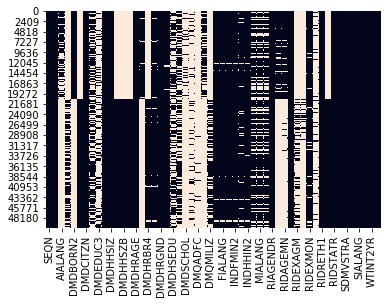

In [956]:
# Look at null data. 
sns.heatmap(demo_all.isnull(), cbar=False)

In [957]:
# Find columns not in all 10 years of data. 
drop_column_list = changed_columns("DEMO_")
drop_column_list

['DMDBORN4',
 'DMQMILIT',
 'RIDEXAGY',
 'DMDHHSZB',
 'DMDBORN2',
 'RIDEXAGM',
 'RIDAGEEX',
 'AIALANGA',
 'RIDRETH3',
 'DMDSCHOL',
 'DMQMILIZ',
 'DMDHHSZA',
 'AIALANG',
 'DMDHRBR4',
 'DMDHHSZE',
 'DMDHRBR2',
 'DMQADFC']

In [958]:
# Drop columns that are not in all 5 survey cycles as they will not be useful for analysis - way too many nulls. 
demo_all = demo_all.drop(drop_column_list, axis=1)
demo_all.shape

(50588, 37)

In [959]:
demo_all.describe()

,SEQN,SDDSRVYR,DMDCITZN,DMDEDUC2,DMDEDUC3,DMDFMSIZ,DMDHHSIZ,DMDHRAGE,DMDHREDU,DMDHRGND,...,RIDEXPRG,RIDRETH1,RIDSTATR,SDMVPSU,SDMVSTRA,SIAINTRP,SIALANG,SIAPROXY,WTINT2YR,WTMEC2YR
count,50588.000000,50588.000000,50564.000000,29201.000000,13144.000000,50588.000000,50588.000000,50588.000000,48993.000000,50588.000000,...,6418.000000,50588.000000,50588.000000,50588.00000,50588.000000,50587.000000,50587.000000,50576.000000,50588.000000,50588.000000
mean,67421.608247,6.985807,1.113223,3.375535,6.130934,3.674646,3.821262,45.790919,3.377646,1.498083,...,2.012621,2.964636,1.962877,1.53398,95.795505,1.971277,1.137150,1.635321,30310.661734,30310.661734
std,15290.298727,1.414268,0.392078,1.299630,6.088668,1.790686,1.734018,15.962644,1.315920,0.500001,...,0.333562,1.245878,0.189066,0.54342,21.757342,0.167028,0.344009,0.481345,28916.668043,29903.451307
min,41475.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,59.000000,1.000000,1.000000,1.000000,2359.373828,0.000000
25%,54121.750000,6.000000,1.000000,2.000000,2.000000,2.000000,2.000000,33.000000,2.000000,1.000000,...,2.000000,2.000000,2.000000,1.00000,78.000000,2.000000,1.000000,1.000000,12003.144539,11828.968460
50%,66768.500000,7.000000,1.000000,4.000000,5.000000,4.000000,4.000000,43.000000,4.000000,1.000000,...,2.000000,3.000000,2.000000,2.00000,95.000000,2.000000,1.000000,2.000000,19703.656463,19681.465345
75%,81055.250000,8.000000,1.000000,4.000000,9.000000,5.000000,5.000000,57.000000,4.000000,2.000000,...,2.000000,4.000000,2.000000,2.00000,114.000000,2.000000,1.000000,2.000000,34997.828687,35344.542616
max,93702.000000,9.000000,9.000000,9.000000,99.000000,7.000000,7.000000,80.000000,9.000000,2.000000,...,3.000000,5.000000,2.000000,3.00000,133.000000,2.000000,2.000000,2.000000,233755.841850,242386.660766


In [960]:
# Note - some observations have a weight of 0 for exam data (WTMEC2YR). Doc says "NOT MEC examined", so should be no Labs 
# data for these SEQN codes. Those same observations have a non-zero WTINT2YR, or interview weight. 
demo_all[demo_all.WTMEC2YR == 0.0]

,SEQN,SDDSRVYR,DMDCITZN,DMDEDUC2,DMDEDUC3,DMDFMSIZ,DMDHHSIZ,DMDHRAGE,DMDHREDU,DMDHRGND,...,RIDEXPRG,RIDRETH1,RIDSTATR,SDMVPSU,SDMVSTRA,SIAINTRP,SIALANG,SIAPROXY,WTINT2YR,WTMEC2YR
54,41529,5,1.0,5.0,NaN,4,4,24,5.0,1,...,NaN,1,1,1,66,2.0,1.0,2.0,35166.824845,0.0
63,41538,5,1.0,4.0,NaN,1,2,23,5.0,1,...,NaN,4,1,2,68,2.0,1.0,2.0,24342.505253,0.0
68,41543,5,1.0,NaN,NaN,4,4,30,2.0,1,...,NaN,4,1,2,68,2.0,1.0,1.0,7551.758131,0.0
69,41544,5,1.0,5.0,NaN,3,3,56,5.0,1,...,3.0,3,1,1,61,2.0,1.0,2.0,93728.657611,0.0
82,41557,5,1.0,1.0,NaN,1,1,80,1.0,2,...,NaN,3,1,2,63,2.0,1.0,2.0,24668.876466,0.0
94,41569,5,1.0,2.0,NaN,2,2,54,2.0,1,...,NaN,4,1,2,64,2.0,1.0,2.0,20422.845370,0.0
111,41586,5,1.0,NaN,2.0,4,4,37,3.0,1,...,NaN,1,1,1,70,2.0,2.0,1.0,7088.753022,0.0
131,41606,5,1.0,NaN,1.0,3,3,51,4.0,1,...,NaN,3,1,2,63,2.0,1.0,1.0,53713.890496,0.0
156,41631,5,1.0,NaN,NaN,5,5,24,3.0,1,...,NaN,3,1,1,59,2.0,1.0,1.0,9488.203732,0.0
198,41673,5,1.0,NaN,NaN,3,3,41,5.0,2,...,NaN,5,1,1,72,2.0,1.0,1.0,47885.301775,0.0


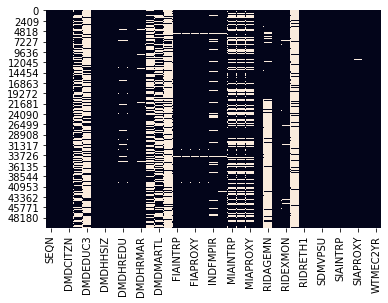

In [961]:
# Recheck missing data. 
sns.heatmap(demo_all.isnull(), cbar=False)

In [962]:
# Doesn't look like any rows are all null except SEQN. Check. 
demo_all[demo_all.isnull().sum(axis=1) >= 36]['SEQN'].count()

0

In [963]:
# Check observation counts per survey cycle. 
demo_all.SDDSRVYR.value_counts()

6    10537
8    10175
5    10149
9     9971
7     9756
Name: SDDSRVYR, dtype: int64

In [964]:
# Write out combined demograhpics dataframe to csv file for future analysis. 
demo_all.to_csv('data/demo_all.csv', na_rep='nan', index=False)

## Look at diet files, then read them in and concatenate them into one datafile.

In [965]:
diet = pd.read_csv('nhanes 2007-2008/DR1TOT_E.csv')
diet.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,41475.0,53942.247631,58815.545267,1.0,23.0,2.0,2.0,0.0,5.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
1,41476.0,20558.408369,16752.049990,1.0,25.0,2.0,2.0,0.0,7.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,2.0,2.0,NaN,2.0
2,41477.0,9050.134179,9867.749303,1.0,33.0,2.0,2.0,27.0,5.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
3,41478.0,32343.214639,NaN,1.0,33.0,2.0,1.0,21.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41479.0,5078.443529,4353.945307,1.0,22.0,2.0,2.0,15.0,6.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [966]:
diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9762 entries, 0 to 9761
Columns: 164 entries, SEQN to DRD370V
dtypes: float64(164)
memory usage: 12.2 MB


In [967]:
# Read all five years of dietary data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
diet_dtype_dict = {"SEQN": int}
diet_all = read_nhanes_data(diet_dtype_dict, "DR1TOT_", True)
diet_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48710 entries, 0 to 48709
Columns: 170 entries, DBD100 to WTDRD1
dtypes: float64(169), int32(1)
memory usage: 63.0 MB


In [968]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
diet_all = move_columns(['SEQN'], diet_all)
diet_all.columns

Index(['SEQN', 'DBD100', 'DBQ095Z', 'DR1BWATZ', 'DR1DAY', 'DR1DBIH',
       'DR1DRSTZ', 'DR1EXMER', 'DR1HELP', 'DR1HELPD',
       ...
       'DRQSDT4', 'DRQSDT5', 'DRQSDT6', 'DRQSDT7', 'DRQSDT8', 'DRQSDT9',
       'DRQSDT91', 'DRQSPREP', 'WTDR2D', 'WTDRD1'],
      dtype='object', length=170)

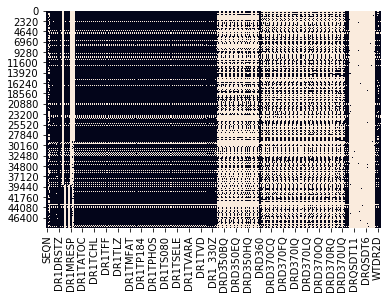

In [969]:
# Look at null data. 
sns.heatmap(diet_all.isnull(), cbar=False)

In [970]:
# Find columns not in all 10 years of data. 
drop_column_list = changed_columns("DR1TOT_")
drop_column_list

['DR1MNRSP',
 'DRQSDT11',
 'DR1MRESP',
 'DR1SKY',
 'DR1HELP',
 'DRQSDT12',
 'DR1HELPD',
 'DR1STY']

In [971]:
# Drop columns not in all 10 years of data. 
diet_all = diet_all.drop(drop_column_list, axis=1)
diet_all.describe()

,SEQN,DBD100,DBQ095Z,DR1BWATZ,DR1DAY,DR1DBIH,DR1DRSTZ,DR1EXMER,DR1LANG,DR1TACAR,...,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT91,DRQSPREP,WTDR2D,WTDRD1
count,48710.000000,27027.000000,45172.000000,44695.000000,45172.000000,44756.000000,48710.000000,45172.000000,45221.000000,43988.000000,...,188.0,7.0,34.0,759.0,133.0,245.0,233.0,45172.000000,41016.000000,46885.000000
mean,67382.595566,1.682651,3.639888,383.922314,4.520499,14.669474,1.343872,38.356128,1.183477,333.588570,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,3.198884,37384.331866,32704.612473
std,15281.061023,0.820018,11.669628,782.470536,2.196034,11.798916,1.088275,18.692177,0.549309,1036.944208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.184336,49858.194133,38871.411887
min,41475.000000,1.000000,1.000000,0.000000,1.000000,-60.000000,1.000000,2.000000,1.000000,0.000000,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,1.000000,0.000000,0.000000
25%,54101.500000,1.000000,1.000000,0.000000,2.000000,5.000000,1.000000,23.000000,1.000000,6.000000,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,3.000000,9037.446910,9739.304356
50%,66698.500000,1.000000,1.000000,0.000000,5.000000,14.000000,1.000000,33.000000,1.000000,34.000000,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,3.000000,20021.815380,19235.078102
75%,81001.750000,2.000000,4.000000,500.000000,6.000000,21.000000,1.000000,49.000000,1.000000,167.000000,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,4.000000,45320.491322,41184.436891
max,93702.000000,9.000000,99.000000,11310.000000,7.000000,76.000000,5.000000,91.000000,6.000000,61530.000000,...,4.0,5.0,6.0,7.0,8.0,9.0,91.0,9.000000,818626.657231,454277.717307


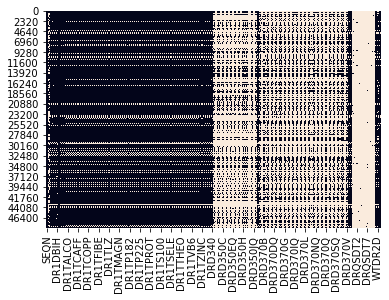

In [972]:
# Recheck nulls. 
sns.heatmap(diet_all.isnull(), cbar=False)

In [973]:
# Check row null counts. Looks like there could be some with almost all nulls from heatmap.  
diet_all_null_counts = diet_all.isnull().sum(axis=1)
diet_all_null_counts.describe()

count    48710.000000
mean        65.161917
std         32.774874
min         25.000000
25%         40.000000
50%         53.000000
75%         75.000000
max        160.000000
dtype: float64

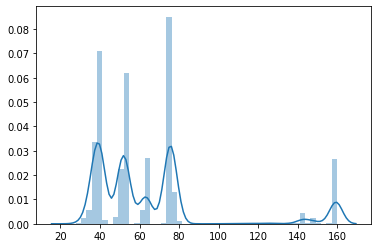

In [974]:
# Look at distribution of null counts per row. 
sns.distplot(diet_all_null_counts)

In [975]:
# 1554 rows with only 2 columns non-null. Not enough data to analyze. Probably just SEQN and one day sample weight. 
diet_all_null_counts[diet_all_null_counts >= 160].count()

1554

In [976]:
# As this is dietary data and is a subset and not the main data file with the full list of identifiers 
# (that would be demographics data), drop all rows that have 160 or more null values. 
diet_all = diet_all[diet_all.isnull().sum(axis=1) < 160]
diet_all.shape

(47156, 162)

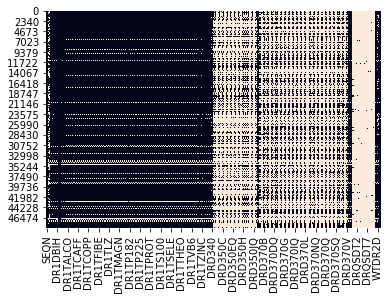

In [977]:
# Recheck nulls. 
sns.heatmap(diet_all.isnull(), cbar=False)

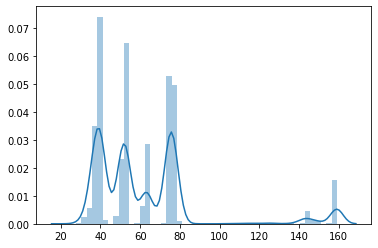

In [978]:
# Look at distribution of null counts per row. Spike near 160 is a little smaller and farther from 160. 
diet_all_null_counts = diet_all.isnull().sum(axis=1)
sns.distplot(diet_all_null_counts)

In [979]:
# Observations with dietary two day sample weights of zero. Just means day 2 dietary recall not done. We don't care
# as only looking at one day of dietary intake data. 
diet_all[diet_all.WTDR2D == 0.0]['SEQN'].count()

2566

In [980]:
# Observations with dietary one day sample weights of zero. This means day one dietary recall not complete. 
# Probably mostly null data for these rows. 
diet_all[diet_all.WTDRD1 == 0.0]['SEQN'].count()

2190

In [981]:
# Write combined diet data to a csv file for future analysis. 
diet_all.to_csv('data/diet_all.csv', na_rep='nan', index=False)

## Look at examination files, then read them in and concatenate them into one datafile.

In [982]:
exam1 = pd.read_csv('nhanes 2007-2008/BPX_E.csv')
exam1.shape

(9762, 27)

In [983]:
exam2 = pd.read_csv('nhanes 2007-2008/BMX_E.csv')
exam2.shape

(9762, 23)

In [984]:
exam = pd.merge(exam1, exam2, on='SEQN')
exam.shape

(9762, 49)

In [985]:
exam['SEQN'].head()

0    41475.0
1    41476.0
2    41477.0
3    41478.0
4    41479.0
Name: SEQN, dtype: float64

In [986]:
# Read all five years of examination data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. Special case - need to read two sets of files and merge them together. 
exam_dtype_dict = {"SEQN": int}
exam1_all = read_nhanes_data(exam_dtype_dict, "BPX_", True)
exam2_all = read_nhanes_data(exam_dtype_dict, "BMX_", True)
exam_all = pd.merge(exam1_all, exam2_all, on='SEQN')
exam_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48710 entries, 0 to 48709
Data columns (total 56 columns):
BPAARM      37194 non-null float64
BPACSZ      37172 non-null float64
BPAEN1      36927 non-null float64
BPAEN2      37088 non-null float64
BPAEN3      37048 non-null float64
BPAEN4      2793 non-null float64
BPQ150A     22261 non-null float64
BPQ150B     22261 non-null float64
BPQ150C     22261 non-null float64
BPQ150D     22261 non-null float64
BPXCHR      9911 non-null float64
BPXDI1      35749 non-null float64
BPXDI2      36079 non-null float64
BPXDI3      35948 non-null float64
BPXDI4      1919 non-null float64
BPXML1      37183 non-null float64
BPXPLS      37182 non-null float64
BPXPTY      37236 non-null float64
BPXPULS     47129 non-null float64
BPXSY1      35749 non-null float64
BPXSY2      36079 non-null float64
BPXSY3      35948 non-null float64
BPXSY4      1919 non-null float64
PEASCCT1    1694 non-null float64
PEASCST1    39166 non-null float64
PEASCTM1    37761 non

In [987]:
# Make sure we didn't lose any rows to inner merge. 
exam1_all.shape

(48710, 27)

In [988]:
exam2_all.shape

(48710, 30)

In [989]:
exam_all.shape

(48710, 56)

In [990]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
exam_all = move_columns(['SEQN'], exam_all)
exam_all.columns

Index(['SEQN', 'BPAARM', 'BPACSZ', 'BPAEN1', 'BPAEN2', 'BPAEN3', 'BPAEN4',
       'BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D', 'BPXCHR', 'BPXDI1',
       'BPXDI2', 'BPXDI3', 'BPXDI4', 'BPXML1', 'BPXPLS', 'BPXPTY', 'BPXPULS',
       'BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4', 'PEASCCT1', 'PEASCST1',
       'PEASCTM1', 'BMDAVSAD', 'BMDBMIC', 'BMDSADCM', 'BMDSTATS', 'BMIARMC',
       'BMIARML', 'BMIHEAD', 'BMIHT', 'BMILEG', 'BMIRECUM', 'BMISUB', 'BMITRI',
       'BMIWAIST', 'BMIWT', 'BMXARMC', 'BMXARML', 'BMXBMI', 'BMXHEAD', 'BMXHT',
       'BMXLEG', 'BMXRECUM', 'BMXSAD1', 'BMXSAD2', 'BMXSAD3', 'BMXSAD4',
       'BMXSUB', 'BMXTRI', 'BMXWAIST', 'BMXWT'],
      dtype='object')

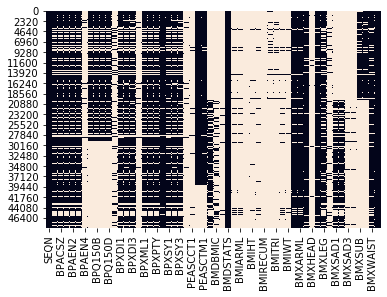

In [991]:
# Look at null values in the dataframe. 
sns.heatmap(exam_all.isnull(), cbar=False)

In [992]:
# Determine columns not in all 10 years of data. 
drop_column_list_1 = changed_columns("BPX_")
drop_column_list_2 = changed_columns("BMX_")
drop_column_list = drop_column_list_1 + drop_column_list_2
drop_column_list

['BPQ150A',
 'BPQ150B',
 'PEASCST1',
 'PEASCTM1',
 'BPQ150D',
 'BPQ150C',
 'BMISUB',
 'BMXSAD1',
 'BMXSAD2',
 'BMDAVSAD',
 'BMITRI',
 'BMXSUB',
 'BMXSAD3',
 'BMXTRI',
 'BMDSADCM',
 'BMDBMIC',
 'BMXSAD4']

In [993]:
# Drop columns not in all 10 years of data. 
exam_all = exam_all.drop(drop_column_list, axis=1)
exam_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48710 entries, 0 to 48709
Data columns (total 39 columns):
SEQN        48710 non-null int32
BPAARM      37194 non-null float64
BPACSZ      37172 non-null float64
BPAEN1      36927 non-null float64
BPAEN2      37088 non-null float64
BPAEN3      37048 non-null float64
BPAEN4      2793 non-null float64
BPXCHR      9911 non-null float64
BPXDI1      35749 non-null float64
BPXDI2      36079 non-null float64
BPXDI3      35948 non-null float64
BPXDI4      1919 non-null float64
BPXML1      37183 non-null float64
BPXPLS      37182 non-null float64
BPXPTY      37236 non-null float64
BPXPULS     47129 non-null float64
BPXSY1      35749 non-null float64
BPXSY2      36079 non-null float64
BPXSY3      35948 non-null float64
BPXSY4      1919 non-null float64
PEASCCT1    1694 non-null float64
BMDSTATS    48710 non-null float64
BMIARMC     1884 non-null float64
BMIARML     1862 non-null float64
BMIHEAD     0 non-null float64
BMIHT       1206 non-null flo

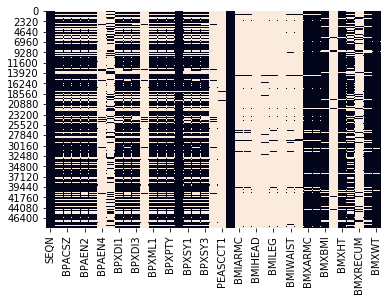

In [994]:
# Recheck missing data. 
sns.heatmap(exam_all.isnull(), cbar=False)

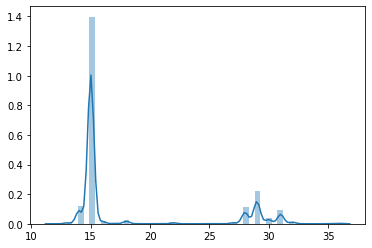

In [995]:
# Look at distribution of null counts per row. 
exam_all_null_counts = exam_all.isnull().sum(axis=1)
sns.distplot(exam_all_null_counts)

In [996]:
exam_all.describe()

,SEQN,BPAARM,BPACSZ,BPAEN1,BPAEN2,BPAEN3,BPAEN4,BPXCHR,BPXDI1,BPXDI2,...,BMIWT,BMXARMC,BMXARML,BMXBMI,BMXHEAD,BMXHT,BMXLEG,BMXRECUM,BMXWAIST,BMXWT
count,48710.000000,37194.000000,37172.000000,36927.000000,37088.000000,37048.000000,2793.000000,9911.000000,35749.000000,36079.000000,...,1925.000000,46083.000000,46087.000000,44686.000000,1178.000000,44744.000000,36526.000000,5617.000000,42689.000000,48204.000000
mean,67382.595566,1.006829,3.686108,1.997373,1.973037,1.975572,1.886860,105.635556,66.391619,65.935752,...,2.955844,28.463833,33.010181,25.736653,41.349236,155.801659,38.118225,81.656354,87.375860,62.427809
std,15281.061023,0.134443,0.784757,0.051186,0.161977,0.154375,0.316821,20.889860,14.733086,15.236072,...,0.500128,7.966656,7.492604,7.800756,2.573878,23.393445,4.150089,14.066547,22.454219,32.217609
min,41475.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,9.600000,9.000000,11.500000,32.500000,79.100000,20.400000,45.000000,37.800000,2.700000
25%,54101.500000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,90.000000,58.000000,58.000000,...,3.000000,22.500000,30.200000,19.800000,39.500000,149.700000,35.400000,70.200000,71.600000,37.300000
50%,66698.500000,1.000000,4.000000,2.000000,2.000000,2.000000,2.000000,104.000000,68.000000,68.000000,...,3.000000,29.400000,35.500000,25.000000,41.700000,162.000000,38.200000,82.800000,88.400000,65.700000
75%,81001.750000,1.000000,4.000000,2.000000,2.000000,2.000000,2.000000,118.000000,76.000000,76.000000,...,3.000000,34.000000,38.000000,30.200000,43.200000,171.300000,41.000000,93.200000,102.800000,83.600000
max,93702.000000,8.000000,5.000000,2.000000,2.000000,2.000000,2.000000,208.000000,134.000000,144.000000,...,4.000000,61.000000,48.100000,84.870000,48.500000,204.500000,55.500000,116.700000,179.000000,239.400000


In [997]:
# Write combined examination data to a csv file for further analysis. 
exam_all.to_csv('data/exam_all.csv', na_rep='nan', index=False)

## Look at medication files, then read them in and concatenate them into one datafile.

In [998]:
# Had problem with RXDDRUG field containing comma but not enclosed in quotes. Verify we got the entire column value. 
meds = pd.read_csv('nhanes 2007-2008/RXQ_RX_E.csv', dtype={'SEQN': int})
meds[meds['SEQN'] == 48857]

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDCOUNT
15077,48857,1.0,ALBUTEROL,d00749,2.0,91.0,6.0
15078,48857,1.0,"ANXIOLYTICS, SEDATIVES, AND HYPNOTICS - UNSPEC...",c00067,2.0,5.0,6.0
15079,48857,1.0,FLUTICASONE,d01296,2.0,91.0,6.0
15080,48857,1.0,FLUTICASONE; SALMETEROL,d04611,2.0,91.0,6.0
15081,48857,1.0,MONOAMINE OXIDASE INHIBITORS - UNSPECIFIED,c00250,2.0,2.0,6.0
15082,48857,1.0,MONTELUKAST,d04289,2.0,122.0,6.0


In [999]:
meds.head()

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDCOUNT
0,41475,1.0,ATENOLOL,d00004,1.0,2555.0,4.0
1,41475,1.0,HYDROCHLOROTHIAZIDE,d00253,1.0,2555.0,4.0
2,41475,1.0,LEVOTHYROXINE,d00278,2.0,2555.0,4.0
3,41475,1.0,LOVASTATIN,d00280,1.0,2920.0,4.0
4,41476,1.0,MUPIROCIN TOPICAL,d01267,1.0,5.0,1.0


In [1000]:
# Read all five years of medication data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
# RXDUSE should be int but has ONE Nan value! May end up dropping that row. 
# UTF-8 encoding errors so switched to ISO-8859-1, no errors. Don't use function read_nhanes_data as need encoding option. 
meds_dtype_dict = {"SEQN": int}
meds_files = glob.iglob('nhanes*/RXQ_RX_*.csv')
meds_all = pd.concat((pd.read_csv(f, dtype=meds_dtype_dict, encoding = "ISO-8859-1") for f in meds_files), 
                     ignore_index=True, sort=True)
meds_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99966 entries, 0 to 99965
Data columns (total 13 columns):
RXDCOUNT    82446 non-null float64
RXDDAYS     82233 non-null float64
RXDDRGID    69988 non-null object
RXDDRUG     70410 non-null object
RXDRSC1     27617 non-null object
RXDRSC2     1590 non-null object
RXDRSC3     246 non-null object
RXDRSD1     26722 non-null object
RXDRSD2     1590 non-null object
RXDRSD3     246 non-null object
RXDUSE      99965 non-null float64
RXQSEEN     82196 non-null float64
SEQN        99966 non-null int32
dtypes: float64(4), int32(1), object(8)
memory usage: 9.5+ MB


In [1001]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
meds_all = move_columns(['SEQN', 'RXDUSE'], meds_all)
meds_all.columns

Index(['SEQN', 'RXDUSE', 'RXDCOUNT', 'RXDDAYS', 'RXDDRGID', 'RXDDRUG',
       'RXDRSC1', 'RXDRSC2', 'RXDRSC3', 'RXDRSD1', 'RXDRSD2', 'RXDRSD3',
       'RXQSEEN'],
      dtype='object')

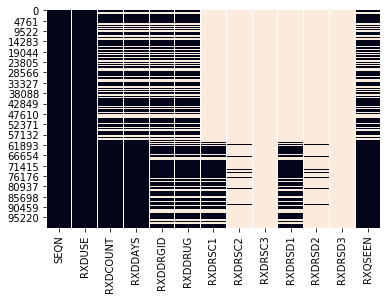

In [1002]:
# Look at null values in the dataframe. 
# RXDRSC1, RXDRSC2, RXDRSC3 are IDC-10 codes we had planned to use to create model to predict diabetes, prediabetes
#    from all features, including diagnostic lab tests. 
# Leave all columns for now until we decide whether to reduce time interval of study or change modeling plan. 
sns.heatmap(meds_all.isnull(), cbar=False)

In [1003]:
meds_all.describe()

,SEQN,RXDUSE,RXDCOUNT,RXDDAYS,RXQSEEN
count,99966.000000,99965.000000,82446.000000,82233.000000,82196.000000
mean,67276.189474,1.297404,4.904544,2987.268311,0.999088
std,15341.515986,0.470703,3.999046,11899.881739,0.572744
min,41475.000000,1.000000,0.000000,0.000000,0.000000
25%,53864.000000,1.000000,2.000000,61.000000,1.000000
50%,66631.500000,1.000000,4.000000,730.000000,1.000000
75%,80875.750000,2.000000,7.000000,2190.000000,1.000000
max,93702.000000,9.000000,23.000000,99999.000000,3.000000


In [1004]:
# Write combined medication data to csv file for further analysis. 
meds_all.to_csv('data/meds_all.csv', na_rep='nan', index=False)

## Load labs files,concatenate them and merge them into one datafile. There are 28 in total. 

**1. Albumin & Creatinine – Urine**

In [1005]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs1_dtype_dict = {"SEQN": int}
labs1_all = read_nhanes_data(labs1_dtype_dict, "ALB_CR_", True)
labs1_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41443 entries, 0 to 41442
Data columns (total 13 columns):
SEQN        41443 non-null int32
URDACT      32366 non-null float64
URDACT2     7361 non-null float64
URDUCR2S    7361 non-null float64
URDUCRLC    8280 non-null float64
URDUMA2S    7361 non-null float64
URDUMALC    8280 non-null float64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUCR2     7361 non-null float64
URXUMA      40244 non-null float64
URXUMA2     7361 non-null float64
URXUMS      40244 non-null float64
dtypes: float64(12), int32(1)
memory usage: 4.0 MB


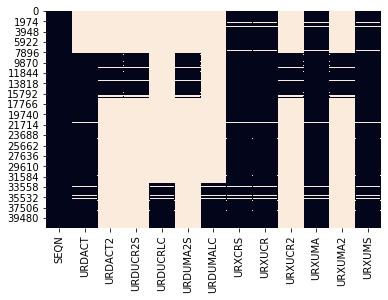

In [1006]:
# Look at null values in the dataframe. 
sns.heatmap(labs1_all.isnull(), cbar=False)

In [1007]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("ALB_CR_")
drop_column_list

['URDUCRLC',
 'URXUCR2',
 'URDACT',
 'URXUMA2',
 'URDUCR2S',
 'URDACT2',
 'URDUMALC',
 'URDUMA2S']

In [1008]:
# Drop columns not present in all 10 years. 
labs1_all = labs1_all.drop(drop_column_list, axis=1)

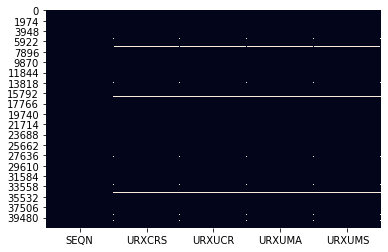

In [1009]:
# Recheck missing data. 
sns.heatmap(labs1_all.isnull(), cbar=False)

In [1010]:
labs1_all.describe()

,SEQN,URXCRS,URXUCR,URXUMA,URXUMS
count,41443.000000,40244.000000,40244.000000,40244.000000,40244.000000
mean,67750.936901,10812.336423,122.311506,42.614195,42.614195
std,15385.913007,7043.965383,79.682868,295.820642,295.820642
min,41475.000000,265.000000,3.000000,0.210000,0.210000
25%,54337.500000,5392.400000,61.000000,4.400000,4.400000
50%,67143.000000,9547.200000,108.000000,8.400000,8.400000
75%,81597.000000,14586.000000,165.000000,17.500000,17.500000
max,93702.000000,70720.000000,800.000000,24440.000000,24440.000000


**2. Apolipoprotein B**

In [1011]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs2_dtype_dict = {"SEQN": int}
labs2_all = read_nhanes_data(labs2_dtype_dict, "ApoB_", False)
labs2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 4 columns):
SEQN        16655 non-null int32
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
dtypes: float64(3), int32(1)
memory usage: 455.5 KB


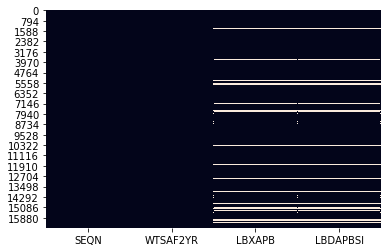

In [1012]:
# Look at null values in the dataframe. 
sns.heatmap(labs2_all.isnull(), cbar=False)

In [1013]:
# Note: WTSAF2YR = 0 means there was no lab result. 
labs2_all.describe()

,SEQN,WTSAF2YR,LBXAPB,LBDAPBSI
count,16655.000000,16655.000000,15313.000000,15313.000000
mean,67277.762534,77411.372067,87.808072,0.878081
std,15207.220908,76787.701830,25.593495,0.255935
min,41479.000000,0.000000,15.000000,0.150000
25%,54290.500000,29792.025500,69.000000,0.690000
50%,66460.000000,52879.102000,86.000000,0.860000
75%,80782.000000,93276.033344,103.000000,1.030000
max,93697.000000,521632.185830,260.000000,2.600000


**3. Standard Biochemistry Profile**

In [1014]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs3_dtype_dict = {"SEQN": int}
labs3_all = read_nhanes_data(labs3_dtype_dict, "BIOPRO_", True)
labs3_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 38 columns):
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 non-null float64
LBXSC3SI    32019 non-null float64
LBXSCA      31977 non-null float64
LBXSCH      32014 non-null float64
LBXSCK      18758 non-null float64
LBXSCLSI    32018 non-null float64
LBXSCR      32020 non-null float64
LBXSGB      31979 non-null float64
LBXSGL      3202

In [1015]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs3_all = move_columns(['SEQN'], labs3_all)
labs3_all.columns

Index(['SEQN', 'LBDSALSI', 'LBDSBUSI', 'LBDSCASI', 'LBDSCHSI', 'LBDSCRSI',
       'LBDSGBSI', 'LBDSGLSI', 'LBDSIRSI', 'LBDSPHSI', 'LBDSTBSI', 'LBDSTPSI',
       'LBDSTRSI', 'LBDSUASI', 'LBXSAL', 'LBXSAPSI', 'LBXSASSI', 'LBXSATSI',
       'LBXSBU', 'LBXSC3SI', 'LBXSCA', 'LBXSCH', 'LBXSCK', 'LBXSCLSI',
       'LBXSCR', 'LBXSGB', 'LBXSGL', 'LBXSGTSI', 'LBXSIR', 'LBXSKSI',
       'LBXSLDSI', 'LBXSNASI', 'LBXSOSSI', 'LBXSPH', 'LBXSTB', 'LBXSTP',
       'LBXSTR', 'LBXSUA'],
      dtype='object')

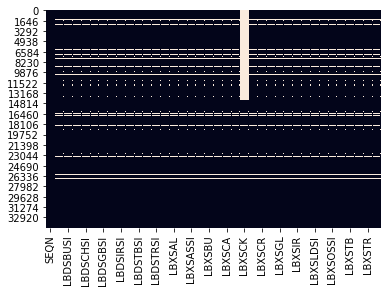

In [1016]:
# Look at null values in the dataframe. 
sns.heatmap(labs3_all.isnull(), cbar=False)

In [1017]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("BIOPRO_")
drop_column_list

['LBXSCK']

In [1018]:
# Drop columns not present in all 10 years. 
labs3_all = labs3_all.drop(drop_column_list, axis=1)

In [1019]:
labs3_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 37 columns):
SEQN        34558 non-null int32
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 non-null float64
LBXSC3SI    32019 non-null float64
LBXSCA      31977 non-null float64
LBXSCH      32014 non-null float64
LBXSCLSI    32018 non-null float64
LBXSCR      32020 non-null float64
LBXSGB      31979 non-null float64
LBXSGL      32023 

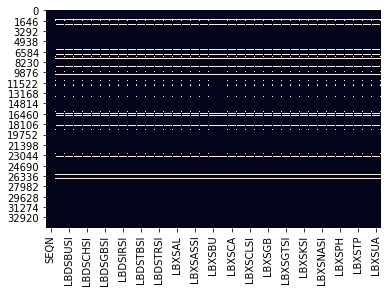

In [1020]:
# Recheck missing data. 
sns.heatmap(labs3_all.isnull(), cbar=False)

In [1021]:
labs3_all.describe()

,SEQN,LBDSALSI,LBDSBUSI,LBDSCASI,LBDSCHSI,LBDSCRSI,LBDSGBSI,LBDSGLSI,LBDSIRSI,LBDSPHSI,...,LBXSIR,LBXSKSI,LBXSLDSI,LBXSNASI,LBXSOSSI,LBXSPH,LBXSTB,LBXSTP,LBXSTR,LBXSUA
count,34558.000000,32022.000000,32018.000000,31977.000000,32014.000000,32020.000000,31979.000000,32023.000000,31977.000000,32017.000000,...,31977.000000,32016.000000,32007.000000,32019.000000,32016.000000,32017.000000,31999.000000,31980.000000,32001.000000,32013.000000
mean,67356.969587,42.878896,4.661545,2.359600,4.840255,76.775149,28.852434,5.597892,15.009635,1.244145,...,83.804109,3.977582,130.616365,139.217527,278.094172,3.853064,0.687130,7.173058,145.102434,5.380399
std,15279.686150,3.465951,2.061450,0.091289,1.097554,37.255001,4.493686,2.112301,6.399098,0.204185,...,35.729283,0.339021,31.465005,2.248867,5.026536,0.632348,0.312157,0.468940,127.000798,1.424331
min,41475.000000,12.000000,0.360000,1.625000,0.155000,12.380000,6.000000,1.050000,0.400000,0.323000,...,2.000000,2.300000,4.000000,102.000000,207.000000,1.000000,0.000000,3.400000,9.000000,0.400000
25%,54085.250000,41.000000,3.210000,2.300000,4.060000,61.000000,26.000000,4.660000,10.600000,1.098000,...,59.000000,3.800000,112.000000,138.000000,275.000000,3.400000,0.500000,6.900000,74.000000,4.400000
50%,66671.500000,43.000000,4.280000,2.350000,4.732000,72.490000,28.000000,5.110000,14.300000,1.227000,...,80.000000,4.000000,127.000000,139.000000,278.000000,3.800000,0.600000,7.200000,112.000000,5.300000
75%,80967.750000,45.000000,5.360000,2.425000,5.508000,86.630000,31.000000,5.720000,18.600000,1.356000,...,104.000000,4.200000,145.000000,141.000000,281.000000,4.200000,0.800000,7.500000,176.000000,6.300000
max,93702.000000,56.000000,34.270000,3.700000,16.525000,1539.040000,75.000000,43.130000,99.800000,3.520000,...,557.000000,7.300000,1539.000000,161.000000,323.000000,10.900000,7.300000,11.300000,6057.000000,18.000000


**4. Complete Blood Count with 5-part Differential – Whole Blood**

In [1022]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs4_dtype_dict = {"SEQN": int}
labs4_all = read_nhanes_data(labs4_dtype_dict, "CBC_", True) 
labs4_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 22 columns):
LBDBANO     41614 non-null float64
LBDEONO     41614 non-null float64
LBDLYMNO    41614 non-null float64
LBDMONO     41614 non-null float64
LBDNENO     41614 non-null float64
LBXBAPCT    41616 non-null float64
LBXEOPCT    41616 non-null float64
LBXHCT      41680 non-null float64
LBXHGB      41680 non-null float64
LBXLYPCT    41616 non-null float64
LBXMC       33563 non-null float64
LBXMCH      0 non-null float64
LBXMCHSI    41680 non-null float64
LBXMCVSI    41680 non-null float64
LBXMOPCT    41616 non-null float64
LBXMPSI     41679 non-null float64
LBXNEPCT    41616 non-null float64
LBXPLTSI    41679 non-null float64
LBXRBCSI    41680 non-null float64
LBXRDW      41680 non-null float64
LBXWBCSI    41678 non-null float64
SEQN        46685 non-null int32
dtypes: float64(21), int32(1)
memory usage: 7.7 MB


In [1023]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs4_all = move_columns(['SEQN'], labs4_all)
labs4_all.columns

Index(['SEQN', 'LBDBANO', 'LBDEONO', 'LBDLYMNO', 'LBDMONO', 'LBDNENO',
       'LBXBAPCT', 'LBXEOPCT', 'LBXHCT', 'LBXHGB', 'LBXLYPCT', 'LBXMC',
       'LBXMCH', 'LBXMCHSI', 'LBXMCVSI', 'LBXMOPCT', 'LBXMPSI', 'LBXNEPCT',
       'LBXPLTSI', 'LBXRBCSI', 'LBXRDW', 'LBXWBCSI'],
      dtype='object')

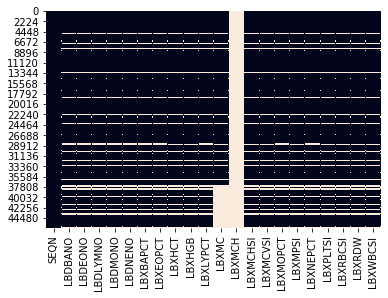

In [1024]:
# Look at null values in the dataframe. 
sns.heatmap(labs4_all.isnull(), cbar=False)

In [1025]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("CBC_")
drop_column_list

['LBXMCH', 'LBXMC']

In [1026]:
# Drop columns not present in all 10 years. 
labs4_all = labs4_all.drop(drop_column_list, axis=1)

In [1027]:
labs4_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 20 columns):
SEQN        46685 non-null int32
LBDBANO     41614 non-null float64
LBDEONO     41614 non-null float64
LBDLYMNO    41614 non-null float64
LBDMONO     41614 non-null float64
LBDNENO     41614 non-null float64
LBXBAPCT    41616 non-null float64
LBXEOPCT    41616 non-null float64
LBXHCT      41680 non-null float64
LBXHGB      41680 non-null float64
LBXLYPCT    41616 non-null float64
LBXMCHSI    41680 non-null float64
LBXMCVSI    41680 non-null float64
LBXMOPCT    41616 non-null float64
LBXMPSI     41679 non-null float64
LBXNEPCT    41616 non-null float64
LBXPLTSI    41679 non-null float64
LBXRBCSI    41680 non-null float64
LBXRDW      41680 non-null float64
LBXWBCSI    41678 non-null float64
dtypes: float64(19), int32(1)
memory usage: 6.9 MB


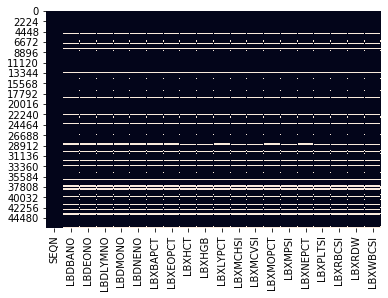

In [1028]:
# Recheck missing data.
sns.heatmap(labs4_all.isnull(), cbar=False)

In [1029]:
labs4_all.describe()

,SEQN,LBDBANO,LBDEONO,LBDLYMNO,LBDMONO,LBDNENO,LBXBAPCT,LBXEOPCT,LBXHCT,LBXHGB,LBXLYPCT,LBXMCHSI,LBXMCVSI,LBXMOPCT,LBXMPSI,LBXNEPCT,LBXPLTSI,LBXRBCSI,LBXRDW,LBXWBCSI
count,46685.000000,41614.000000,41614.000000,41614.000000,41614.000000,41614.000000,41616.000000,41616.000000,41680.000000,41680.000000,41616.000000,41680.000000,41680.000000,41616.000000,41679.000000,41616.000000,41679.000000,41680.000000,41680.000000,41678.000000
mean,67414.585134,0.043757,0.218549,2.411854,0.565649,4.033986,0.715881,3.051367,40.370144,13.725701,33.781918,29.609657,87.077476,7.995391,8.017925,54.515420,259.410159,4.647660,13.186384,7.276170
std,15277.936180,0.064918,0.197499,1.280750,0.210386,1.788179,0.518578,2.419914,4.223448,1.497042,10.656563,2.514970,6.360812,2.369688,0.959531,11.619401,71.016712,0.473737,1.295934,2.404981
min,41475.000000,0.000000,0.000000,0.200000,0.000000,0.100000,0.000000,0.000000,17.900000,6.100000,2.600000,13.800000,50.500000,0.600000,4.700000,0.800000,11.000000,1.670000,6.300000,1.400000
25%,54144.000000,0.000000,0.100000,1.800000,0.400000,2.800000,0.400000,1.500000,37.400000,12.700000,26.500000,28.300000,83.500000,6.400000,7.400000,47.500000,211.000000,4.340000,12.400000,5.700000
50%,66731.000000,0.000000,0.200000,2.200000,0.500000,3.800000,0.600000,2.400000,40.200000,13.700000,32.600000,29.800000,87.600000,7.800000,8.000000,55.600000,251.000000,4.630000,13.000000,6.900000
75%,81035.000000,0.100000,0.300000,2.800000,0.700000,4.900000,0.900000,3.800000,43.400000,14.800000,39.900000,31.200000,91.300000,9.200000,8.600000,62.600000,298.000000,4.950000,13.700000,8.400000
max,93702.000000,4.700000,8.400000,110.800000,10.200000,83.100000,19.700000,36.600000,59.100000,19.700000,94.500000,74.500000,125.300000,66.900000,15.100000,96.600000,1000.000000,8.300000,37.800000,117.200000


**5. Chlamydia – Urine**

In [1030]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs5_dtype_dict = {"SEQN": int}
labs5_all = read_nhanes_data(labs5_dtype_dict, "CHLMDA_", True)
labs5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10981 entries, 0 to 10980
Data columns (total 3 columns):
SEQN      10981 non-null int32
URXUCL    10710 non-null float64
URXUGC    2052 non-null float64
dtypes: float64(2), int32(1)
memory usage: 214.6 KB


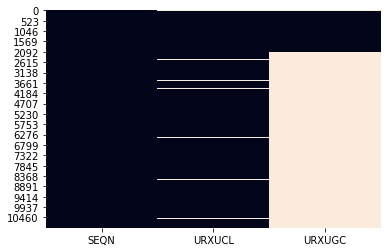

In [1031]:
# Look at null values in the dataframe. 
sns.heatmap(labs5_all.isnull(), cbar=False)

In [1032]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("CHLMDA_")
drop_column_list

['URXUGC']

In [1033]:
# Drop columns not present in all 10 years. 
labs5_all = labs5_all.drop(drop_column_list, axis=1)

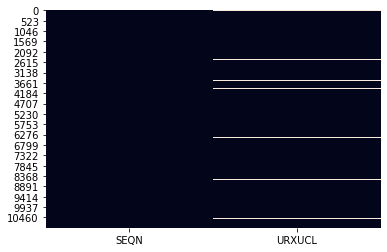

In [1034]:
# Recheck missing data. 
sns.heatmap(labs5_all.isnull(), cbar=False)

In [1035]:
labs5_all.describe()

,SEQN,URXUCL
count,10981.000000,10710.000000
mean,67469.385029,1.975537
std,15164.257386,0.154489
min,41481.000000,1.000000
25%,54395.000000,2.000000
50%,66803.000000,2.000000
75%,80885.000000,2.000000
max,93702.000000,2.000000


**6. Personal Care and Consumer Product Chemicals and Metabolites**

In [1036]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
# Note: The file name changed in 2013 but the data is mostly the same. EPH*.csv will catch them all. 
labs6_dtype_dict = {"SEQN": int}
labs6_all = read_nhanes_data(labs6_dtype_dict, "EPH", True)
labs6_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13711 entries, 0 to 13710
Data columns (total 30 columns):
SEQN        13711 non-null int32
URD14DLC    5337 non-null float64
URD4TOLC    5353 non-null float64
URDBP3LC    13179 non-null float64
URDBPFLC    5333 non-null float64
URDBPHLC    13179 non-null float64
URDBPSLC    5333 non-null float64
URDBUPLC    13179 non-null float64
URDDCBLC    5337 non-null float64
URDEPBLC    13179 non-null float64
URDMPBLC    13179 non-null float64
URDPPBLC    13179 non-null float64
URDTLCLC    5337 non-null float64
URDTRSLC    13179 non-null float64
URX14D      5337 non-null float64
URX4TO      5353 non-null float64
URXBP3      13179 non-null float64
URXBPF      5333 non-null float64
URXBPH      13179 non-null float64
URXBPS      5333 non-null float64
URXBUP      13179 non-null float64
URXDCB      5337 non-null float64
URXEPB      13179 non-null float64
URXMPB      13179 non-null float64
URXPPB      13179 non-null float64
URXTLC      5337 non-null flo

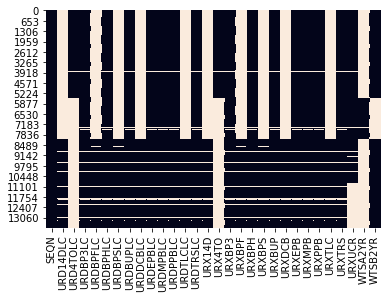

In [1037]:
# Look at null values in the dataframe. 
sns.heatmap(labs6_all.isnull(), cbar=False)

In [1038]:
# Determine columns not in all of first set of files. 
drop_column_list_1 = changed_columns("EPHPP_")
drop_column_list_1

['URXUCR']

In [1039]:
# Determine columns not in all of second set of files. 
drop_column_list_2 = changed_columns("EPH_")
drop_column_list_2

['URX4TO', 'WTSA2YR', 'WTSB2YR', 'URD4TOLC']

In [1040]:
# Find columns between EPHPP_ and EPH_ - special case as file names change. 
n11_columns = pd.read_csv('nhanes 2011-2012/EPH_G.csv', nrows=0).columns.tolist()
n13_columns = pd.read_csv('nhanes 2013-2014/EPHPP_H.csv', nrows=0).columns.tolist()
diff_11_13 = list((set(n11_columns) | set(n13_columns)) - (set(n11_columns) & set(n13_columns)))
drop_column_list = drop_column_list_1 + drop_column_list_2 + diff_11_13
drop_column_list

['URXUCR',
 'URX4TO',
 'WTSA2YR',
 'WTSB2YR',
 'URD4TOLC',
 'URDTLCLC',
 'URXBPS',
 'URD14DLC',
 'URXDCB',
 'WTSA2YR',
 'WTSB2YR',
 'URDBPFLC',
 'URXBPF',
 'URXTLC',
 'URX14D',
 'URDDCBLC',
 'URDBPSLC']

In [1041]:
# Drop columns not present in all 10 years. 
labs6_all = labs6_all.drop(drop_column_list, axis=1)

In [1042]:
labs6_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13711 entries, 0 to 13710
Data columns (total 15 columns):
SEQN        13711 non-null int32
URDBP3LC    13179 non-null float64
URDBPHLC    13179 non-null float64
URDBUPLC    13179 non-null float64
URDEPBLC    13179 non-null float64
URDMPBLC    13179 non-null float64
URDPPBLC    13179 non-null float64
URDTRSLC    13179 non-null float64
URXBP3      13179 non-null float64
URXBPH      13179 non-null float64
URXBUP      13179 non-null float64
URXEPB      13179 non-null float64
URXMPB      13179 non-null float64
URXPPB      13179 non-null float64
URXTRS      13179 non-null float64
dtypes: float64(14), int32(1)
memory usage: 1.5 MB


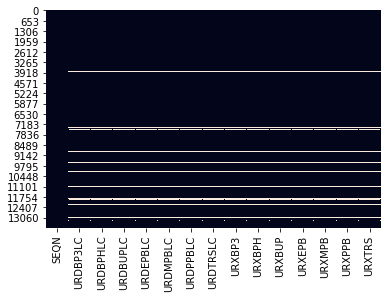

In [1043]:
# Recheck missing data. 
sns.heatmap(labs6_all.isnull(), cbar=False)

In [1044]:
labs6_all.describe()

,SEQN,URDBP3LC,URDBPHLC,URDBUPLC,URDEPBLC,URDMPBLC,URDPPBLC,URDTRSLC,URXBP3,URXBPH,URXBUP,URXEPB,URXMPB,URXPPB,URXTRS
count,13711.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000,13179.000000
mean,67692.299978,0.031414,0.067456,0.669247,0.537294,0.009485,0.041733,0.258366,270.465871,3.333119,2.673768,17.691131,236.255850,54.601307,80.418937
std,15386.159214,0.174439,0.250819,0.470502,0.498626,0.096931,0.199986,0.437753,2138.742722,15.548301,19.403512,87.637091,641.587655,178.533052,255.143187
min,41476.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280000,0.140000,0.070000,0.710000,0.710000,0.070000,1.200000
25%,54149.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.300000,0.800000,0.070000,0.710000,13.000000,1.100000,1.630000
50%,67073.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,12.900000,1.500000,0.140000,0.710000,50.900000,5.600000,6.600000
75%,81585.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,51.000000,3.100000,0.300000,4.400000,206.000000,37.450000,32.000000
max,93700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99886.700000,965.000000,1150.000000,3130.000000,24888.400000,6399.600000,9572.000000


**7. Fasting Questionnaire**

In [1045]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs7_dtype_dict = {"SEQN": int}
labs7_all = read_nhanes_data(labs7_dtype_dict, "FASTQX_", False)
labs7_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 19 columns):
SEQN        46685 non-null int32
PHQ020      45011 non-null float64
PHACOFHR    314 non-null float64
PHACOFMN    314 non-null float64
PHQ030      45011 non-null float64
PHAALCHR    129 non-null float64
PHAALCMN    129 non-null float64
PHQ040      45011 non-null float64
PHAGUMHR    1036 non-null float64
PHAGUMMN    1036 non-null float64
PHQ050      45011 non-null float64
PHAANTHR    124 non-null float64
PHAANTMN    124 non-null float64
PHQ060      45011 non-null float64
PHASUPHR    313 non-null float64
PHASUPMN    313 non-null float64
PHAFSTHR    45010 non-null float64
PHAFSTMN    45010 non-null float64
PHDSESN     46685 non-null float64
dtypes: float64(18), int32(1)
memory usage: 6.6 MB


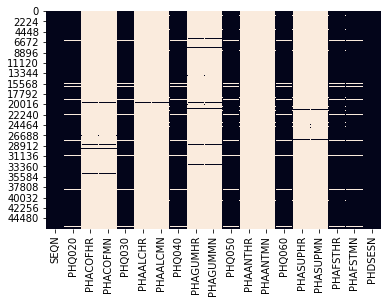

In [1046]:
# Look at null values in the dataframe. 
sns.heatmap(labs7_all.isnull(), cbar=False)

In [1047]:
# Fasting times are only populated for the people who said yes, they had eaten or drank the specific item. 
#     Missing data are for those who answered no, they had not eaten or drank that specific item. 

In [1048]:
labs7_all.describe()

,SEQN,PHQ020,PHACOFHR,PHACOFMN,PHQ030,PHAALCHR,PHAALCMN,PHQ040,PHAGUMHR,PHAGUMMN,PHQ050,PHAANTHR,PHAANTMN,PHQ060,PHASUPHR,PHASUPMN,PHAFSTHR,PHAFSTMN,PHDSESN
count,46685.000000,45011.000000,314.000000,314.000000,45011.000000,129.000000,129.000000,45011.000000,1036.000000,1036.000000,45011.000000,124.000000,124.000000,45011.000000,313.000000,313.000000,45010.000000,45010.000000,46685.000000
mean,67414.585134,1.993024,3.347134,29.022293,1.997134,8.248062,29.953488,1.976983,1.487452,21.438224,1.997245,5.008065,29.516129,1.993046,3.555911,30.686901,6.212664,29.232682,0.709650
std,15277.936180,0.083232,3.604737,17.909146,0.053459,5.319526,16.593890,0.149958,2.816932,17.759723,0.052415,5.351842,16.505473,0.083100,4.009313,16.976352,5.362739,17.444422,0.742646
min,41475.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54144.000000,2.000000,1.000000,13.250000,2.000000,3.000000,17.000000,2.000000,0.000000,5.000000,2.000000,1.000000,15.000000,2.000000,1.000000,17.000000,2.000000,14.000000,0.000000
50%,66731.000000,2.000000,2.000000,30.000000,2.000000,10.000000,30.000000,2.000000,0.000000,17.000000,2.000000,3.000000,31.000000,2.000000,2.000000,32.000000,4.000000,30.000000,1.000000
75%,81035.000000,2.000000,4.000000,46.000000,2.000000,11.000000,44.000000,2.000000,2.000000,36.000000,2.000000,9.000000,40.500000,2.000000,4.000000,45.000000,11.000000,44.000000,1.000000
max,93702.000000,2.000000,19.000000,59.000000,2.000000,33.000000,59.000000,2.000000,18.000000,59.000000,2.000000,38.000000,59.000000,2.000000,24.000000,59.000000,52.000000,59.000000,2.000000


**8. Cholesterol**

In [1049]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs8_dtype_dict = {"SEQN": int}
labs8_all = read_nhanes_data(labs8_dtype_dict, "HDL_", False)
labs8_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 3 columns):
SEQN        40856 non-null int32
LBDHDD      37102 non-null float64
LBDHDDSI    37102 non-null float64
dtypes: float64(2), int32(1)
memory usage: 798.0 KB


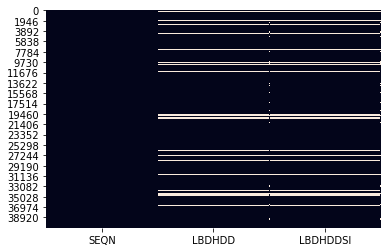

In [1050]:
# Look at null values in the dataframe. 
sns.heatmap(labs8_all.isnull(), cbar=False)

In [1051]:
labs8_all.describe()

,SEQN,LBDHDD,LBDHDDSI
count,40856.000000,37102.000000,37102.000000
mean,67447.719233,52.958843,1.369591
std,15281.419043,15.340040,0.396662
min,41475.000000,6.000000,0.160000
25%,54150.750000,42.000000,1.090000
50%,66788.500000,51.000000,1.320000
75%,81072.250000,61.000000,1.580000
max,93702.000000,226.000000,5.840000


**9. Hepatitis A**

In [1052]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs9_dtype_dict = {"SEQN": int}
labs9_all = read_nhanes_data(labs9_dtype_dict, "HEPA_", False)
labs9_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
SEQN     45334 non-null int32
LBXHA    39719 non-null float64
dtypes: float64(1), int32(1)
memory usage: 531.3 KB


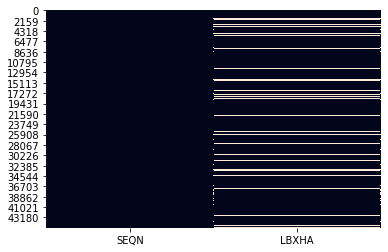

In [1053]:
# Look at null values in the dataframe. 
sns.heatmap(labs9_all.isnull(), cbar=False)

In [1054]:
labs9_all.describe()

,SEQN,LBXHA
count,45334.000000,39719.000000
mean,67436.536463,1.454342
std,15265.516839,0.501143
min,41475.000000,1.000000
25%,54177.250000,1.000000
50%,66772.500000,1.000000
75%,81028.750000,2.000000
max,93702.000000,3.000000


**10. Hepatitis B Surface Antibody**

In [1055]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs10_dtype_dict = {"SEQN": int}
labs10_all = read_nhanes_data(labs10_dtype_dict, "HEPB_S_", False)
labs10_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
SEQN      45334 non-null int32
LBXHBS    39946 non-null float64
dtypes: float64(1), int32(1)
memory usage: 531.3 KB


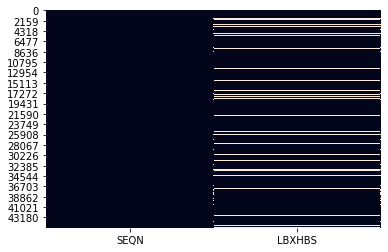

In [1056]:
# Look at null values in the dataframe. 
sns.heatmap(labs10_all.isnull(), cbar=False)

In [1057]:
labs10_all.describe()

,SEQN,LBXHBS
count,45334.000000,39946.000000
mean,67436.536463,1.684599
std,15265.516839,0.464681
min,41475.000000,1.000000
25%,54177.250000,1.000000
50%,66772.500000,2.000000
75%,81028.750000,2.000000
max,93702.000000,2.000000


**11. Hepatitis B core antibody, surface antigen, and Hepatitis D antibody**

In [1058]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs11_dtype_dict = {"SEQN": int}
labs11_all = read_nhanes_data(labs11_dtype_dict, "HEPBD_", False)
labs11_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 4 columns):
SEQN      40856 non-null int32
LBXHBC    37141 non-null float64
LBDHBG    30460 non-null float64
LBDHD     30460 non-null float64
dtypes: float64(3), int32(1)
memory usage: 1.1 MB


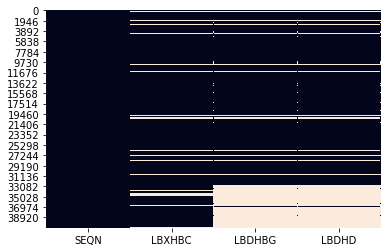

In [1059]:
# Look at null values in the dataframe. 
sns.heatmap(labs11_all.isnull(), cbar=False)

In [1060]:
# NHANES doc says no changes to testing, but lots of missing data in 2015-2016 cycle. 
# Looks like they ran all tests prior to 2015 but only ran surface antigen and anti-HDV tests on positive 
#     core antibody tests starting in 2015. 

In [1061]:
# Determine columns not in all 10 years of data. => No column changes in 10 years, just change in procedure. 
drop_column_list = changed_columns("HEPBD_")
drop_column_list

[]

In [1062]:
labs11_all.describe()

,SEQN,LBXHBC,LBDHBG,LBDHD
count,40856.000000,37141.000000,30460.000000,30460.000000
mean,67447.719233,1.944240,1.994780,1.998588
std,15281.419043,0.229462,0.072062,0.037547
min,41475.000000,1.000000,1.000000,1.000000
25%,54150.750000,2.000000,2.000000,2.000000
50%,66788.500000,2.000000,2.000000,2.000000
75%,81072.250000,2.000000,2.000000,2.000000
max,93702.000000,2.000000,2.000000,2.000000


**12. Hepatitis C RNA and Hepatitis C genotype**

In [1063]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs12_dtype_dict = {"SEQN": int} 
labs12_all = read_nhanes_data(labs12_dtype_dict, "HEPC_", True)
labs12_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 4 columns):
LBDHCV    22359 non-null float64
LBXHCG    335 non-null float64
LBXHCR    15027 non-null float64
SEQN      40856 non-null int32
dtypes: float64(3), int32(1)
memory usage: 1.1 MB


In [1064]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs12_all = move_columns(['SEQN'], labs12_all)
labs12_all.columns

Index(['SEQN', 'LBDHCV', 'LBXHCG', 'LBXHCR'], dtype='object')

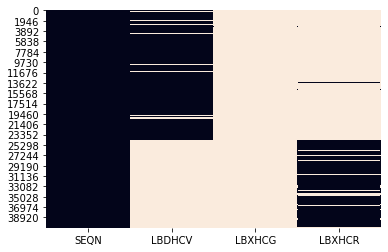

In [1065]:
# Look at null values in the dataframe. 
sns.heatmap(labs12_all.isnull(), cbar=False)

In [1066]:
# LBXHCG only contains data if a person is HepC +. Not unusual that is is sparsely populated. 
# HepC testing was changed in 2013 - switched primarily to a new test.  
# NHANES doc says this - "the confirmatory test for the Hepatitis C screening test (LBDHCV) was discontinued by the 
#     manufacturer, so a confirmed Hepatitis C antibody (Anti-HCV) will be retested by another confirmatory test and 
#     released at a later date"

In [1067]:
# Determine columns not in all 10 years of data.  
drop_column_list = changed_columns("HEPC_")
drop_column_list

['LBDHCV']

In [1068]:
# Drop columns not present in all 10 years. 
labs12_all = labs12_all.drop(drop_column_list, axis=1)
labs12_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 3 columns):
SEQN      40856 non-null int32
LBXHCG    335 non-null float64
LBXHCR    15027 non-null float64
dtypes: float64(2), int32(1)
memory usage: 798.0 KB


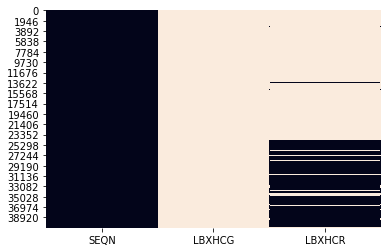

In [1069]:
# Recheck missing data. 
sns.heatmap(labs12_all.isnull(), cbar=False)

In [1070]:
labs12_all.describe()

,SEQN,LBXHCG,LBXHCR
count,40856.000000,335.00000,15027.000000
mean,67447.719233,1.99403,2.939509
std,15281.419043,1.69888,0.318682
min,41475.000000,1.00000,1.000000
25%,54150.750000,1.00000,3.000000
50%,66788.500000,1.00000,3.000000
75%,81072.250000,2.00000,3.000000
max,93702.000000,9.00000,3.000000


**13. Herpes Simplex Virus Type 1 & Type 2**

In [1071]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs13_dtype_dict = {"SEQN": int}
labs13_all = read_nhanes_data(labs13_dtype_dict, "HSV_", False)
labs13_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19093 entries, 0 to 19092
Data columns (total 3 columns):
SEQN      19093 non-null int32
LBXHE1    17569 non-null float64
LBXHE2    14657 non-null float64
dtypes: float64(2), int32(1)
memory usage: 373.0 KB


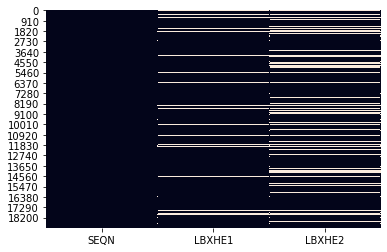

In [1072]:
# Look at null values in the dataframe. 
sns.heatmap(labs13_all.isnull(), cbar=False)

In [1073]:
labs13_all.describe()

,SEQN,LBXHE1,LBXHE2
count,19093.000000,17569.000000,14657.000000
mean,67506.069135,1.433662,1.814901
std,15196.415476,0.498000,0.395183
min,41481.000000,1.000000,1.000000
25%,54396.000000,1.000000,2.000000
50%,66819.000000,1.000000,2.000000
75%,80990.000000,2.000000,2.000000
max,93702.000000,3.000000,3.000000


**14. Glycohemoglobin**

In [1074]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs14_dtype_dict = {"SEQN": int}
labs14_all = read_nhanes_data(labs14_dtype_dict, "GHB_", False)
labs14_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 2 columns):
SEQN     34558 non-null int32
LBXGH    32471 non-null float64
dtypes: float64(1), int32(1)
memory usage: 405.1 KB


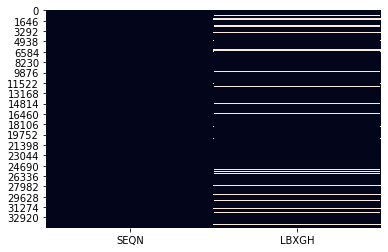

In [1075]:
# Look at null values in the dataframe. 
sns.heatmap(labs14_all.isnull(), cbar=False)

In [1076]:
# Note: The American Diabetes Association cutoff for diagnosing Prediabetes is 5.7% HbA1c. The mean value in this
# 10 year sample is 5.684%, nearly equal to the threshold for diagnosing prediabetes! 
labs14_all.describe()

,SEQN,LBXGH
count,34558.000000,32471.000000
mean,67356.969587,5.684140
std,15279.686150,1.030038
min,41475.000000,2.000000
25%,54085.250000,5.200000
50%,66671.500000,5.500000
75%,80967.750000,5.800000
max,93702.000000,17.800000


**15. HIV Antibody Test**

In [1077]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs15_dtype_dict = {"SEQN": int}
labs15_all = read_nhanes_data(labs15_dtype_dict, "HIV_", True)
labs15_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19407 entries, 0 to 19406
Data columns (total 6 columns):
LBDHI      14378 non-null float64
LBXHIV1    17 non-null float64
LBXHIV2    17 non-null float64
LBXHIVC    3661 non-null float64
LBXHNAT    2 non-null float64
SEQN       19407 non-null int32
dtypes: float64(5), int32(1)
memory usage: 834.0 KB


In [1078]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs15_all = move_columns(['SEQN'], labs15_all)
labs15_all.columns

Index(['SEQN', 'LBDHI', 'LBXHIV1', 'LBXHIV2', 'LBXHIVC', 'LBXHNAT'], dtype='object')

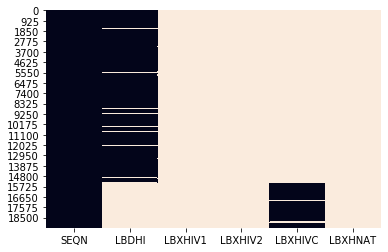

In [1079]:
# Look at null values in the dataframe. 
sns.heatmap(labs15_all.isnull(), cbar=False)

In [1080]:
# HIV testing was changed in 2015 to a combo test that tests for 2 different antibodies. 

In [1081]:
# Determine columns not in all 10 years of data. All columns have changed over 10 years.  
drop_column_list = changed_columns("HIV_")
drop_column_list

['LBXHIV1', 'LBXHNAT', 'LBDHI', 'LBXHIVC', 'LBXHIV2']

In [1082]:
# Drop columns not present in all 10 years. => Nothing left but SEQN. 
labs15_all = labs15_all.drop(drop_column_list, axis=1)
labs15_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19407 entries, 0 to 19406
Data columns (total 1 columns):
SEQN    19407 non-null int32
dtypes: int32(1)
memory usage: 75.9 KB


**16. Insulin & Fasting Plasma Glucose**

In [1083]:
# Location of insulin changed in 2013 from GLU_ (with plasma fasting glucose) to separate file INS_. 
# Also, fasting times were included in INS_ in 2013-2014 and not in 2015-2016. Have to piece these files together one
#   survey cycle at a time. Start with 2015-2016. 
# Special processing - do not use read_nhanes_data. 
labs16_dtype_dict = {"SEQN": int}
labs16_glu_15 = pd.read_csv('nhanes 2015-2016/GLU_I.csv', dtype=labs16_dtype_dict)
labs16_ins_15 = pd.read_csv('nhanes 2015-2016/INS_I.csv', dtype=labs16_dtype_dict)
labs16_15 = pd.merge(labs16_glu_15, labs16_ins_15, on=['SEQN', 'WTSAF2YR'])
labs16_glu_15.info()
labs16_ins_15.info()
labs16_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3191 entries, 0 to 3190
Data columns (total 4 columns):
SEQN        3191 non-null int32
WTSAF2YR    3191 non-null float64
LBXGLU      2972 non-null float64
LBDGLUSI    2972 non-null float64
dtypes: float64(3), int32(1)
memory usage: 87.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3191 entries, 0 to 3190
Data columns (total 7 columns):
SEQN        3191 non-null int32
WTSAF2YR    3191 non-null float64
LBXIN       2921 non-null float64
LBDINSI     2921 non-null float64
LBDINLC     2921 non-null float64
PHAFSTHR    3135 non-null float64
PHAFSTMN    3135 non-null float64
dtypes: float64(6), int32(1)
memory usage: 162.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 0 to 3190
Data columns (total 9 columns):
SEQN        3191 non-null int32
WTSAF2YR    3191 non-null float64
LBXGLU      2972 non-null float64
LBDGLUSI    2972 non-null float64
LBXIN       2921 non-null float64
LBDINSI     2921 non-null float64
LBDINLC

In [1084]:
# Now 2013-2014.
labs16_glu_13 = pd.read_csv('nhanes 2013-2014/GLU_H.csv', dtype=labs16_dtype_dict)
labs16_ins_13 = pd.read_csv('nhanes 2013-2014/INS_H.csv', dtype=labs16_dtype_dict)
labs16_13 = pd.merge(labs16_glu_13, labs16_ins_13, on=['SEQN', 'WTSAF2YR', 'PHAFSTHR', 'PHAFSTMN'])
labs16_glu_13.info()
labs16_ins_13.info()
labs16_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 6 columns):
SEQN        3329 non-null int32
WTSAF2YR    3329 non-null float64
LBXGLU      3172 non-null float64
LBDGLUSI    3172 non-null float64
PHAFSTHR    3291 non-null float64
PHAFSTMN    3291 non-null float64
dtypes: float64(5), int32(1)
memory usage: 143.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 6 columns):
SEQN        3329 non-null int32
WTSAF2YR    3329 non-null float64
LBXIN       3093 non-null float64
LBDINSI     3093 non-null float64
PHAFSTHR    3291 non-null float64
PHAFSTMN    3291 non-null float64
dtypes: float64(5), int32(1)
memory usage: 143.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3328
Data columns (total 8 columns):
SEQN        3329 non-null int32
WTSAF2YR    3329 non-null float64
LBXGLU      3172 non-null float64
LBDGLUSI    3172 non-null float64
PHAFSTHR    3291 non-null float64
PHAFST

In [1085]:
# Now read in remaining three cycles as they appear to be consistent in format. 
#   Then concatenate the five cycles into one dataframe.                        
labs16a_files = ['nhanes 2007-2008/GLU_E.csv', 'nhanes 2009-2010/GLU_F.csv', 'nhanes 2011-2012/GLU_G.csv']
labs16a_all = pd.concat((pd.read_csv(f, dtype=labs16_dtype_dict) for f in labs16a_files), ignore_index=True)
labs16_all = pd.concat([labs16a_all, labs16_13, labs16_15], ignore_index=True, sort=True)
labs16a_all.info()
labs16_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10135 entries, 0 to 10134
Data columns (total 8 columns):
SEQN        10135 non-null int32
WTSAF2YR    10135 non-null float64
LBXGLU      9529 non-null float64
LBDGLUSI    9529 non-null float64
LBXIN       9289 non-null float64
LBDINSI     9289 non-null float64
PHAFSTHR    9925 non-null float64
PHAFSTMN    9925 non-null float64
dtypes: float64(7), int32(1)
memory usage: 593.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 9 columns):
LBDGLUSI    15673 non-null float64
LBDINLC     2921 non-null float64
LBDINSI     15303 non-null float64
LBXGLU      15673 non-null float64
LBXIN       15303 non-null float64
PHAFSTHR    16351 non-null float64
PHAFSTMN    16351 non-null float64
SEQN        16655 non-null int32
WTSAF2YR    16655 non-null float64
dtypes: float64(8), int32(1)
memory usage: 1.1 MB


In [1086]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs16_all = move_columns(['SEQN', 'WTSAF2YR'], labs16_all)
labs16_all.columns

Index(['SEQN', 'WTSAF2YR', 'LBDGLUSI', 'LBDINLC', 'LBDINSI', 'LBXGLU', 'LBXIN',
       'PHAFSTHR', 'PHAFSTMN'],
      dtype='object')

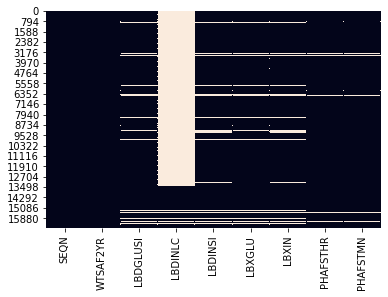

In [1087]:
# Look at null values in the dataframe. 
sns.heatmap(labs16_all.isnull(), cbar=False)

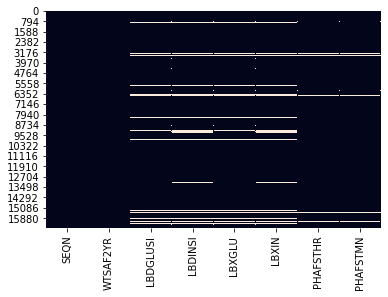

In [1088]:
# Drop column LBDINLC as it has data for only two years. 
labs16_all = labs16_all.drop('LBDINLC', axis=1)
sns.heatmap(labs16_all.isnull(), cbar=False)

In [1089]:
# The diagnostic threshold for plasma fasting glucose for prediabetes is 100 mg/dL. The mean of this 10 year 
# sample is 107.128!
labs16_all.describe()

,SEQN,WTSAF2YR,LBDGLUSI,LBDINSI,LBXGLU,LBXIN,PHAFSTHR,PHAFSTMN
count,16655.000000,16655.000000,15673.000000,15303.000000,15673.000000,15303.000000,16351.000000,16351.000000
mean,67277.762534,77411.372067,5.946504,85.246827,107.128374,14.207804,10.966608,29.719956
std,15207.220908,76787.701830,1.926870,100.490610,34.709356,16.748435,3.492988,17.308796
min,41479.000000,0.000000,1.170000,0.840000,21.000000,0.140000,0.000000,0.000000
25%,54290.500000,29792.025500,5.107000,39.120000,92.000000,6.520000,10.000000,14.000000
50%,66460.000000,52879.102000,5.495000,61.740000,99.000000,10.290000,11.000000,31.000000
75%,80782.000000,93276.033344,6.000000,99.660000,108.000000,16.610000,13.000000,44.000000
max,93697.000000,521632.185830,32.418000,4094.880000,584.000000,682.480000,40.000000,59.000000


**17. Iodine – Urine**

In [1090]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs17_dtype_dict = {"SEQN": int}
labs17_all = read_nhanes_data(labs17_dtype_dict, "UIO_", True)
labs17_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19701 entries, 0 to 19700
Data columns (total 5 columns):
SEQN        19701 non-null int32
URDUIOLC    3079 non-null float64
URXUCR      15962 non-null float64
URXUIO      18622 non-null float64
WTSA2YR     11526 non-null float64
dtypes: float64(4), int32(1)
memory usage: 692.7 KB


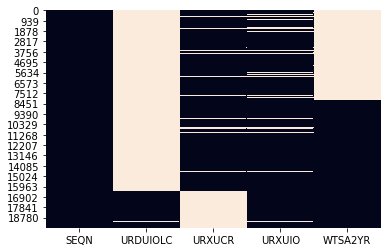

In [1091]:
# Look at null data. 
sns.heatmap(labs17_all.isnull(), cbar=False)

In [1092]:
# Drop columns URDUIOLC (comment code added in 2015), URXUCR (Creatinine, duplicated in many files), 
#    and WTSA2YR (also duplicated in many files). 
labs17_all = labs17_all.drop(['URDUIOLC', 'URXUCR', 'WTSA2YR'], axis=1)

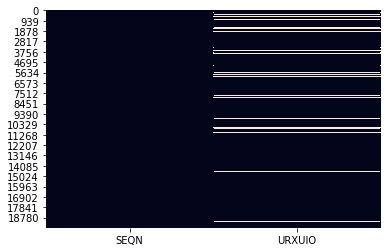

In [1093]:
# Recheck missing data. 
sns.heatmap(labs17_all.isnull(), cbar=False)

In [1094]:
labs17_all.describe()

,SEQN,URXUIO
count,19701.000000,18622.000000
mean,62301.628699,322.625507
std,16475.556883,5848.814361
min,41475.000000,2.100000
25%,47624.000000,84.200000
50%,57824.000000,149.200000
75%,77620.000000,261.300000
max,93693.000000,762010.000000


**18. Cholesterol – LDL & Triglycerides**

In [1095]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs18_dtype_dict = {"SEQN": int}
labs18_all = read_nhanes_data(labs18_dtype_dict, "TRIGLY_", False)
labs18_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 6 columns):
SEQN        16655 non-null int32
WTSAF2YR    16655 non-null float64
LBXTR       15315 non-null float64
LBDTRSI     15315 non-null float64
LBDLDL      15089 non-null float64
LBDLDLSI    15089 non-null float64
dtypes: float64(5), int32(1)
memory usage: 715.7 KB


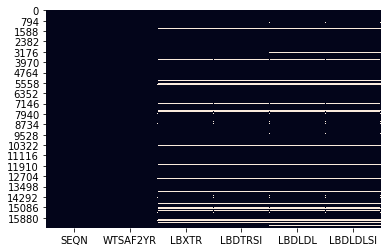

In [1096]:
# Look at null data. 
sns.heatmap(labs18_all.isnull(), cbar=False)

In [1097]:
labs18_all.describe()

,SEQN,WTSAF2YR,LBXTR,LBDTRSI,LBDLDL,LBDLDLSI
count,16655.000000,16655.000000,15315.000000,15315.000000,15089.000000,15089.000000
mean,67277.762534,77411.372067,118.977342,1.343259,109.093379,2.821166
std,15207.220908,76787.701830,104.639474,1.181379,35.403691,0.915540
min,41479.000000,0.000000,12.000000,0.135000,9.000000,0.233000
25%,54290.500000,29792.025500,65.000000,0.734000,84.000000,2.172000
50%,66460.000000,52879.102000,95.000000,1.073000,106.000000,2.741000
75%,80782.000000,93276.033344,143.000000,1.614000,131.000000,3.388000
max,93697.000000,521632.185830,4233.000000,47.791000,375.000000,9.698000


**19. Mercury: Inorganic, Ethyl and Methyl – Blood**

In [1098]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs19_dtype_dict = {"SEQN": int}
labs19a_all = read_nhanes_data(labs19_dtype_dict, "IHGEM_", True)
labs19b_all = read_nhanes_data(labs19_dtype_dict, "IHG_", False)
labs19_all = pd.concat([labs19a_all, labs19b_all], ignore_index=True, sort=True)
labs19_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39845 entries, 0 to 39844
Data columns (total 9 columns):
LBDBGELC    17952 non-null float64
LBDBGMLC    17954 non-null float64
LBDIHGLC    34849 non-null float64
LBDIHGSI    34849 non-null float64
LBXBGE      17952 non-null float64
LBXBGM      17954 non-null float64
LBXIHG      34849 non-null float64
SEQN        39845 non-null int32
WTSH2YR     11747 non-null float64
dtypes: float64(8), int32(1)
memory usage: 2.6 MB


In [1099]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs19_all = move_columns(['SEQN', 'WTSH2YR'], labs19_all)
labs19_all.columns

Index(['SEQN', 'WTSH2YR', 'LBDBGELC', 'LBDBGMLC', 'LBDIHGLC', 'LBDIHGSI',
       'LBXBGE', 'LBXBGM', 'LBXIHG'],
      dtype='object')

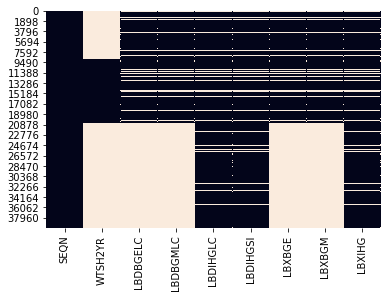

In [1100]:
# Look at null data. 
sns.heatmap(labs19_all.isnull(), cbar=False)

In [1101]:
# Determine columns not in all of first group of files. 
drop_column_list_1 = changed_columns("IHGEM_")
drop_column_list_1

['WTSH2YR']

In [1102]:
# Determine columns not in all of second group of files. 
drop_column_list_2 = changed_columns("IHG_")
drop_column_list_2

[]

In [1103]:
# Find columns between IHGEM_ and IHG_ - special case as file names change. 
n9_columns = pd.read_csv('nhanes 2009-2010/IHG_F.csv', nrows=0).columns.tolist()
n11_columns = pd.read_csv('nhanes 2011-2012/IHGEM_G.csv', nrows=0).columns.tolist()
diff_9_11 = list((set(n9_columns) | set(n11_columns)) - (set(n9_columns) & set(n11_columns)))
drop_column_list = drop_column_list_1 + drop_column_list_2 + diff_9_11
drop_column_list

['WTSH2YR', 'LBDBGMLC', 'LBXBGE', 'LBXBGM', 'LBDBGELC']

In [1104]:
# Drop columns that do not span all 10 years of data. 
labs19_all = labs19_all.drop(drop_column_list, axis=1)

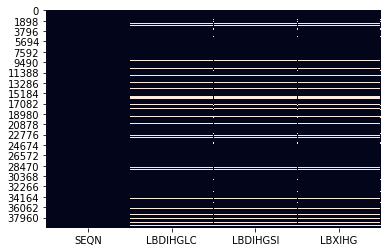

In [1105]:
# Recheck missing data. 
sns.heatmap(labs19_all.isnull(), cbar=False)

In [1106]:
labs19_all.describe()

,SEQN,LBDIHGLC,LBDIHGSI,LBXIHG
count,39845.000000,34849.000000,34849.000000,34849.000000
mean,64631.158941,0.818646,1.389142,0.277968
std,14658.313623,0.385317,1.777498,0.356264
min,41475.000000,0.000000,0.950000,0.190000
25%,52311.000000,1.000000,0.950000,0.190000
50%,63020.000000,1.000000,1.250000,0.250000
75%,76579.000000,1.000000,1.250000,0.250000
max,93701.000000,1.000000,209.580000,42.000000


**20. Oral Glucose tolerance Test**

In [1107]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs20_dtype_dict = {"SEQN": int}
labs20_all = read_nhanes_data(labs20_dtype_dict, "OGTT_", True)
labs20_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 12 columns):
GTDBL2MN    11549 non-null float64
GTDCODE     14915 non-null float64
GTDDR1MN    11766 non-null float64
GTDDR2MN    11549 non-null float64
GTDSCMMN    11766 non-null float64
GTXDRANK    12294 non-null float64
LBDGLTSI    11523 non-null float64
LBXGLT      11523 non-null float64
PHAFSTHR    12110 non-null float64
PHAFSTMN    12110 non-null float64
SEQN        14915 non-null int32
WTSOG2YR    14379 non-null float64
dtypes: float64(11), int32(1)
memory usage: 1.3 MB


In [1108]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs20_all = move_columns(['SEQN', 'WTSOG2YR'], labs20_all)
labs20_all.columns

Index(['SEQN', 'WTSOG2YR', 'GTDBL2MN', 'GTDCODE', 'GTDDR1MN', 'GTDDR2MN',
       'GTDSCMMN', 'GTXDRANK', 'LBDGLTSI', 'LBXGLT', 'PHAFSTHR', 'PHAFSTMN'],
      dtype='object')

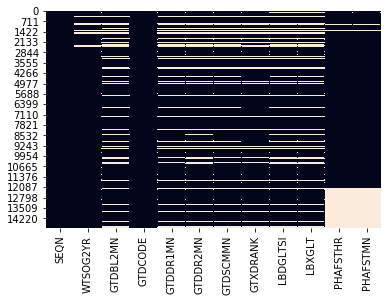

In [1109]:
# Look at null data. 
sns.heatmap(labs20_all.isnull(), cbar=False)

In [1110]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("OGTT_")
drop_column_list

['PHAFSTMN', 'PHAFSTHR']

In [1111]:
# Drop columns that do not span all 10 years. 
labs20_all = labs20_all.drop(drop_column_list, axis=1)

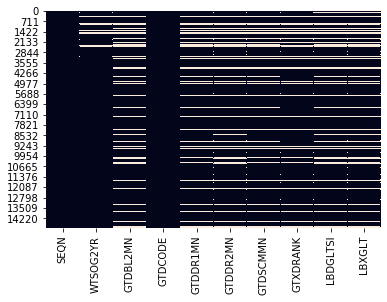

In [1112]:
# Recheck missing data. 
sns.heatmap(labs20_all.isnull(), cbar=False)

In [1113]:
labs20_all.describe()

,SEQN,WTSOG2YR,GTDBL2MN,GTDCODE,GTDDR1MN,GTDDR2MN,GTDSCMMN,GTXDRANK,LBDGLTSI,LBXGLT
count,14915.000000,14379.000000,11549.000000,14915.000000,11766.000000,11549.000000,11766.000000,12294.000000,11523.000000,11523.000000
mean,66550.784043,89664.538683,118.335613,5.799128,7.104708,111.277167,2.281999,1.096226,6.519086,117.440771
std,15336.185206,85355.350982,7.724826,10.819481,4.811862,6.811529,2.034223,0.425262,2.760443,49.732016
min,41479.000000,0.000000,7.000000,0.000000,0.000000,40.000000,0.000000,1.000000,1.277000,23.000000
25%,53060.500000,35704.190000,113.000000,0.000000,5.000000,108.000000,1.000000,1.000000,4.830000,87.000000
50%,65553.000000,61215.468254,117.000000,0.000000,6.000000,110.000000,2.000000,1.000000,5.884000,106.000000
75%,80251.500000,109142.738863,122.000000,0.000000,8.000000,115.000000,3.000000,1.000000,7.383000,133.000000
max,93697.000000,565085.973000,206.000000,30.000000,103.000000,145.000000,53.000000,3.000000,33.528000,604.000000


**21. Perfluoroalkyl and Pollyfluoroalkyl Substances (formerly Polyfluoroalkyl Chemicals – PFC)**

In [1114]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs21_dtype_dict = {"SEQN": int}
labs21a_all = read_nhanes_data(labs21_dtype_dict, "PFC_", True)
labs21b_all = read_nhanes_data(labs21_dtype_dict, "PFAS_", True)
labs21_all = pd.concat([labs21a_all, labs21b_all], ignore_index=True, sort=True)
labs21_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11412 entries, 0 to 11411
Data columns (total 36 columns):
LBDBFOAL    1993 non-null float64
LBDEPAHL    6237 non-null float64
LBDMFOSL    1993 non-null float64
LBDMPAHL    10398 non-null float64
LBDNFOAL    1993 non-null float64
LBDNFOSL    1993 non-null float64
LBDPFBSL    8405 non-null float64
LBDPFDEL    10398 non-null float64
LBDPFDOL    10398 non-null float64
LBDPFHPL    8405 non-null float64
LBDPFHSL    10398 non-null float64
LBDPFNAL    10398 non-null float64
LBDPFOAL    6237 non-null float64
LBDPFOSL    6237 non-null float64
LBDPFSAL    6237 non-null float64
LBDPFUAL    10398 non-null float64
LBXBFOA     1993 non-null float64
LBXEPAH     6237 non-null float64
LBXMFOS     1993 non-null float64
LBXMPAH     10398 non-null float64
LBXNFOA     1993 non-null float64
LBXNFOS     1993 non-null float64
LBXPFBS     8405 non-null float64
LBXPFDE     10398 non-null float64
LBXPFDO     10398 non-null float64
LBXPFHP     8405 non-null float6

In [1115]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs21_all = move_columns(['SEQN', 'WTSA2YR', 'WTSB2YR', 'WTSC2YR'], labs21_all)
labs21_all.columns

Index(['SEQN', 'WTSA2YR', 'WTSB2YR', 'WTSC2YR', 'LBDBFOAL', 'LBDEPAHL',
       'LBDMFOSL', 'LBDMPAHL', 'LBDNFOAL', 'LBDNFOSL', 'LBDPFBSL', 'LBDPFDEL',
       'LBDPFDOL', 'LBDPFHPL', 'LBDPFHSL', 'LBDPFNAL', 'LBDPFOAL', 'LBDPFOSL',
       'LBDPFSAL', 'LBDPFUAL', 'LBXBFOA', 'LBXEPAH', 'LBXMFOS', 'LBXMPAH',
       'LBXNFOA', 'LBXNFOS', 'LBXPFBS', 'LBXPFDE', 'LBXPFDO', 'LBXPFHP',
       'LBXPFHS', 'LBXPFNA', 'LBXPFOA', 'LBXPFOS', 'LBXPFSA', 'LBXPFUA'],
      dtype='object')

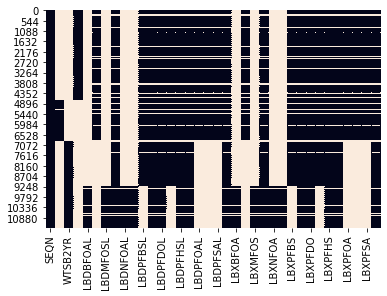

In [1116]:
# Look at null data. 
sns.heatmap(labs21_all.isnull(), cbar=False)

In [1117]:
# Determine columns not in all of first group of files. NOTE: Changed subsample categories for weighting. 
drop_column_list_1 = changed_columns("PFC_")
drop_column_list_1

['WTSA2YR', 'WTSC2YR']

In [1118]:
# Determine columns not in all of second group of files. 
drop_column_list_2 = changed_columns("PFAS_")
drop_column_list_2

['LBDBFOAL',
 'LBXPFBS',
 'LBXNFOA',
 'LBXNFOS',
 'LBXBFOA',
 'LBXMFOS',
 'LBDMFOSL',
 'LBDPFHPL',
 'LBXPFHP',
 'LBDNFOAL',
 'LBDPFBSL',
 'LBDNFOSL']

In [1119]:
# Find columns between PFC_ and PFAS_ - special case as file names change. 
n11_columns = pd.read_csv('nhanes 2011-2012/PFC_G.csv', nrows=0).columns.tolist()
n13_columns = pd.read_csv('nhanes 2013-2014/PFAS_H.csv', nrows=0).columns.tolist()
diff_11_13 = list((set(n11_columns) | set(n13_columns)) - (set(n11_columns) & set(n13_columns)))
drop_column_list = list(set(drop_column_list_1) | set(drop_column_list_2) | set(diff_11_13))
drop_column_list

['LBDBFOAL',
 'LBXPFBS',
 'LBXPFSA',
 'LBXNFOS',
 'LBDEPAHL',
 'LBXBFOA',
 'LBXPFOA',
 'LBDPFOAL',
 'LBDPFHPL',
 'LBDPFOSL',
 'LBDPFSAL',
 'LBXMFOS',
 'LBXNFOA',
 'WTSB2YR',
 'WTSC2YR',
 'LBDMFOSL',
 'LBXPFHP',
 'LBXPFOS',
 'LBXEPAH',
 'LBDNFOAL',
 'WTSA2YR',
 'LBDPFBSL',
 'LBDNFOSL']

In [1120]:
# Drop columns that do not span all 10 years of data. 
labs21_all = labs21_all.drop(drop_column_list, axis=1)

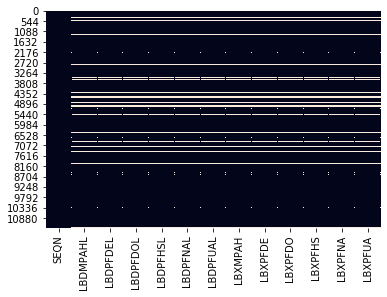

In [1121]:
# Recheck missing data. 
sns.heatmap(labs21_all.isnull(), cbar=False)

In [1122]:
labs21_all.describe()

,SEQN,LBDMPAHL,LBDPFDEL,LBDPFDOL,LBDPFHSL,LBDPFNAL,LBDPFUAL,LBXMPAH,LBXPFDE,LBXPFDO,LBXPFHS,LBXPFNA,LBXPFUA
count,11412.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.000000,10398.00000,10398.000000,10398.000000
mean,67266.945145,0.429890,0.211675,0.927390,0.011060,0.007790,0.512983,0.270796,0.327299,0.095105,2.16596,1.170117,0.237752
std,15239.982148,0.495084,0.408516,0.259508,0.104588,0.087921,0.499855,0.438007,0.756575,0.096574,2.89082,1.356265,0.989121
min,41475.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.070000,0.070000,0.07000,0.058000,0.070000
25%,54091.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.070000,0.100000,0.070000,0.80000,0.590000,0.070000
50%,66574.500000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.120000,0.200000,0.070000,1.40000,0.902000,0.140000
75%,80819.500000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.300000,0.370000,0.100000,2.50000,1.394000,0.200000
max,93700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.200000,51.300000,6.900000,81.60000,80.770000,77.400000


**22. Phthalates and Plasticizers Metabolites – Urine**

In [1123]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs22_dtype_dict = {"SEQN": int}
labs22_all = read_nhanes_data(labs22_dtype_dict, "PHTHTE_", True)
labs22_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14113 entries, 0 to 14112
Data columns (total 42 columns):
SEQN        14113 non-null int32
URDCNPLC    13502 non-null float64
URDCOPLC    13502 non-null float64
URDECPLC    13502 non-null float64
URDHIBLC    2975 non-null float64
URDMBPLC    13502 non-null float64
URDMC1LC    13502 non-null float64
URDMCHLC    8149 non-null float64
URDMCOLC    2975 non-null float64
URDMCPLC    5353 non-null float64
URDMEPLC    13502 non-null float64
URDMHBLC    2975 non-null float64
URDMHHLC    13502 non-null float64
URDMHPLC    13502 non-null float64
URDMIBLC    13502 non-null float64
URDMNMLC    7842 non-null float64
URDMNPLC    13502 non-null float64
URDMOHLC    13502 non-null float64
URDMOPLC    5353 non-null float64
URDMZPLC    13502 non-null float64
URXCNP      13502 non-null float64
URXCOP      13502 non-null float64
URXECP      13502 non-null float64
URXHIBP     2975 non-null float64
URXMBP      13502 non-null float64
URXMC1      13502 non-null

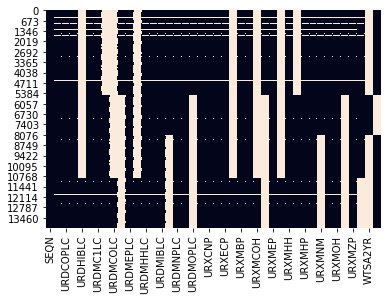

In [1124]:
# Look at null data. 
sns.heatmap(labs22_all.isnull(), cbar=False)

In [1125]:
# Determine columns not in all 10 years of data. NOTE: Changed subsample categories for weighting. 
drop_column_list = changed_columns("PHTHTE_")
drop_column_list

['URDMCOLC',
 'URDMCPLC',
 'URXUCR',
 'URDMCHLC',
 'URXHIBP',
 'URXMCP',
 'WTSB2YR',
 'URXMOP',
 'URXMNM',
 'URDMOPLC',
 'URDMHBLC',
 'URXMCOH',
 'URXMHNC',
 'URDHIBLC',
 'WTSA2YR',
 'URDMNMLC',
 'URXMHBP']

In [1126]:
# Drop columns that do not span all 10 years of data. 
labs22_all = labs22_all.drop(drop_column_list, axis=1)

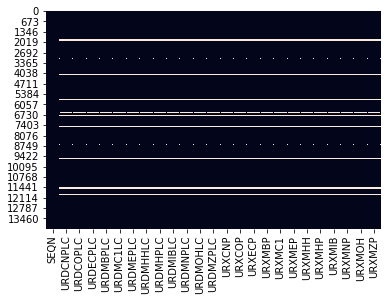

In [1127]:
# Recheck missing data. 
sns.heatmap(labs22_all.isnull(), cbar=False)

In [1128]:
labs22_all.describe()

,SEQN,URDCNPLC,URDCOPLC,URDECPLC,URDMBPLC,URDMC1LC,URDMEPLC,URDMHHLC,URDMHPLC,URDMIBLC,...,URXECP,URXMBP,URXMC1,URXMEP,URXMHH,URXMHP,URXMIB,URXMNP,URXMOH,URXMZP
count,14113.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,...,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000,13502.000000
mean,68293.654432,0.028959,0.008739,0.001629,0.017331,0.073545,0.001555,0.004518,0.312917,0.014442,...,38.704942,36.298948,6.812904,232.992071,27.300407,4.143223,15.289756,2.846158,15.953542,14.866710
std,15574.272761,0.167697,0.093079,0.040334,0.130505,0.261038,0.039408,0.067065,0.560067,0.119310,...,172.837205,901.183416,43.285575,943.343824,121.832013,21.737474,30.290891,13.115011,72.037739,34.311043
min,41476.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.140000,0.280000,0.140000,0.420000,0.140000,0.350000,0.140000,0.350000,0.140000,0.150000
25%,54481.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.000000,6.500000,1.000000,18.700000,4.712500,0.570000,4.200000,0.640000,3.090000,2.500000
50%,67841.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.300000,14.165000,2.240000,47.425000,10.300000,1.500000,8.920000,0.800000,6.500000,6.175000
75%,82617.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,33.667500,28.400000,5.000000,141.825500,21.900000,3.300000,17.427500,1.300000,13.445000,15.100000
max,93700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,37.000000,1.000000,...,15828.000000,101013.000000,2597.300000,31660.000000,9326.100000,1252.700000,1384.800000,875.400000,6079.900000,1525.100000


**23. Cholesterol – Total**

In [1129]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs23_dtype_dict = {"SEQN": int}
labs23_all = read_nhanes_data(labs23_dtype_dict, "TCHOL_", False)
labs23_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 3 columns):
SEQN       40856 non-null int32
LBXTC      37101 non-null float64
LBDTCSI    37101 non-null float64
dtypes: float64(2), int32(1)
memory usage: 798.0 KB


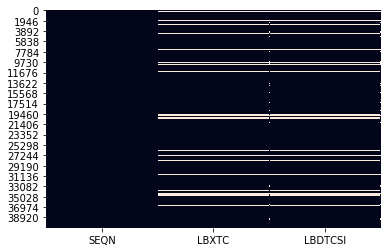

In [1130]:
# Look at null data. 
sns.heatmap(labs23_all.isnull(), cbar=False)

In [1131]:
labs23_all.describe()

,SEQN,LBXTC,LBDTCSI
count,40856.000000,37101.000000,37101.000000
mean,67447.719233,183.079135,4.734436
std,15281.419043,41.541976,1.074322
min,41475.000000,59.000000,1.530000
25%,54150.750000,153.000000,3.960000
50%,66788.500000,178.000000,4.600000
75%,81072.250000,208.000000,5.380000
max,93702.000000,813.000000,21.020000


**24. Lead, Cadmium, Total Mercury, Selenium, and Manganese – Blood**

In [1132]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs24_dtype_dict = {"SEQN": int}
labs24_all = read_nhanes_data(labs24_dtype_dict, "PBCD_", True)
labs24_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39845 entries, 0 to 39844
Data columns (total 17 columns):
LBDBCDLC    26916 non-null float64
LBDBCDSI    35182 non-null float64
LBDBMNLC    18122 non-null float64
LBDBMNSI    18122 non-null float64
LBDBPBLC    26916 non-null float64
LBDBPBSI    35182 non-null float64
LBDBSELC    18122 non-null float64
LBDBSESI    18122 non-null float64
LBDTHGLC    35182 non-null float64
LBDTHGSI    35182 non-null float64
LBXBCD      35182 non-null float64
LBXBMN      18122 non-null float64
LBXBPB      35182 non-null float64
LBXBSE      18122 non-null float64
LBXTHG      35182 non-null float64
SEQN        39845 non-null int32
WTSH2YR     11747 non-null float64
dtypes: float64(16), int32(1)
memory usage: 5.0 MB


In [1133]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs24_all = move_columns(['SEQN', 'WTSH2YR'], labs24_all)
labs24_all.columns

Index(['SEQN', 'WTSH2YR', 'LBDBCDLC', 'LBDBCDSI', 'LBDBMNLC', 'LBDBMNSI',
       'LBDBPBLC', 'LBDBPBSI', 'LBDBSELC', 'LBDBSESI', 'LBDTHGLC', 'LBDTHGSI',
       'LBXBCD', 'LBXBMN', 'LBXBPB', 'LBXBSE', 'LBXTHG'],
      dtype='object')

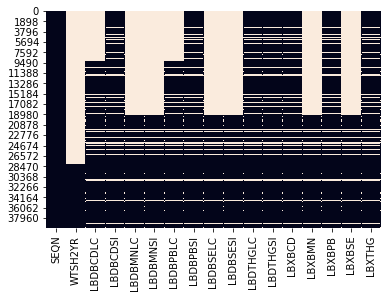

In [1134]:
# Look at null data. 
sns.heatmap(labs24_all.isnull(), cbar=False)

In [1135]:
# Determine columns not in all 10 years of data. NOTE: Changed subsample categories for weighting. 
drop_column_list = changed_columns("PBCD_")
drop_column_list

['LBDBSESI',
 'LBDBSELC',
 'WTSH2YR',
 'LBDBCDLC',
 'LBXBMN',
 'LBDBMNSI',
 'LBDBMNLC',
 'LBDBPBLC',
 'LBXBSE']

In [1136]:
# Drop columns that do not span all 10 years of data. 
labs24_all = labs24_all.drop(drop_column_list, axis=1)

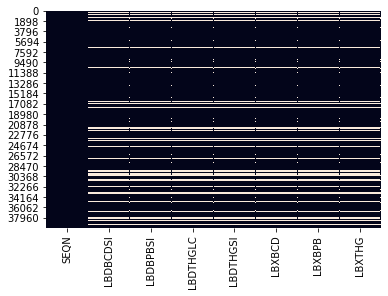

In [1137]:
# Recheck missing data. 
sns.heatmap(labs24_all.isnull(), cbar=False)

In [1138]:
labs24_all.describe()

,SEQN,LBDBCDSI,LBDBPBSI,LBDTHGLC,LBDTHGSI,LBXBCD,LBXBPB,LBXTHG
count,39845.000000,35182.000000,35182.000000,35182.000000,35182.000000,35182.000000,35182.000000,35182.000000
mean,64631.158941,3.434203,0.066904,0.201268,6.035129,0.385909,1.385208,1.212215
std,14658.313623,4.521335,0.073138,0.400953,10.726609,0.508225,1.514199,2.148595
min,41475.000000,0.620000,0.002000,0.000000,0.500000,0.070000,0.050000,0.110000
25%,52311.000000,1.250000,0.030000,0.000000,1.500000,0.140000,0.630000,0.300000
50%,63020.000000,1.960000,0.048000,0.000000,3.000000,0.220000,1.000000,0.600000
75%,76579.000000,3.740000,0.079000,0.000000,6.200000,0.420000,1.640000,1.250000
max,93701.000000,82.740000,2.960000,1.000000,427.600000,9.300000,61.290000,85.700000


**25. Arsenics – Speciated – Urine, and Arsenic - Total - Urine**

In [1139]:
# Location of total urinary arsenic changed in 2013 from UAS_ to separate file UTAS_. 
# Have to piece these files together. Start with 2015-2016. 
# Special processing - do not use read_nhanes_data(). 
labs25_dtype_dict = {"SEQN": int}
labs25_urxuas_15 = pd.read_csv('nhanes 2015-2016/UTAS_I.csv', dtype=labs25_dtype_dict)
labs25_uas_15 = pd.read_csv('nhanes 2015-2016/UAS_I.csv', dtype=labs25_dtype_dict)
labs25_15 = pd.merge(labs25_urxuas_15, labs25_uas_15, on=['SEQN', 'WTSA2YR'])
labs25_urxuas_15.info()
labs25_uas_15.info()
labs25_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 3 columns):
SEQN       3279 non-null int32
WTSA2YR    3279 non-null float64
URXUAS     3061 non-null float64
dtypes: float64(2), int32(1)
memory usage: 64.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 14 columns):
SEQN        3279 non-null int32
WTSA2YR     3279 non-null float64
URXUAS3     3094 non-null float64
URDUA3LC    3094 non-null float64
URXUAS5     3094 non-null float64
URDUA5LC    3094 non-null float64
URXUAB      3094 non-null float64
URDUABLC    3094 non-null float64
URXUAC      3094 non-null float64
URDUACLC    3094 non-null float64
URXUDMA     3094 non-null float64
URDUDALC    3094 non-null float64
URXUMMA     3094 non-null float64
URDUMMAL    3094 non-null float64
dtypes: float64(13), int32(1)
memory usage: 345.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 3278
Data columns (total 15 columns):
SEQN 

In [1140]:
# Next, 2013-2014
labs25_urxuas_13 = pd.read_csv('nhanes 2013-2014/UTAS_H.csv', dtype=labs25_dtype_dict)
labs25_uas_13 = pd.read_csv('nhanes 2013-2014/UAS_H.csv', dtype=labs25_dtype_dict)
labs25_13 = pd.merge(labs25_urxuas_13, labs25_uas_13, on=['SEQN', 'WTSA2YR', 'URXUCR'])
labs25_urxuas_13.info()
labs25_uas_13.info()
labs25_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 4 columns):
SEQN       2755 non-null int32
WTSA2YR    2755 non-null float64
URXUAS     2662 non-null float64
URXUCR     2681 non-null float64
dtypes: float64(3), int32(1)
memory usage: 75.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 15 columns):
SEQN        2755 non-null int32
WTSA2YR     2755 non-null float64
URXUCR      2681 non-null float64
URXUAS3     2654 non-null float64
URDUA3LC    2654 non-null float64
URXUAS5     2654 non-null float64
URDUA5LC    2654 non-null float64
URXUAB      2654 non-null float64
URDUABLC    2654 non-null float64
URXUAC      2654 non-null float64
URDUACLC    2654 non-null float64
URXUDMA     2654 non-null float64
URDUDALC    2654 non-null float64
URXUMMA     2654 non-null float64
URDUMMAL    2654 non-null float64
dtypes: float64(14), int32(1)
memory usage: 312.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64In

In [1141]:
# Now read in remaining three cycles as they appear to be consistent in format. 
#   Then concatenate the five cycles into one dataframe.                       
labs25a_files = ['nhanes 2007-2008/UAS_E.csv', 'nhanes 2009-2010/UAS_F.csv', 'nhanes 2011-2012/UAS_G.csv']
labs25a_all = pd.concat((pd.read_csv(f, dtype=labs25_dtype_dict) for f in labs25a_files), ignore_index=True)
labs25_all = pd.concat([labs25a_all, labs25_13, labs25_15], ignore_index=True, sort=True)
labs25a_all.info()
labs25_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8255 entries, 0 to 8254
Data columns (total 19 columns):
SEQN        8255 non-null int32
WTSA2YR     8212 non-null float64
URXUCR      8060 non-null float64
URXUAS      7969 non-null float64
URDUASLC    7969 non-null float64
URXUAS3     7964 non-null float64
URDUA3LC    7964 non-null float64
URXUAS5     7945 non-null float64
URDUA5LC    7945 non-null float64
URXUAB      7963 non-null float64
URDUABLC    7963 non-null float64
URXUAC      7964 non-null float64
URDUACLC    7964 non-null float64
URXUDMA     7964 non-null float64
URDUDALC    7964 non-null float64
URXUMMA     7964 non-null float64
URDUMMAL    7964 non-null float64
URXUTM      7964 non-null float64
URDUTMLC    7964 non-null float64
dtypes: float64(18), int32(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 19 columns):
SEQN        14289 non-null int32
URDUA3LC    13712 non-null float64
URDUA5LC    13693 non

In [1142]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs25_all = move_columns(['SEQN', 'WTSA2YR', 'URXUCR'], labs25_all)
labs25_all.columns

Index(['SEQN', 'WTSA2YR', 'URXUCR', 'URDUA3LC', 'URDUA5LC', 'URDUABLC',
       'URDUACLC', 'URDUASLC', 'URDUDALC', 'URDUMMAL', 'URDUTMLC', 'URXUAB',
       'URXUAC', 'URXUAS', 'URXUAS3', 'URXUAS5', 'URXUDMA', 'URXUMMA',
       'URXUTM'],
      dtype='object')

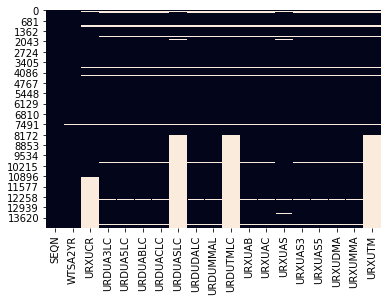

In [1143]:
# Look at null data. 
sns.heatmap(labs25_all.isnull(), cbar=False)

In [1144]:
# Determine columns not in all of first group of files. 
drop_column_list_1 = changed_columns("UAS_")
drop_column_list_1

['URXUCR', 'URXUAS', 'URXUTM', 'URDUTMLC', 'URDUASLC']

In [1145]:
# Determine columns not in all of second group of files. 
drop_column_list_2 = changed_columns("UTAS_")
drop_column_list_2

['URXUCR']

In [1146]:
# UTAS_ Adds back in URXUAS. Remove it from drop_column_list. 
drop_column_list = (drop_column_list_1 + drop_column_list_2)
drop_column_list.remove('URXUAS')
drop_column_list

['URXUCR', 'URXUTM', 'URDUTMLC', 'URDUASLC', 'URXUCR']

In [1147]:
# Drop columns that do not span all 10 years of data. 
labs25_all = labs25_all.drop(drop_column_list, axis=1)

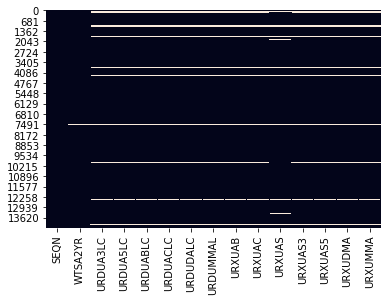

In [1148]:
# Recheck missing data. 
sns.heatmap(labs25_all.isnull(), cbar=False)

In [1149]:
labs25_all.describe()

,SEQN,WTSA2YR,URDUA3LC,URDUA5LC,URDUABLC,URDUACLC,URDUDALC,URDUMMAL,URXUAB,URXUAC,URXUAS,URXUAS3,URXUAS5,URXUDMA,URXUMMA
count,14289.000000,14246.000000,13712.000000,13693.000000,13711.000000,13712.000000,13712.000000,13712.000000,13711.000000,13712.000000,13692.000000,13712.000000,13693.000000,13712.000000,13712.000000
mean,68266.885716,99914.227583,0.664965,0.977434,0.510101,0.914673,0.213827,0.556739,8.752084,0.300910,17.119468,0.662130,0.665670,5.421777,0.804258
std,15539.978197,93729.459173,0.472020,0.148522,0.499916,0.279377,0.410021,0.496788,37.134466,1.189379,46.171968,1.528359,1.345262,7.831857,1.887112
min,41477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280000,0.080000,0.180000,0.080000,0.560000,1.200000,0.140000
25%,54689.000000,39855.457066,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.080000,3.610000,0.340000,0.560000,2.010000,0.530000
50%,67689.000000,64958.020618,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.840000,0.200000,6.850000,0.810000,0.620000,3.520000,0.640000
75%,82488.000000,120541.271275,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.300000,0.420000,14.320000,0.850000,0.710000,6.060000,0.920000
max,93693.000000,708844.246779,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1140.000000,107.000000,1269.000000,156.000000,148.000000,270.000000,177.000000


**26. Mercury – Urine**

In [1150]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs26_dtype_dict = {"SEQN": int}
labs26_all = read_nhanes_data(labs26_dtype_dict, "UHG_", True)
labs26_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 5 columns):
SEQN        14289 non-null int32
URDUHGLC    8253 non-null float64
URXUCR      10741 non-null float64
URXUHG      13752 non-null float64
WTSA2YR     14246 non-null float64
dtypes: float64(4), int32(1)
memory usage: 502.4 KB


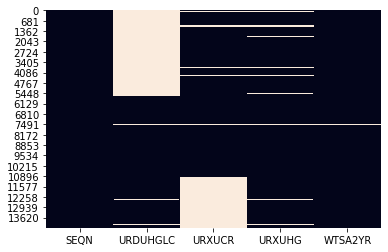

In [1151]:
# Look at null data. 
sns.heatmap(labs26_all.isnull(), cbar=False)

In [1152]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("UHG_")
drop_column_list

['URDUHGLC', 'URXUCR']

In [1153]:
# Drop columns that do not span all 10 years of data. 
labs26_all = labs26_all.drop(drop_column_list, axis=1)

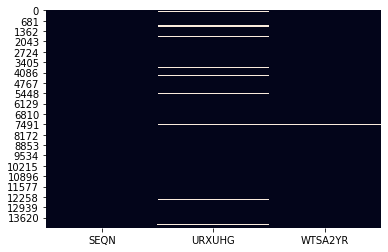

In [1154]:
# Recheck missing data. 
sns.heatmap(labs26_all.isnull(), cbar=False)

In [1155]:
labs26_all.describe()

,SEQN,URXUHG,WTSA2YR
count,14289.000000,13752.000000,14246.000000
mean,68266.885716,0.559945,99914.227583
std,15539.978197,1.392307,93729.459173
min,41477.000000,0.040000,0.000000
25%,54689.000000,0.090000,39855.457066
50%,67689.000000,0.260000,64958.020618
75%,82488.000000,0.600000,120541.271275
max,93693.000000,83.030000,708844.246779


**27. Metals – Urine**

In [1156]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs27_dtype_dict = {"SEQN": int}
labs27a_all = read_nhanes_data(labs27_dtype_dict, "UHM_", True)
labs27b_all = read_nhanes_data(labs27_dtype_dict, "UM_", True)
labs27_all = pd.concat([labs27a_all, labs27b_all], ignore_index=True, sort=True)
labs27_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 33 columns):
SEQN        14289 non-null int32
URDUBALC    13704 non-null float64
URDUBELC    5475 non-null float64
URDUCDLC    13704 non-null float64
URDUCOLC    13704 non-null float64
URDUCSLC    13703 non-null float64
URDUMNLC    8229 non-null float64
URDUMOLC    13703 non-null float64
URDUPBLC    13704 non-null float64
URDUPTLC    5474 non-null float64
URDUSBLC    13703 non-null float64
URDUSNLC    8228 non-null float64
URDUSRLC    8228 non-null float64
URDUTLLC    13704 non-null float64
URDUTULC    13689 non-null float64
URDUURLC    13704 non-null float64
URXUBA      13704 non-null float64
URXUBE      5475 non-null float64
URXUCD      13704 non-null float64
URXUCO      13704 non-null float64
URXUCR      10741 non-null float64
URXUCS      13703 non-null float64
URXUMN      8229 non-null float64
URXUMO      13703 non-null float64
URXUPB      13704 non-null float64
URXUPT      5474 non-null

In [1157]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
labs27_all = move_columns(['SEQN', 'WTSA2YR'], labs27_all)
labs27_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 33 columns):
SEQN        14289 non-null int32
WTSA2YR     14246 non-null float64
URDUBALC    13704 non-null float64
URDUBELC    5475 non-null float64
URDUCDLC    13704 non-null float64
URDUCOLC    13704 non-null float64
URDUCSLC    13703 non-null float64
URDUMNLC    8229 non-null float64
URDUMOLC    13703 non-null float64
URDUPBLC    13704 non-null float64
URDUPTLC    5474 non-null float64
URDUSBLC    13703 non-null float64
URDUSNLC    8228 non-null float64
URDUSRLC    8228 non-null float64
URDUTLLC    13704 non-null float64
URDUTULC    13689 non-null float64
URDUURLC    13704 non-null float64
URXUBA      13704 non-null float64
URXUBE      5475 non-null float64
URXUCD      13704 non-null float64
URXUCO      13704 non-null float64
URXUCR      10741 non-null float64
URXUCS      13703 non-null float64
URXUMN      8229 non-null float64
URXUMO      13703 non-null float64
URXUPB      13704 non-nul

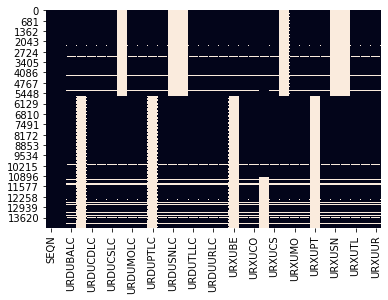

In [1158]:
# Look at null data. 
sns.heatmap(labs27_all.isnull(), cbar=False)

In [1159]:
# Determine columns not in all of first group of files. 
drop_column_list_1 = changed_columns("UHM_")
drop_column_list_1

['URDUPTLC',
 'URXUSN',
 'URXUMN',
 'URDUSRLC',
 'URXUSR',
 'URXUBE',
 'URDUMNLC',
 'URDUBELC',
 'URDUSNLC',
 'URXUPT']

In [1160]:
# Determine columns not in all of second group of files. 
drop_column_list_2 = changed_columns("UM_")
drop_column_list_2

['URXUCR']

In [1161]:
# Find column changes between UHM_ and UM_ - special case as file names change. 
n11_columns = pd.read_csv('nhanes 2011-2012/UHM_G.csv', nrows=0).columns.tolist()
n13_columns = pd.read_csv('nhanes 2013-2014/UM_H.csv', nrows=0).columns.tolist()
diff_11_13 = list((set(n11_columns) | set(n13_columns)) - (set(n11_columns) & set(n13_columns)))
drop_column_list = list(set(drop_column_list_1) | set(drop_column_list_2) | set(diff_11_13))
drop_column_list

['URDUPTLC',
 'URXUSN',
 'URXUMN',
 'URDUSRLC',
 'URXUSR',
 'URXUBE',
 'URDUMNLC',
 'URDUBELC',
 'URDUSNLC',
 'URXUPT',
 'URXUCR']

In [1162]:
# Drop columns that do not span all 10 years of data. 
labs27_all = labs27_all.drop(drop_column_list, axis=1)

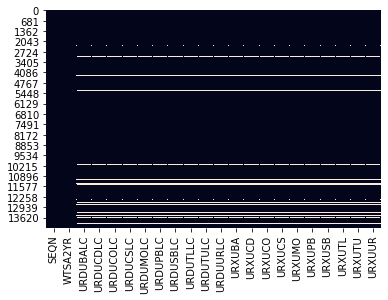

In [1163]:
# Recheck missing data. 
sns.heatmap(labs27_all.isnull(), cbar=False)

In [1164]:
labs27_all.describe()

,SEQN,WTSA2YR,URDUBALC,URDUCDLC,URDUCOLC,URDUCSLC,URDUMOLC,URDUPBLC,URDUSBLC,URDUTLLC,...,URXUBA,URXUCD,URXUCO,URXUCS,URXUMO,URXUPB,URXUSB,URXUTL,URXUTU,URXUUR
count,14289.000000,14246.000000,13704.000000,13704.000000,13704.000000,13703.000000,13703.000000,13704.000000,13703.000000,13704.000000,...,13704.000000,13704.000000,13704.000000,13703.000000,13703.000000,13704.000000,13703.000000,13704.000000,13689.000000,13704.000000
mean,68266.885716,99914.227583,0.005984,0.174621,0.003284,0.000073,0.000146,0.019848,0.243961,0.005254,...,1.997774,0.279785,0.561776,5.013406,61.508776,0.605995,0.085542,0.189696,0.161703,0.012301
std,15539.978197,93729.459173,0.077125,0.379656,0.057212,0.008543,0.012081,0.139484,0.429485,0.072296,...,4.747167,0.408704,1.116140,3.471369,57.569470,1.092702,0.213344,0.150285,0.538530,0.044458
min,41477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042000,0.025000,0.016000,0.061000,0.650000,0.020000,0.016000,0.011000,0.013000,0.001200
25%,54689.000000,39855.457066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.600000,0.059000,0.232000,2.687000,23.920000,0.210000,0.029000,0.096000,0.039000,0.003000
50%,67689.000000,64958.020618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.210000,0.146000,0.394000,4.440000,46.700000,0.400000,0.053000,0.161000,0.084000,0.005800
75%,82488.000000,120541.271275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.360000,0.332000,0.640000,6.580000,80.500000,0.710000,0.093000,0.250000,0.171000,0.011700
max,93693.000000,708844.246779,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,419.000000,8.350000,75.800000,110.873000,1200.000000,52.300000,14.291000,7.658000,33.070000,2.105000


**28. Pregnancy Test – Urine**

In [1165]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
labs28_dtype_dict = {"SEQN": int}
labs28_all = read_nhanes_data(labs28_dtype_dict, "UCPREG_", False)
labs28_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6226 entries, 0 to 6225
Data columns (total 2 columns):
SEQN       6226 non-null int32
URXPREG    6224 non-null float64
dtypes: float64(1), int32(1)
memory usage: 73.0 KB


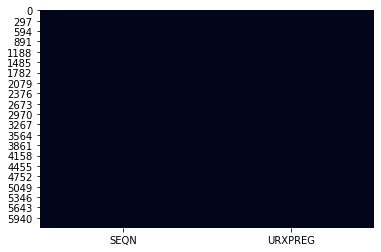

In [1166]:
# Look at null data. 
sns.heatmap(labs28_all.isnull(), cbar=False)

In [1167]:
labs28_all.describe()

,SEQN,URXPREG
count,6226.000000,6224.000000
mean,67578.670736,1.968830
std,15180.373382,0.257914
min,41485.000000,1.000000
25%,54366.500000,2.000000
50%,66802.500000,2.000000
75%,81080.250000,2.000000
max,93702.000000,3.000000


### Merge all labs data and write out csv file.

In [1168]:
# Albumin & Creatinine, Apolipoprotein B 
# Do we even want to merge in ApoB? There are only 15,313 observations. 
# Lab equipment change between 2014, 2015 means regression equations should be used to compare ApoB values
# from 2007-2014 to 2015-2016. See APOB documentation. 
labs_all = pd.merge(labs1_all, labs2_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41443 entries, 0 to 41442
Data columns (total 8 columns):
SEQN        41443 non-null int32
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
dtypes: float64(7), int32(1)
memory usage: 2.7 MB


In [1169]:
# Standard Biochemistry Profile 
labs_all = pd.merge(labs_all, labs3_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41443 entries, 0 to 41442
Data columns (total 44 columns):
SEQN        41443 non-null int32
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1170]:
# Complete Blood Count with 5-part Differential – Whole Blood
labs_all = pd.merge(labs_all, labs4_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 63 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1171]:
# Chlamydia – Urine 
labs_all = pd.merge(labs_all, labs5_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 64 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1172]:
# Personal Care and Consumer Product Chemicals and Metabolites
labs_all = pd.merge(labs_all, labs6_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 78 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1173]:
# Fasting Questionnaire 
labs_all = pd.merge(labs_all, labs7_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 96 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1174]:
# Cholesterol – HDL 
labs_all = pd.merge(labs_all, labs8_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 98 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1175]:
# Hepatitis A 
labs_all = pd.merge(labs_all, labs9_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 99 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018 

In [1176]:
# Hepatitis B Surface Antibody 
labs_all = pd.merge(labs_all, labs10_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Data columns (total 100 columns):
SEQN        46685 non-null int64
URXCRS      40244 non-null float64
URXUCR      40244 non-null float64
URXUMA      40244 non-null float64
URXUMS      40244 non-null float64
WTSAF2YR    16655 non-null float64
LBXAPB      15313 non-null float64
LBDAPBSI    15313 non-null float64
LBDSALSI    32022 non-null float64
LBDSBUSI    32018 non-null float64
LBDSCASI    31977 non-null float64
LBDSCHSI    32014 non-null float64
LBDSCRSI    32020 non-null float64
LBDSGBSI    31979 non-null float64
LBDSGLSI    32023 non-null float64
LBDSIRSI    31977 non-null float64
LBDSPHSI    32017 non-null float64
LBDSTBSI    31999 non-null float64
LBDSTPSI    31980 non-null float64
LBDSTRSI    32001 non-null float64
LBDSUASI    32013 non-null float64
LBXSAL      32022 non-null float64
LBXSAPSI    32016 non-null float64
LBXSASSI    32006 non-null float64
LBXSATSI    32010 non-null float64
LBXSBU      32018

In [1177]:
# Hepatitis B core antibody, surface antigen, and Hepatitis D antibody 
labs_all = pd.merge(labs_all, labs11_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 103 entries, SEQN to LBDHD
dtypes: float64(102), int64(1)
memory usage: 37.0 MB


In [1178]:
# Hepatitis C RNA and Hepatitis C genotype 
labs_all = pd.merge(labs_all, labs12_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 105 entries, SEQN to LBXHCR
dtypes: float64(104), int64(1)
memory usage: 37.8 MB


In [1179]:
# Herpes Simplex Virus Type 1 & Type 2 
labs_all = pd.merge(labs_all, labs13_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 107 entries, SEQN to LBXHE2
dtypes: float64(106), int64(1)
memory usage: 38.5 MB


In [1180]:
# Add glycohemoglobin to labs dataframe. 
labs_all = pd.merge(labs_all, labs14_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 108 entries, SEQN to LBXGH
dtypes: float64(107), int64(1)
memory usage: 38.8 MB


In [1181]:
# HIV Antibody Test 
labs_all = pd.merge(labs_all, labs15_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 108 entries, SEQN to LBXGH
dtypes: float64(107), int64(1)
memory usage: 38.8 MB


In [1182]:
# Insulin & Plasma Fasting Glucose
labs_all = pd.merge(labs_all, labs16_all, on=['SEQN', 'WTSAF2YR', 'PHAFSTHR', 'PHAFSTMN'], how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 112 entries, SEQN to LBXIN
dtypes: float64(111), int64(1)
memory usage: 40.2 MB


In [1183]:
# Iodine – Urine 
labs_all = pd.merge(labs_all, labs17_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 113 entries, SEQN to URXUIO
dtypes: float64(112), int64(1)
memory usage: 40.6 MB


In [1184]:
# Cholesterol – LDL & Triglycerides 
labs_all = pd.merge(labs_all, labs18_all, on=['SEQN', 'WTSAF2YR'], how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 117 entries, SEQN to LBDLDLSI
dtypes: float64(116), int64(1)
memory usage: 42.0 MB


In [1185]:
# Mercury, Inorganic - Blood
labs_all = pd.merge(labs_all, labs19_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 120 entries, SEQN to LBXIHG
dtypes: float64(119), int64(1)
memory usage: 43.1 MB


In [1186]:
# Oral Glucose tolerance Test 
labs_all = pd.merge(labs_all, labs20_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 129 entries, SEQN to LBXGLT
dtypes: float64(128), int64(1)
memory usage: 46.3 MB


In [1187]:
# Polyfluoroalkyl Chemicals 
labs_all = pd.merge(labs_all, labs21_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 141 entries, SEQN to LBXPFUA
dtypes: float64(140), int64(1)
memory usage: 50.6 MB


In [1188]:
# Phthalates and Plasticizers Metabolites 
labs_all = pd.merge(labs_all, labs22_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 165 entries, SEQN to URXMZP
dtypes: float64(164), int64(1)
memory usage: 59.1 MB


In [1189]:
# Cholesterol – Total 
labs_all = pd.merge(labs_all, labs23_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 167 entries, SEQN to LBDTCSI
dtypes: float64(166), int64(1)
memory usage: 59.8 MB


In [1190]:
# Lead, Cadmium, Total Mercury, Selenium, and Manganese 
labs_all = pd.merge(labs_all, labs24_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 174 entries, SEQN to LBXTHG
dtypes: float64(173), int64(1)
memory usage: 62.3 MB


In [1191]:
# Arsenics – Speciated and Total Arsenic
labs_all = pd.merge(labs_all, labs25_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 188 entries, SEQN to URXUMMA
dtypes: float64(187), int64(1)
memory usage: 67.3 MB


In [1192]:
# Mercury – Urine 
labs_all = pd.merge(labs_all, labs26_all, on=['SEQN', 'WTSA2YR'], how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 189 entries, SEQN to URXUHG
dtypes: float64(188), int64(1)
memory usage: 67.7 MB


In [1193]:
# Metals – Urine 
labs_all = pd.merge(labs_all, labs27_all, on=['SEQN', 'WTSA2YR'], how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 209 entries, SEQN to URXUUR
dtypes: float64(208), int64(1)
memory usage: 74.8 MB


In [1194]:
# Pregnancy Test - Urine
labs_all = pd.merge(labs_all, labs28_all, on='SEQN', how='outer')
labs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 210 entries, SEQN to URXPREG
dtypes: float64(209), int64(1)
memory usage: 75.2 MB


In [1195]:
# Write labs data to csv file. 
labs_all.to_csv('data/labs_all.csv', na_rep='nan', index=False)

## Load questionnaire files,concatenate them and merge them into one datafile. There are 29 in total. 

**1. Acculturation**

In [1196]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question1_dtype_dict = {"SEQN": int}
question1_all = read_nhanes_data(question1_dtype_dict, "ACQ_", True) 
question1_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39784 entries, 0 to 39783
Data columns (total 9 columns):
ACD010A    9819 non-null float64
ACD010B    21 non-null float64
ACD010C    636 non-null float64
ACD011A    15003 non-null float64
ACD011B    51 non-null float64
ACD011C    570 non-null float64
ACD040     11178 non-null float64
ACD110     2963 non-null float64
SEQN       39784 non-null int32
dtypes: float64(8), int32(1)
memory usage: 2.6 MB


In [1197]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
question1_all = move_columns(['SEQN'], question1_all)
question1_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39784 entries, 0 to 39783
Data columns (total 9 columns):
SEQN       39784 non-null int32
ACD010A    9819 non-null float64
ACD010B    21 non-null float64
ACD010C    636 non-null float64
ACD011A    15003 non-null float64
ACD011B    51 non-null float64
ACD011C    570 non-null float64
ACD040     11178 non-null float64
ACD110     2963 non-null float64
dtypes: float64(8), int32(1)
memory usage: 2.6 MB


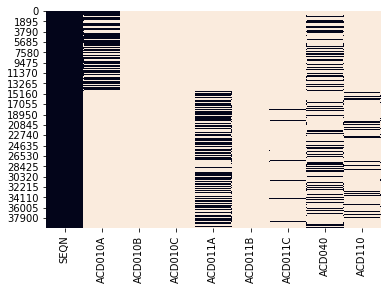

In [1198]:
# Look at null data. 
sns.heatmap(question1_all.isnull(), cbar=False)

In [1199]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("ACQ_")
drop_column_list

['ACD011B', 'ACD011A', 'ACD010A', 'ACD011C', 'ACD010C', 'ACD010B', 'ACD110']

In [1200]:
# Drop columns that do not span all 10 years of data. 
question1_all = question1_all.drop(drop_column_list, axis=1)
question1_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39784 entries, 0 to 39783
Data columns (total 2 columns):
SEQN      39784 non-null int32
ACD040    11178 non-null float64
dtypes: float64(1), int32(1)
memory usage: 466.3 KB


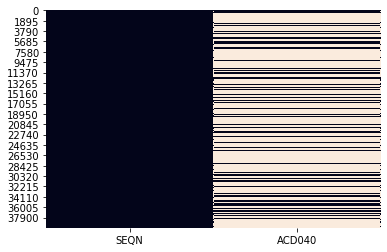

In [1201]:
# Recheck missing data
sns.heatmap(question1_all.isnull(), cbar=False)

**2. Alcohol Use**

In [1202]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question2_dtype_dict = {"SEQN": int}
question2_all = read_nhanes_data(question2_dtype_dict, "ALQ_", True)
question2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
ALQ140Q    6989 non-null float64
ALQ140U    2770 non-null float64
ALQ141Q    10306 non-null float64
ALQ141U    4187 non-null float64
ALQ150     9086 non-null float64
ALQ151     12885 non-null float64
ALQ155     655 non-null float64
ALQ160     3218 non-null float64
SEQN       29040 non-null int32
dtypes: float64(13), int32(1)
memory usage: 3.0 MB


In [1203]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
question2_all = move_columns(['SEQN'], question2_all)
question2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
SEQN       29040 non-null int32
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
ALQ140Q    6989 non-null float64
ALQ140U    2770 non-null float64
ALQ141Q    10306 non-null float64
ALQ141U    4187 non-null float64
ALQ150     9086 non-null float64
ALQ151     12885 non-null float64
ALQ155     655 non-null float64
ALQ160     3218 non-null float64
dtypes: float64(13), int32(1)
memory usage: 3.0 MB


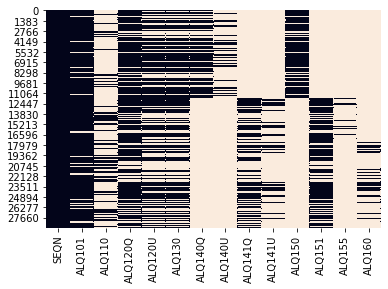

In [1204]:
# Look at null data. 
sns.heatmap(question2_all.isnull(), cbar=False)

In [1205]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("ALQ_")
drop_column_list

['ALQ140Q',
 'ALQ151',
 'ALQ141Q',
 'ALQ140U',
 'ALQ141U',
 'ALQ160',
 'ALQ150',
 'ALQ155']

In [1206]:
# Drop columns that do not span all 10 years of data. 
question2_all = question2_all.drop(drop_column_list, axis=1)
question2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 6 columns):
SEQN       29040 non-null int32
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
dtypes: float64(5), int32(1)
memory usage: 1.2 MB


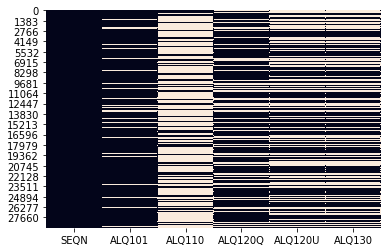

In [1207]:
# Recheck null data. 
sns.heatmap(question2_all.isnull(), cbar=False)

**3. Blood Pressure & Cholesterol**

In [1208]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question3_dtype_dict = {"SEQN": int}
question3_all = read_nhanes_data(question3_dtype_dict, "BPQ_", True)
question3_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 22 columns):
BPD035     10616 non-null float64
BPD058     4551 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ052     6546 non-null float64
BPQ056     19527 non-null float64
BPQ057     19272 non-null float64
BPQ059     19527 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090A    3781 non-null float64
BPQ090B    3781 non-null float64
BPQ090C    3781 non-null float64
BPQ090D    17126 non-null float64
BPQ100A    3092 non-null float64
BPQ100B    2326 non-null float64
BPQ100C    2673 non-null float64
BPQ100D    6992 non-null float64
SEQN       32401 non-null int32
dtypes: float64(21), int32(1)
memory usage: 5.3 MB


In [1209]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
question3_all = move_columns(['SEQN'], question3_all)
question3_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 22 columns):
SEQN       32401 non-null int32
BPD035     10616 non-null float64
BPD058     4551 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ052     6546 non-null float64
BPQ056     19527 non-null float64
BPQ057     19272 non-null float64
BPQ059     19527 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090A    3781 non-null float64
BPQ090B    3781 non-null float64
BPQ090C    3781 non-null float64
BPQ090D    17126 non-null float64
BPQ100A    3092 non-null float64
BPQ100B    2326 non-null float64
BPQ100C    2673 non-null float64
BPQ100D    6992 non-null float64
dtypes: float64(21), int32(1)
memory usage: 5.3 MB


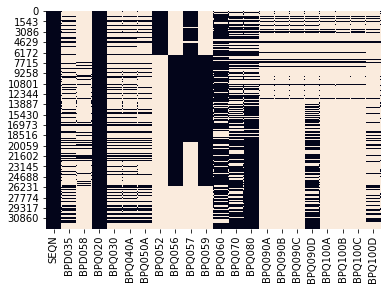

In [1210]:
# Look at null data. 
sns.heatmap(question3_all.isnull(), cbar=False)

In [1211]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("BPQ_")
drop_column_list

['BPQ100B',
 'BPQ090A',
 'BPQ056',
 'BPD058',
 'BPQ059',
 'BPQ100A',
 'BPQ090B',
 'BPQ052',
 'BPQ100C',
 'BPQ090C',
 'BPQ057']

In [1212]:
# Drop columns that do not span all 10 years of data. 
question3_all = question3_all.drop(drop_column_list, axis=1)
question3_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 11 columns):
SEQN       32401 non-null int32
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
dtypes: float64(10), int32(1)
memory usage: 2.6 MB


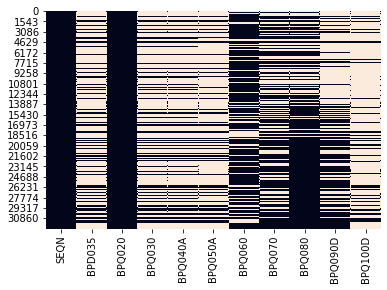

In [1213]:
# Recheck missing data. 
sns.heatmap(question3_all.isnull(), cbar=False)

**4. Consumer Behavior**

In [1214]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question4_dtype_dict = {"SEQN": int}
question4_all = read_nhanes_data(question4_dtype_dict, "CBQ_", True)
question4_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 23 columns):
CBD010    20220 non-null float64
CBD070    40210 non-null float64
CBD071    9642 non-null float64
CBD090    40185 non-null float64
CBD091    9639 non-null float64
CBD110    40210 non-null float64
CBD111    9642 non-null float64
CBD120    40210 non-null float64
CBD121    9642 non-null float64
CBD130    40210 non-null float64
CBD131    9642 non-null float64
CBD150    20361 non-null float64
CBD160    20453 non-null float64
CBD170    19506 non-null float64
CBD180    20446 non-null float64
CBQ020    20453 non-null float64
CBQ030    20453 non-null float64
CBQ040    20453 non-null float64
CBQ050    20453 non-null float64
CBQ060    20453 non-null float64
CBQ140    20453 non-null float64
CBQ190    16413 non-null float64
SEQN      50588 non-null int32
dtypes: float64(22), int32(1)
memory usage: 8.7 MB


In [1215]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
question4_all = move_columns(['SEQN'], question4_all)
question4_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 23 columns):
SEQN      50588 non-null int32
CBD010    20220 non-null float64
CBD070    40210 non-null float64
CBD071    9642 non-null float64
CBD090    40185 non-null float64
CBD091    9639 non-null float64
CBD110    40210 non-null float64
CBD111    9642 non-null float64
CBD120    40210 non-null float64
CBD121    9642 non-null float64
CBD130    40210 non-null float64
CBD131    9642 non-null float64
CBD150    20361 non-null float64
CBD160    20453 non-null float64
CBD170    19506 non-null float64
CBD180    20446 non-null float64
CBQ020    20453 non-null float64
CBQ030    20453 non-null float64
CBQ040    20453 non-null float64
CBQ050    20453 non-null float64
CBQ060    20453 non-null float64
CBQ140    20453 non-null float64
CBQ190    16413 non-null float64
dtypes: float64(22), int32(1)
memory usage: 8.7 MB


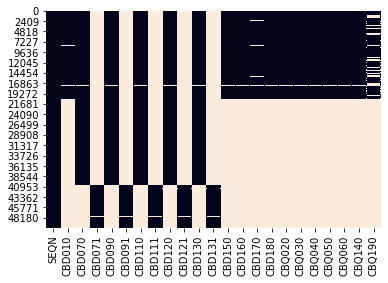

In [1216]:
# Look at null data. 
sns.heatmap(question4_all.isnull(), cbar=False)

In [1217]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("CBQ_")
drop_column_list

['CBD131',
 'CBD170',
 'CBD180',
 'CBD111',
 'CBD130',
 'CBD150',
 'CBD010',
 'CBQ190',
 'CBQ050',
 'CBD071',
 'CBD110',
 'CBQ060',
 'CBD120',
 'CBD160',
 'CBQ040',
 'CBQ030',
 'CBD091',
 'CBD070',
 'CBD090',
 'CBQ020',
 'CBD121',
 'CBQ140']

In [1218]:
# Drop columns that do not span all 10 years of data. =>No columns span entire 10 years. 
question4_all = question4_all.drop(drop_column_list, axis=1)
question4_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 1 columns):
SEQN    50588 non-null int32
dtypes: int32(1)
memory usage: 197.7 KB


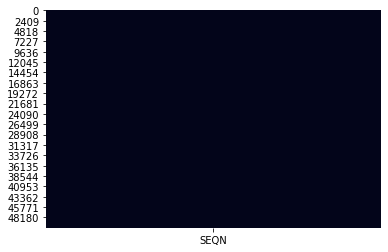

In [1219]:
# Recheck missing data. => no columns left. No questions span entire 10 year period!
sns.heatmap(question4_all.isnull(), cbar=False)

**5. Current Health Status**

In [1220]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question5_dtype_dict = {"SEQN": int}
question5_all = read_nhanes_data(question5_dtype_dict, "HSQ_", True)
question5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 14 columns):
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ470     18798 non-null float64
HSQ480     18795 non-null float64
HSQ490     18792 non-null float64
HSQ493     18790 non-null float64
HSQ496     18787 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
SEQN       46685 non-null int32
dtypes: float64(13), int32(1)
memory usage: 4.8 MB


In [1221]:
# Move unique identifier columns back to front of dataframe. They got moved when pd.concat had to sort column names 
#    as not all years have same columns. 
question5_all = move_columns(['SEQN'], question5_all)
question5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 14 columns):
SEQN       46685 non-null int32
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ470     18798 non-null float64
HSQ480     18795 non-null float64
HSQ490     18792 non-null float64
HSQ493     18790 non-null float64
HSQ496     18787 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
dtypes: float64(13), int32(1)
memory usage: 4.8 MB


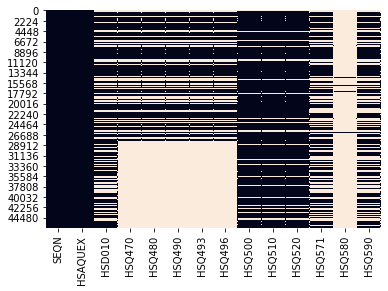

In [1222]:
# Look at null data. 
sns.heatmap(question5_all.isnull(), cbar=False)

In [1223]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("HSQ_")
drop_column_list

['HSQ493', 'HSQ470', 'HSQ480', 'HSQ490', 'HSQ496']

In [1224]:
# Drop columns that do not span all 10 years of data. 
question5_all = question5_all.drop(drop_column_list, axis=1)
question5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46685 entries, 0 to 46684
Data columns (total 9 columns):
SEQN       46685 non-null int32
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
dtypes: float64(8), int32(1)
memory usage: 3.0 MB


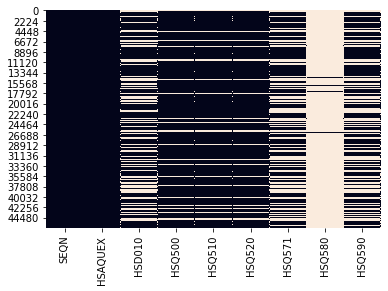

In [1225]:
# Recheck missing data. 
sns.heatmap(question5_all.isnull(), cbar=False)

**6. Cardiovascular Health**

In [1226]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question6_dtype_dict = {"SEQN": int}
question6_all = read_nhanes_data(question6_dtype_dict, "CDQ_", False)
question6_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19344 entries, 0 to 19343
Data columns (total 17 columns):
SEQN       19344 non-null int32
CDQ001     19338 non-null float64
CDQ002     4857 non-null float64
CDQ003     1641 non-null float64
CDQ004     1459 non-null float64
CDQ005     1360 non-null float64
CDQ006     1185 non-null float64
CDQ009A    86 non-null float64
CDQ009B    180 non-null float64
CDQ009C    111 non-null float64
CDQ009D    556 non-null float64
CDQ009E    182 non-null float64
CDQ009F    355 non-null float64
CDQ009G    84 non-null float64
CDQ009H    23 non-null float64
CDQ008     4857 non-null float64
CDQ010     19337 non-null float64
dtypes: float64(16), int32(1)
memory usage: 2.4 MB


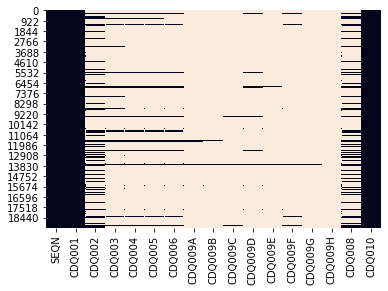

In [1227]:
# Look at null data. 
sns.heatmap(question6_all.isnull(), cbar=False)

In [1228]:
# Determine columns not in all 10 years of data. => No columns to drop. No column changes in 10 year period. 
drop_column_list = changed_columns("CDQ_")
drop_column_list

[]

**7. Diabetes**

In [1229]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question7_dtype_dict = {"SEQN": int}
question7_all = read_nhanes_data(question7_dtype_dict, "DIQ_", False)
question7_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48484 entries, 0 to 48483
Data columns (total 65 columns):
SEQN       48484 non-null int32
DIQ010     48482 non-null float64
DID040     3814 non-null float64
DIQ220     142 non-null float64
DIQ160     31329 non-null float64
DIQ170     32005 non-null float64
DIQ180     32005 non-null float64
DIQ190A    7173 non-null float64
DIQ190B    7173 non-null float64
DIQ190C    7173 non-null float64
DIQ200A    7173 non-null float64
DIQ200B    7173 non-null float64
DIQ200C    7173 non-null float64
DIQ050     48481 non-null float64
DID060     1126 non-null float64
DIQ060U    1098 non-null float64
DID070     1125 non-null float64
DIQ230     3814 non-null float64
DIQ240     3814 non-null float64
DID250     2916 non-null float64
DID260     3807 non-null float64
DIQ260U    3070 non-null float64
DID270     777 non-null float64
DIQ280     2108 non-null float64
DIQ290     513 non-null float64
DIQ300S    3054 non-null float64
DIQ300D    3054 non-null float64

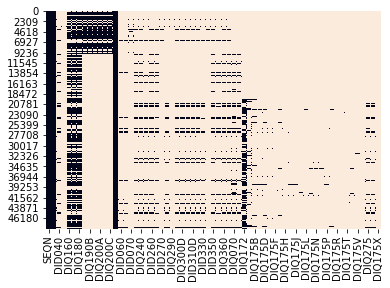

In [1230]:
# Look at null data. 
sns.heatmap(question7_all.isnull(), cbar=False)

In [1231]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("DIQ_")
drop_column_list

['DIQ220',
 'DIQ200B',
 'DIQ175V',
 'DIQ175X',
 'DIQ175P',
 'DIQ175N',
 'DIQ280',
 'DIQ175T',
 'DIQ290',
 'DIQ175L',
 'DIQ200C',
 'DIQ275',
 'DIQ175D',
 'DIQ190A',
 'DIQ175C',
 'DIQ190B',
 'DIQ175K',
 'DIQ175R',
 'DIQ175M',
 'DIQ300D',
 'DIQ175F',
 'DID270',
 'DID340',
 'DIQ175S',
 'DIQ175E',
 'DIQ070',
 'DID320',
 'DIQ175H',
 'DID330',
 'DID341',
 'DID070',
 'DIQ175U',
 'DIQ175I',
 'DID310S',
 'DID310D',
 'DIQ300S',
 'DIQ175G',
 'DIQ172',
 'DIQ175O',
 'DIQ190C',
 'DIQ175Q',
 'DIQ175B',
 'DIQ200A',
 'DIQ291',
 'DIQ175A',
 'DIQ175J',
 'DIQ175W']

In [1232]:
# Drop columns that do not span all 10 years of data. 
question7_all = question7_all.drop(drop_column_list, axis=1)
question7_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48484 entries, 0 to 48483
Data columns (total 18 columns):
SEQN       48484 non-null int32
DIQ010     48482 non-null float64
DID040     3814 non-null float64
DIQ160     31329 non-null float64
DIQ170     32005 non-null float64
DIQ180     32005 non-null float64
DIQ050     48481 non-null float64
DID060     1126 non-null float64
DIQ060U    1098 non-null float64
DIQ230     3814 non-null float64
DIQ240     3814 non-null float64
DID250     2916 non-null float64
DID260     3807 non-null float64
DIQ260U    3070 non-null float64
DID350     3718 non-null float64
DIQ350U    3027 non-null float64
DIQ360     3789 non-null float64
DIQ080     3789 non-null float64
dtypes: float64(17), int32(1)
memory usage: 6.5 MB


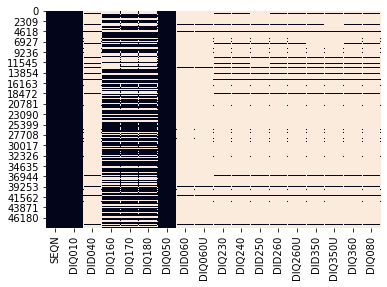

In [1233]:
# Recheck missing data. 
sns.heatmap(question7_all.isnull(), cbar=False)

**8. Diet Behavior & Nutrition**

In [1234]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question8_dtype_dict = {"SEQN": int}
question8_all = read_nhanes_data(question8_dtype_dict, "DBQ_", False)
question8_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 85 columns):
SEQN       50588 non-null int32
DBQ010     9360 non-null float64
DBD020     1286 non-null float64
DBD030     6617 non-null float64
DBD040     1868 non-null float64
DBD050     8217 non-null float64
DBD060     1868 non-null float64
DBD072A    1122 non-null float64
DBD072B    234 non-null float64
DBD072C    11 non-null float64
DBD072D    8 non-null float64
DBD072U    59 non-null float64
DBD080     1868 non-null float64
DBQ700     32400 non-null float64
DBQ197     48482 non-null float64
DBD222A    3293 non-null float64
DBD222B    3435 non-null float64
DBD222C    773 non-null float64
DBD222D    870 non-null float64
DBD222U    399 non-null float64
DBQ229     29200 non-null float64
DBQ235A    22112 non-null float64
DBQ235B    22112 non-null float64
DBQ235C    22112 non-null float64
DBQ301     9757 non-null float64
DBQ330     9757 non-null float64
DBQ360     15294 non-null float64
DBQ37

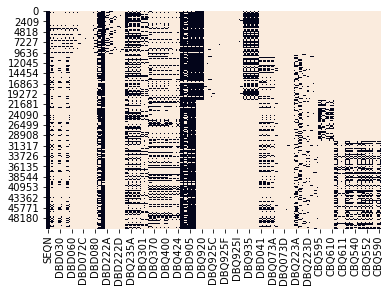

In [1235]:
# Look at null data. 
sns.heatmap(question8_all.isnull(), cbar=False)

In [1236]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("DBQ_")
drop_column_list

['DBQ223C',
 'CBQ540',
 'DBD061',
 'DBQ223D',
 'CBQ611',
 'DBQ073D',
 'DBQ223A',
 'DBQ925C',
 'DBQ925H',
 'DBD072A',
 'DBD072U',
 'DBQ073A',
 'CBQ550',
 'DBD060',
 'CBQ590',
 'DBQ073B',
 'DBD222D',
 'DBQ073E',
 'CBQ595',
 'DBQ915',
 'DBD222U',
 'DBQ925I',
 'DBD222A',
 'CBQ596',
 'CBQ610',
 'DBD072B',
 'DBD055',
 'DBD222B',
 'DBQ935',
 'DBQ223E',
 'DBQ925F',
 'CBQ600',
 'DBQ940',
 'DBD072C',
 'DBD020',
 'DBQ925J',
 'DBD072D',
 'DBQ925G',
 'DBQ223U',
 'DBQ223B',
 'CBQ585',
 'DBQ925A',
 'CBQ545',
 'DBQ945',
 'CBQ605',
 'DBQ920',
 'CBQ505',
 'DBQ925D',
 'DBQ930',
 'DBQ073U',
 'DBQ925E',
 'CBQ580',
 'DBQ073C',
 'DBD041',
 'DBD222C',
 'CBQ606',
 'DBD040',
 'DBQ925B',
 'DBD080',
 'CBQ535',
 'CBQ552']

In [1237]:
# Drop columns that do not span all 10 years of data. 
question8_all = question8_all.drop(drop_column_list, axis=1)
question8_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 24 columns):
SEQN       50588 non-null int32
DBQ010     9360 non-null float64
DBD030     6617 non-null float64
DBD050     8217 non-null float64
DBQ700     32400 non-null float64
DBQ197     48482 non-null float64
DBQ229     29200 non-null float64
DBQ235A    22112 non-null float64
DBQ235B    22112 non-null float64
DBQ235C    22112 non-null float64
DBQ301     9757 non-null float64
DBQ330     9757 non-null float64
DBQ360     15294 non-null float64
DBQ370     12847 non-null float64
DBD381     12239 non-null float64
DBQ390     10398 non-null float64
DBQ400     12847 non-null float64
DBD411     10819 non-null float64
DBQ421     5929 non-null float64
DBQ424     7857 non-null float64
DBD895     48144 non-null float64
DBD900     36276 non-null float64
DBD905     48080 non-null float64
DBD910     48070 non-null float64
dtypes: float64(23), int32(1)
memory usage: 9.1 MB


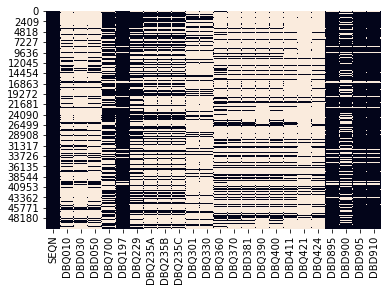

In [1238]:
# Recheck missing data. 
sns.heatmap(question8_all.isnull(), cbar=False)

**9. Mental Health – Depression Screener**

In [1239]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question9_dtype_dict = {"SEQN": int}
question9_all = read_nhanes_data(question9_dtype_dict, "DPQ_", False)
question9_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29629 entries, 0 to 29628
Data columns (total 11 columns):
SEQN      29629 non-null int32
DPQ010    26541 non-null float64
DPQ020    26536 non-null float64
DPQ030    26534 non-null float64
DPQ040    26530 non-null float64
DPQ050    26530 non-null float64
DPQ060    26528 non-null float64
DPQ070    26526 non-null float64
DPQ080    26525 non-null float64
DPQ090    26521 non-null float64
DPQ100    17902 non-null float64
dtypes: float64(10), int32(1)
memory usage: 2.4 MB


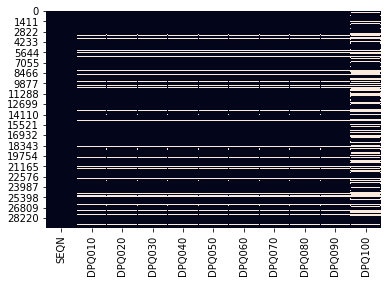

In [1240]:
# Look at null data. 
sns.heatmap(question9_all.isnull(), cbar=False)

In [1241]:
# Determine columns not in all 10 years of data. => No columns changed in 10 years. 
drop_column_list = changed_columns("DPQ_")
drop_column_list

[]

**10. Drug Use**

In [1242]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question10_dtype_dict = {"SEQN": int}
question10_all = read_nhanes_data(question10_dtype_dict, "DUQ_", False)
question10_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24623 entries, 0 to 24622
Data columns (total 43 columns):
SEQN       24623 non-null int32
DUAISC     4625 non-null float64
DUQ200     17488 non-null float64
DUQ210     9235 non-null float64
DUQ220Q    9229 non-null float64
DUQ220U    9210 non-null float64
DUQ230     2559 non-null float64
DUQ240     21606 non-null float64
DUQ250     3524 non-null float64
DUQ260     2920 non-null float64
DUQ270Q    2920 non-null float64
DUQ270U    2913 non-null float64
DUQ272     2919 non-null float64
DUQ280     312 non-null float64
DUQ290     3523 non-null float64
DUQ300     407 non-null float64
DUQ310Q    407 non-null float64
DUQ310U    406 non-null float64
DUQ320     44 non-null float64
DUQ330     3523 non-null float64
DUQ340     1149 non-null float64
DUQ350Q    1149 non-null float64
DUQ350U    1147 non-null float64
DUQ352     1149 non-null float64
DUQ360     97 non-null float64
DUQ370     21600 non-null float64
DUQ380A    262 non-null float64
DUQ380B

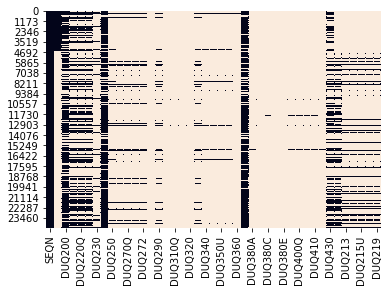

In [1243]:
# Look at null data. 
sns.heatmap(question10_all.isnull(), cbar=False)

In [1244]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("DUQ_")
drop_column_list

['DUQ219', 'DUQ211', 'DUAISC', 'DUQ215Q', 'DUQ213', 'DUQ217', 'DUQ215U']

In [1245]:
# Drop columns that do not span all 10 years of data. 
question10_all = question10_all.drop(drop_column_list, axis=1)
question10_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24623 entries, 0 to 24622
Data columns (total 36 columns):
SEQN       24623 non-null int32
DUQ200     17488 non-null float64
DUQ210     9235 non-null float64
DUQ220Q    9229 non-null float64
DUQ220U    9210 non-null float64
DUQ230     2559 non-null float64
DUQ240     21606 non-null float64
DUQ250     3524 non-null float64
DUQ260     2920 non-null float64
DUQ270Q    2920 non-null float64
DUQ270U    2913 non-null float64
DUQ272     2919 non-null float64
DUQ280     312 non-null float64
DUQ290     3523 non-null float64
DUQ300     407 non-null float64
DUQ310Q    407 non-null float64
DUQ310U    406 non-null float64
DUQ320     44 non-null float64
DUQ330     3523 non-null float64
DUQ340     1149 non-null float64
DUQ350Q    1149 non-null float64
DUQ350U    1147 non-null float64
DUQ352     1149 non-null float64
DUQ360     97 non-null float64
DUQ370     21600 non-null float64
DUQ380A    262 non-null float64
DUQ380B    241 non-null float64
DUQ380C 

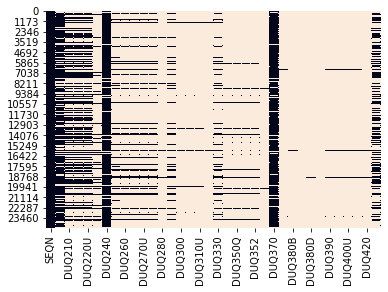

In [1246]:
# Recheck missing data. 
sns.heatmap(question10_all.isnull(), cbar=False)

**11. Early Childhood**

In [1247]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question11_dtype_dict = {"SEQN": int}
question11_all = read_nhanes_data(question11_dtype_dict, "ECQ_", False)
question11_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18187 entries, 0 to 18186
Data columns (total 14 columns):
SEQN       18187 non-null int32
ECD010     18185 non-null float64
ECQ020     18185 non-null float64
ECQ030     513 non-null float64
ECQ040     202 non-null float64
ECQ060     3602 non-null float64
ECD070A    18185 non-null float64
ECD070B    17990 non-null float64
ECQ080     401 non-null float64
ECQ090     261 non-null float64
WHQ030E    14666 non-null float64
MCQ080E    14666 non-null float64
ECQ150     1652 non-null float64
FSQ121     1712 non-null float64
dtypes: float64(13), int32(1)
memory usage: 1.9 MB


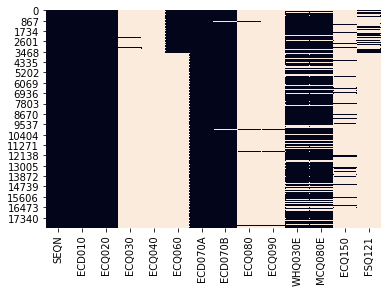

In [1248]:
# Look at null data. 
sns.heatmap(question11_all.isnull(), cbar=False)

In [1249]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("ECQ_")
drop_column_list

['ECQ060', 'ECQ040', 'ECQ030', 'FSQ121']

In [1250]:
# Drop columns that do not span all 10 years of data. 
question11_all = question11_all.drop(drop_column_list, axis=1)
question11_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18187 entries, 0 to 18186
Data columns (total 10 columns):
SEQN       18187 non-null int32
ECD010     18185 non-null float64
ECQ020     18185 non-null float64
ECD070A    18185 non-null float64
ECD070B    17990 non-null float64
ECQ080     401 non-null float64
ECQ090     261 non-null float64
WHQ030E    14666 non-null float64
MCQ080E    14666 non-null float64
ECQ150     1652 non-null float64
dtypes: float64(9), int32(1)
memory usage: 1.3 MB


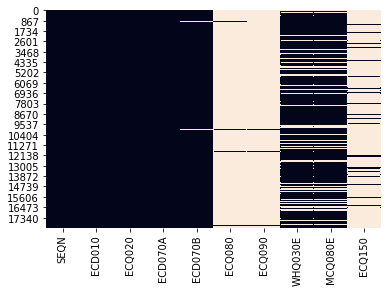

In [1251]:
# Recheck missing data. 
sns.heatmap(question11_all.isnull(), cbar=False)

**12. Health Insurance**

In [1252]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question12_dtype_dict = {"SEQN": int}
question12_all = read_nhanes_data(question12_dtype_dict, "HIQ_", False)
question12_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 17 columns):
SEQN        50588 non-null int32
HIQ011      50587 non-null float64
HIQ031A     23533 non-null float64
HIQ031B     6770 non-null float64
HIQ031C     134 non-null float64
HIQ031D     10483 non-null float64
HIQ031E     465 non-null float64
HIQ031F     1271 non-null float64
HIQ031G     29 non-null float64
HIQ031H     3060 non-null float64
HIQ031I     1412 non-null float64
HIQ031J     1648 non-null float64
HIQ031AA    19 non-null float64
HIQ260      1224 non-null float64
HIQ105      5037 non-null float64
HIQ270      41969 non-null float64
HIQ210      41966 non-null float64
dtypes: float64(16), int32(1)
memory usage: 6.4 MB


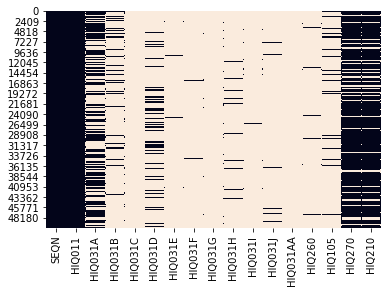

In [1253]:
# Look at null data. 
sns.heatmap(question12_all.isnull(), cbar=False)

In [1254]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("HIQ_")
drop_column_list

['HIQ031G']

In [1255]:
# Drop columns that do not span all 10 years of data. 
question12_all = question12_all.drop(drop_column_list, axis=1)
question12_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 16 columns):
SEQN        50588 non-null int32
HIQ011      50587 non-null float64
HIQ031A     23533 non-null float64
HIQ031B     6770 non-null float64
HIQ031C     134 non-null float64
HIQ031D     10483 non-null float64
HIQ031E     465 non-null float64
HIQ031F     1271 non-null float64
HIQ031H     3060 non-null float64
HIQ031I     1412 non-null float64
HIQ031J     1648 non-null float64
HIQ031AA    19 non-null float64
HIQ260      1224 non-null float64
HIQ105      5037 non-null float64
HIQ270      41969 non-null float64
HIQ210      41966 non-null float64
dtypes: float64(15), int32(1)
memory usage: 6.0 MB


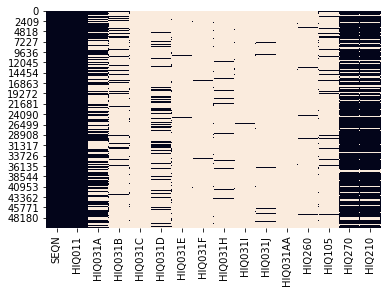

In [1256]:
# Recheck missing data. 
sns.heatmap(question12_all.isnull(), cbar=False)

**13. Housing Characteristics**

In [1257]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question13_dtype_dict = {"SEQN": int}
question13_all = read_nhanes_data(question13_dtype_dict, "HOQ_", False)
question13_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 7 columns):
SEQN      50588 non-null int32
HOQ040    20524 non-null float64
HOD050    49927 non-null float64
HOD060    20524 non-null float64
HOQ065    49927 non-null float64
HOQ070    20524 non-null float64
HOQ080    20524 non-null float64
dtypes: float64(6), int32(1)
memory usage: 2.5 MB


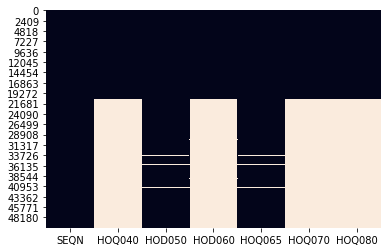

In [1258]:
# Look at null data. 
sns.heatmap(question13_all.isnull(), cbar=False)

In [1259]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("HOQ_")
drop_column_list

['HOD060', 'HOQ070', 'HOQ040', 'HOQ080']

In [1260]:
# Drop columns that do not span all 10 years of data. 
question13_all = question13_all.drop(drop_column_list, axis=1)
question13_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 3 columns):
SEQN      50588 non-null int32
HOD050    49927 non-null float64
HOQ065    49927 non-null float64
dtypes: float64(2), int32(1)
memory usage: 988.1 KB


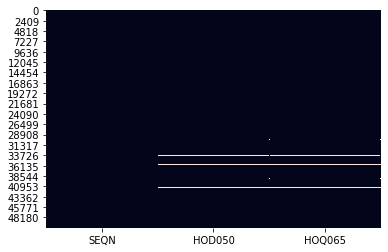

In [1261]:
# Recheck missing data. 
sns.heatmap(question13_all.isnull(), cbar=False)

**14. Hospital Utilization & Access to Care**

In [1262]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question14_dtype_dict = {"SEQN": int}
question14_all = read_nhanes_data(question14_dtype_dict, "HUQ_", False)
question14_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 13 columns):
SEQN      50588 non-null int32
HUQ010    50588 non-null float64
HUQ020    48482 non-null float64
HUQ030    50588 non-null float64
HUQ040    26943 non-null float64
HUQ050    30442 non-null float64
HUQ060    4144 non-null float64
HUQ071    50588 non-null float64
HUD080    4873 non-null float64
HUQ090    44498 non-null float64
HUQ041    17612 non-null float64
HUQ051    20146 non-null float64
HUQ061    2708 non-null float64
dtypes: float64(12), int32(1)
memory usage: 4.8 MB


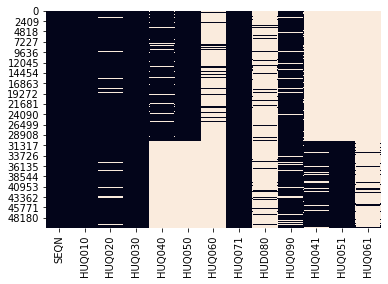

In [1263]:
# Look at null data. 
sns.heatmap(question14_all.isnull(), cbar=False)

In [1264]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("HUQ_")
drop_column_list

['HUQ051', 'HUQ040', 'HUQ050', 'HUQ060', 'HUQ061', 'HUQ041']

In [1265]:
# Drop columns that do not span all 10 years of data. 
question14_all = question14_all.drop(drop_column_list, axis=1)
question14_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 7 columns):
SEQN      50588 non-null int32
HUQ010    50588 non-null float64
HUQ020    48482 non-null float64
HUQ030    50588 non-null float64
HUQ071    50588 non-null float64
HUD080    4873 non-null float64
HUQ090    44498 non-null float64
dtypes: float64(6), int32(1)
memory usage: 2.5 MB


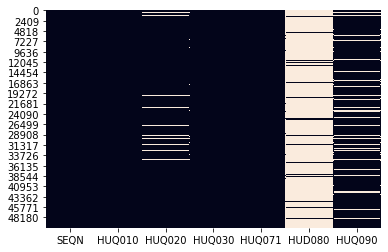

In [1266]:
# Recheck missing data. 
sns.heatmap(question14_all.isnull(), cbar=False)

**15. Immunization**

In [1267]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question15_dtype_dict = {"SEQN": int}
question15_all = read_nhanes_data(question15_dtype_dict, "IMQ_", False)
question15_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 11 columns):
SEQN      50588 non-null int32
IMQ011    47069 non-null float64
IMQ020    50588 non-null float64
IMQ040    11860 non-null float64
IMQ045    2067 non-null float64
IMQ070    8521 non-null float64
IMQ080    1082 non-null float64
IMQ090    2458 non-null float64
IMQ060    2996 non-null float64
IMD080    618 non-null float64
IMQ100    966 non-null float64
dtypes: float64(10), int32(1)
memory usage: 4.1 MB


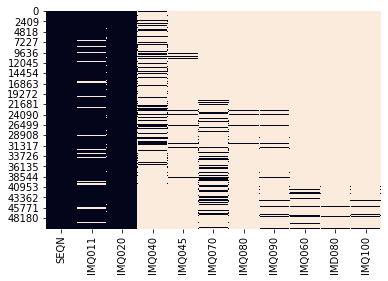

In [1268]:
# Look at null data. 
sns.heatmap(question15_all.isnull(), cbar=False)

In [1269]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("IMQ_")
drop_column_list

['IMQ060',
 'IMQ090',
 'IMQ045',
 'IMQ080',
 'IMQ100',
 'IMQ070',
 'IMD080',
 'IMQ040']

In [1270]:
# Drop columns that do not span all 10 years of data. 
question15_all = question15_all.drop(drop_column_list, axis=1)
question15_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 3 columns):
SEQN      50588 non-null int32
IMQ011    47069 non-null float64
IMQ020    50588 non-null float64
dtypes: float64(2), int32(1)
memory usage: 988.1 KB


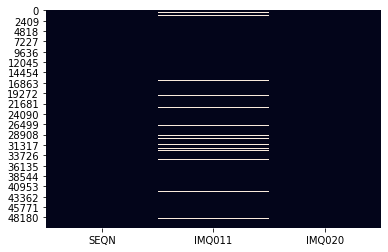

In [1271]:
# Recheck missing data. 
sns.heatmap(question15_all.isnull(), cbar=False)

**16. Income**

In [1272]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question16_dtype_dict = {"SEQN": int}
question16_all = read_nhanes_data(question16_dtype_dict, "INQ_", False)
question16_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 18 columns):
SEQN        50588 non-null int32
INQ020      49925 non-null float64
INQ012      49925 non-null float64
INQ030      49925 non-null float64
INQ060      49925 non-null float64
INQ080      49925 non-null float64
INQ090      49925 non-null float64
INQ132      49925 non-null float64
INQ140      49925 non-null float64
INQ150      49925 non-null float64
IND235      48422 non-null float64
INDFMMPI    44304 non-null float64
INDFMMPC    48420 non-null float64
INQ244      22052 non-null float64
IND247      18955 non-null float64
INQ300      9420 non-null float64
IND310      6939 non-null float64
INQ320      9642 non-null float64
dtypes: float64(17), int32(1)
memory usage: 6.8 MB


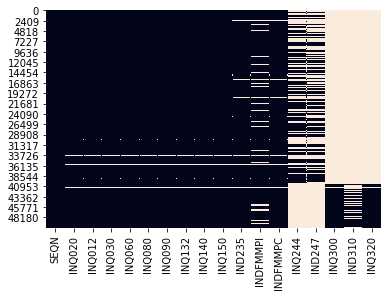

In [1273]:
# Look at null data. 
sns.heatmap(question16_all.isnull(), cbar=False)

In [1274]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("INQ_")
drop_column_list

['IND247', 'INQ244', 'INQ320', 'IND310', 'INQ300']

In [1275]:
# Drop columns that do not span all 10 years of data. 
question16_all = question16_all.drop(drop_column_list, axis=1)
question16_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 13 columns):
SEQN        50588 non-null int32
INQ020      49925 non-null float64
INQ012      49925 non-null float64
INQ030      49925 non-null float64
INQ060      49925 non-null float64
INQ080      49925 non-null float64
INQ090      49925 non-null float64
INQ132      49925 non-null float64
INQ140      49925 non-null float64
INQ150      49925 non-null float64
IND235      48422 non-null float64
INDFMMPI    44304 non-null float64
INDFMMPC    48420 non-null float64
dtypes: float64(12), int32(1)
memory usage: 4.8 MB


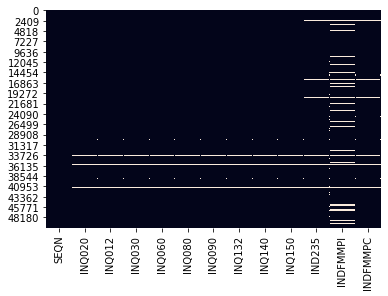

In [1276]:
# Recheck missing data. 
sns.heatmap(question16_all.isnull(), cbar=False)

**17. Medical Conditions**

In [1277]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question17_dtype_dict = {"SEQN": int}
question17_all = read_nhanes_data(question17_dtype_dict, "MCQ_", False)
question17_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48484 entries, 0 to 48483
Columns: 114 entries, SEQN to OSQ230
dtypes: float64(113), int32(1)
memory usage: 42.0 MB


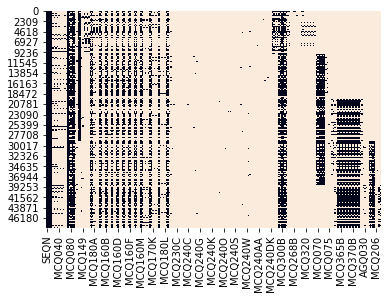

In [1278]:
# Look at null data. 
sns.heatmap(question17_all.isnull(), cbar=False)

In [1279]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("MCQ_")
drop_column_list

['MCQ365D',
 'MCQ370C',
 'MCQ245B',
 'MCQ195',
 'MCQ370B',
 'MCQ268D',
 'MCQ370D',
 'MCQ140',
 'MCQ151',
 'MCQ086',
 'MCQ191',
 'MCQ350',
 'MCQ365A',
 'OSQ230',
 'MCQ365B',
 'MCQ160O',
 'MCQ268B',
 'MCQ084',
 'MCQ265',
 'MCQ320',
 'MCQ190',
 'MCQ206',
 'MCQ150Q',
 'MCQ310',
 'MCQ245A',
 'MCQ268A',
 'MCQ070',
 'MCD330',
 'MCQ380',
 'MCQ051',
 'MCQ365C',
 'AGQ030',
 'MCQ075',
 'MCQ203',
 'MCQ082',
 'MCQ268C',
 'MCQ340',
 'MCQ370A',
 'MCQ150G']

In [1280]:
# Drop columns that do not span all 10 years of data. 
question17_all = question17_all.drop(drop_column_list, axis=1)
question17_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48484 entries, 0 to 48483
Data columns (total 75 columns):
SEQN        48484 non-null int32
MCQ010      48482 non-null float64
MCQ025      7263 non-null float64
MCQ035      7265 non-null float64
MCQ040      4406 non-null float64
MCQ050      3573 non-null float64
MCQ053      48482 non-null float64
MCQ080      32400 non-null float64
MCQ092      42347 non-null float64
MCD093      3739 non-null float64
MCQ149      2143 non-null float64
MCQ160A     29199 non-null float64
MCQ180A     7772 non-null float64
MCQ160N     29200 non-null float64
MCQ180N     1318 non-null float64
MCQ160B     29200 non-null float64
MCQ180B     973 non-null float64
MCQ160C     29200 non-null float64
MCQ180C     1175 non-null float64
MCQ160D     29200 non-null float64
MCQ180D     717 non-null float64
MCQ160E     29200 non-null float64
MCQ180E     1226 non-null float64
MCQ160F     29200 non-null float64
MCQ180F     1125 non-null float64
MCQ160G     29200 non-null float6

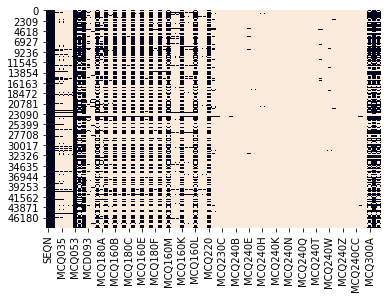

In [1281]:
# Recheck missing data. 
sns.heatmap(question17_all.isnull(), cbar=False)

**18. Occupation**

In [1282]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question18_dtype_dict = {"SEQN": int}
question18_all = read_nhanes_data(question18_dtype_dict, "OCQ_", False)
question18_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 30 columns):
SEQN       32401 non-null int32
OCD150     32393 non-null float64
OCQ180     16440 non-null float64
OCQ210     5081 non-null float64
OCD231     10021 non-null float64
OCD241     10022 non-null float64
OCQ260     17023 non-null float64
OCQ265     6974 non-null float64
OCD270     17023 non-null float64
OCQ290G    6974 non-null float64
OCQ290Q    1083 non-null float64
OCQ380     14176 non-null float64
OCD390G    32393 non-null float64
OCD391     10973 non-null float64
OCD392     10980 non-null float64
OCD395     18094 non-null float64
OCQ510     16913 non-null float64
OCQ520     5217 non-null float64
OCQ530     16913 non-null float64
OCQ540     3693 non-null float64
OCQ550     16913 non-null float64
OCQ560     4005 non-null float64
OCQ570     16913 non-null float64
OCQ580     5242 non-null float64
OCQ275     3087 non-null float64
OCQ600     3519 non-null float64
OCQ610     3514 non

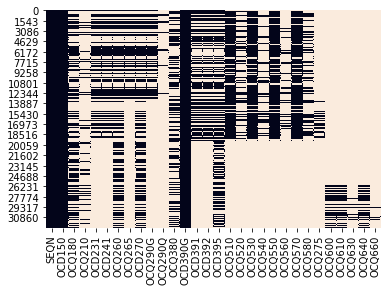

In [1283]:
# Look at null data. 
sns.heatmap(question18_all.isnull(), cbar=False)

In [1284]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("OCQ_")
drop_column_list

['OCQ630',
 'OCQ600',
 'OCQ530',
 'OCD241',
 'OCQ265',
 'OCQ290G',
 'OCD231',
 'OCQ540',
 'OCQ570',
 'OCQ550',
 'OCQ580',
 'OCD392',
 'OCQ290Q',
 'OCQ275',
 'OCQ510',
 'OCQ520',
 'OCD391',
 'OCQ640',
 'OCQ660',
 'OCQ560',
 'OCQ610']

In [1285]:
# Drop columns that do not span all 10 years of data. 
question18_all = question18_all.drop(drop_column_list, axis=1)
question18_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 9 columns):
SEQN       32401 non-null int32
OCD150     32393 non-null float64
OCQ180     16440 non-null float64
OCQ210     5081 non-null float64
OCQ260     17023 non-null float64
OCD270     17023 non-null float64
OCQ380     14176 non-null float64
OCD390G    32393 non-null float64
OCD395     18094 non-null float64
dtypes: float64(8), int32(1)
memory usage: 2.1 MB


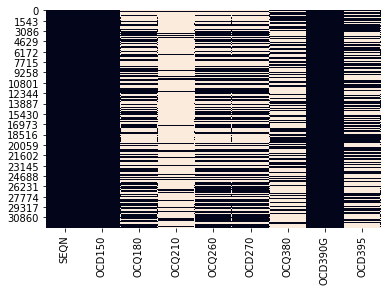

In [1286]:
# Recheck missing data. 
sns.heatmap(question18_all.isnull(), cbar=False)

**19. Oral Health**

In [1287]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question19_dtype_dict = {"SEQN": int}
question19_all = read_nhanes_data(question19_dtype_dict, "OHQ_", False)
question19_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40114 entries, 0 to 40113
Data columns (total 65 columns):
SEQN       40114 non-null int32
OHQ011     6228 non-null float64
OHQ620     20349 non-null float64
OHQ630     6228 non-null float64
OHQ640     20349 non-null float64
OHQ650     6228 non-null float64
OHQ660     6228 non-null float64
OHQ670     6228 non-null float64
OHQ680     20349 non-null float64
OHQ835     18955 non-null float64
OHQ845     33540 non-null float64
OHQ850     18955 non-null float64
OHQ855     14212 non-null float64
OHQ860     18955 non-null float64
OHQ865     14212 non-null float64
OHQ870     18955 non-null float64
OHQ875     14211 non-null float64
OHQ030     28706 non-null float64
OHQ033     26701 non-null float64
OHQ770     26701 non-null float64
OHQ780A    3217 non-null float64
OHQ780B    233 non-null float64
OHQ780C    781 non-null float64
OHQ780D    92 non-null float64
OHQ780E    122 non-null float64
OHQ780F    16 non-null float64
OHQ780G    231 non-null flo

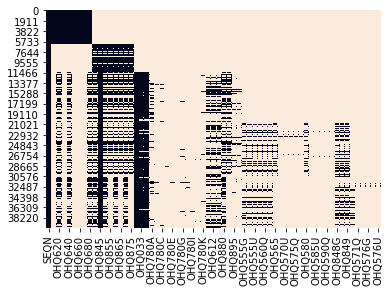

In [1288]:
# Look at null data. 
sns.heatmap(question19_all.isnull(), cbar=False)

In [1289]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("OHQ_")
drop_column_list

['OHQ780I',
 'OHQ900',
 'OHQ848G',
 'OHQ576G',
 'OHQ870',
 'OHQ590G',
 'OHQ680',
 'OHQ580',
 'OHQ780D',
 'OHQ560U',
 'OHQ849',
 'OHQ780F',
 'OHQ590U',
 'OHQ585Q',
 'OHQ770',
 'OHQ575Q',
 'OHQ845',
 'OHQ780H',
 'OHQ780A',
 'OHQ835',
 'OHQ576U',
 'OHQ860',
 'OHQ565',
 'OHQ780B',
 'OHQ575U',
 'OHQ848Q',
 'OHQ780K',
 'OHQ780G',
 'OHQ850',
 'OHQ560Q',
 'OHQ780J',
 'OHQ570U',
 'OHQ575G',
 'OHQ620',
 'OHQ670',
 'OHQ011',
 'OHQ875',
 'OHQ640',
 'OHQ865',
 'OHQ590Q',
 'OHQ555Q',
 'OHQ566',
 'OHQ855',
 'OHQ610',
 'OHQ630',
 'OHQ650',
 'OHQ885',
 'OHQ880',
 'OHQ576Q',
 'OHQ571U',
 'OHQ555U',
 'OHQ780E',
 'OHQ560G',
 'OHQ614',
 'OHQ555G',
 'OHQ033',
 'OHQ585U',
 'OHQ660',
 'OHQ895',
 'OHQ030',
 'OHQ571Q',
 'OHQ780C',
 'OHQ570Q',
 'OHQ612']

In [1290]:
# Drop columns that do not span all 10 years of data. => No columns span entire 10 year period. 
question19_all = question19_all.drop(drop_column_list, axis=1)
question19_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40114 entries, 0 to 40113
Data columns (total 1 columns):
SEQN    40114 non-null int32
dtypes: int32(1)
memory usage: 156.8 KB


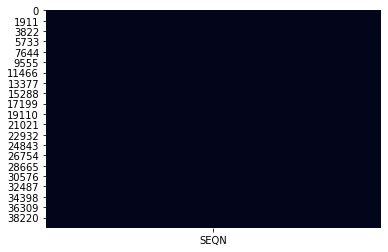

In [1291]:
# Recheck missing data. 
sns.heatmap(question19_all.isnull(), cbar=False)

**20. Physical Functioning**

In [1292]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question20_dtype_dict = {"SEQN": int}
question20_all = read_nhanes_data(question20_dtype_dict, "PFQ_", False)
question20_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 56 columns):
SEQN       45253 non-null int32
PFQ010     1040 non-null float64
PFQ015     31 non-null float64
PFQ020     16049 non-null float64
PFQ030     663 non-null float64
PFQ041     14529 non-null float64
PFQ049     29200 non-null float64
PFQ051     29200 non-null float64
PFQ054     29200 non-null float64
PFQ057     29200 non-null float64
PFQ059     21506 non-null float64
PFQ061A    13502 non-null float64
PFQ061B    10465 non-null float64
PFQ061C    10465 non-null float64
PFQ061D    13502 non-null float64
PFQ061E    13502 non-null float64
PFQ061F    13502 non-null float64
PFQ061G    13502 non-null float64
PFQ061H    13502 non-null float64
PFQ061I    13502 non-null float64
PFQ061J    13502 non-null float64
PFQ061K    13502 non-null float64
PFQ061L    13502 non-null float64
PFQ061M    13502 non-null float64
PFQ061N    13502 non-null float64
PFQ061O    13502 non-null float64
PFQ061P    1350

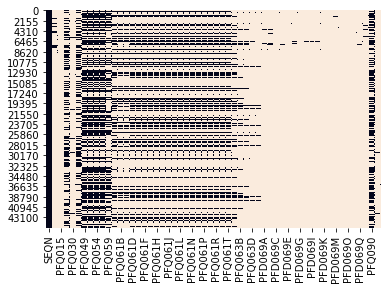

In [1293]:
# Look at null data. 
sns.heatmap(question20_all.isnull(), cbar=False)

In [1294]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("PFQ_")
drop_column_list

['PFD069I',
 'PFD069D',
 'PFD069M',
 'PFD069N',
 'PFD069R',
 'PFD069Q',
 'PFQ033',
 'PFD069O',
 'PFD069E',
 'PFD069C',
 'PFD069L',
 'PFD069P',
 'PFQ010',
 'PFD069G',
 'PFD069H',
 'PFD069F',
 'PFD069B',
 'PFQ015',
 'PFD069A',
 'PFD069K',
 'PFD069J']

In [1295]:
# Drop columns that do not span all 10 years of data. 
question20_all = question20_all.drop(drop_column_list, axis=1)
question20_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 35 columns):
SEQN       45253 non-null int32
PFQ020     16049 non-null float64
PFQ030     663 non-null float64
PFQ041     14529 non-null float64
PFQ049     29200 non-null float64
PFQ051     29200 non-null float64
PFQ054     29200 non-null float64
PFQ057     29200 non-null float64
PFQ059     21506 non-null float64
PFQ061A    13502 non-null float64
PFQ061B    10465 non-null float64
PFQ061C    10465 non-null float64
PFQ061D    13502 non-null float64
PFQ061E    13502 non-null float64
PFQ061F    13502 non-null float64
PFQ061G    13502 non-null float64
PFQ061H    13502 non-null float64
PFQ061I    13502 non-null float64
PFQ061J    13502 non-null float64
PFQ061K    13502 non-null float64
PFQ061L    13502 non-null float64
PFQ061M    13502 non-null float64
PFQ061N    13502 non-null float64
PFQ061O    13502 non-null float64
PFQ061P    13502 non-null float64
PFQ061Q    13502 non-null float64
PFQ061R    

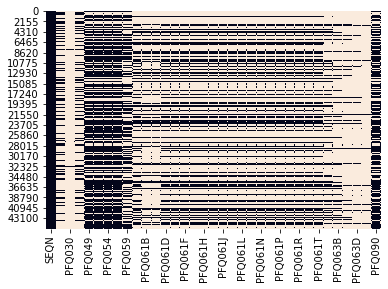

In [1296]:
# Recheck missing data. 
sns.heatmap(question20_all.isnull(), cbar=False)

**21. Physical Activity**

In [1297]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question21_dtype_dict = {"SEQN": int}
question21_all = read_nhanes_data(question21_dtype_dict, "PAQ_", False)
question21_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46976 entries, 0 to 46975
Data columns (total 99 columns):
SEQN        46976 non-null int32
PAQ560      1932 non-null float64
PAD590      4160 non-null float64
PAD600      4160 non-null float64
PAQ605      35498 non-null float64
PAQ610      6024 non-null float64
PAD615      5983 non-null float64
PAQ620      35497 non-null float64
PAQ625      12153 non-null float64
PAD630      12104 non-null float64
PAQ635      35496 non-null float64
PAQ640      10414 non-null float64
PAD645      10386 non-null float64
PAQ650      35494 non-null float64
PAQ655      9909 non-null float64
PAD660      9890 non-null float64
PAQ665      35492 non-null float64
PAQ670      14545 non-null float64
PAD675      14512 non-null float64
PAD680      35448 non-null float64
PAAQUEX     37721 non-null float64
PAQ706      10402 non-null float64
PAQ710      27735 non-null float64
PAQ715      27735 non-null float64
PAQ722      5298 non-null float64
PAQ724A     240 non-null f

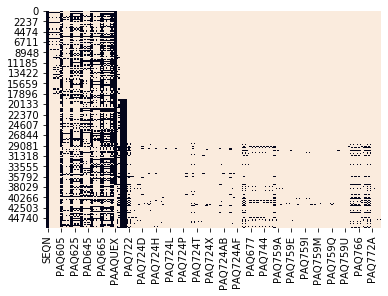

In [1298]:
# Look at null data. 
sns.heatmap(question21_all.isnull(), cbar=False)

In [1299]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("PAQ_")
drop_column_list

['PAQ772C',
 'PAQ759L',
 'PAQ759U',
 'PAQ759K',
 'PAQ750',
 'PAQ724G',
 'PAQ759P',
 'PAQ759J',
 'PAQ724T',
 'PAQ724AC',
 'PAQ724W',
 'PAQ744',
 'PAQ759D',
 'PAQ759N',
 'PAQ731',
 'PAQ724L',
 'PAQ759A',
 'PAQ762',
 'PAQ764',
 'PAQ759H',
 'PAQ724Q',
 'PAQ715',
 'PAQ759T',
 'PAQ724X',
 'PAQ678',
 'PAQ759V',
 'PAQ724I',
 'PAQ724K',
 'PAQ560',
 'PAQ724AE',
 'PAQ722',
 'PAQ759I',
 'PAQ724D',
 'PAQ759M',
 'PAQ724F',
 'PAQ724R',
 'PAQ755',
 'PAQ724B',
 'PAQ724N',
 'PAQ742',
 'PAQ759E',
 'PAD733',
 'PAQ748',
 'PAD600',
 'PAQ759R',
 'PAQ746',
 'PAQ759S',
 'PAQ766',
 'PAQ724O',
 'PAQ724A',
 'PAQ724AF',
 'PAQ759O',
 'PAQ710',
 'PAQ724AA',
 'PAQ724H',
 'PAQ770',
 'PAQ724U',
 'PAQ772A',
 'PAQ759F',
 'PAD590',
 'PAQ724M',
 'PAQ724Z',
 'PAQ724P',
 'PAQ724E',
 'PAQ724Y',
 'PAQ772B',
 'PAQ724J',
 'PAQ740',
 'PAQ724AB',
 'PAQ724AD',
 'PAQ759B',
 'PAQ679',
 'PAQ759C',
 'PAQ724S',
 'PAQ724C',
 'PAQ724CM',
 'PAQ759Q',
 'PAQ706',
 'PAAQUEX',
 'PAQ724V',
 'PAQ677',
 'PAQ759G']

In [1300]:
# Drop columns that do not span all 10 years of data. 
question21_all = question21_all.drop(drop_column_list, axis=1)
question21_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46976 entries, 0 to 46975
Data columns (total 17 columns):
SEQN      46976 non-null int32
PAQ605    35498 non-null float64
PAQ610    6024 non-null float64
PAD615    5983 non-null float64
PAQ620    35497 non-null float64
PAQ625    12153 non-null float64
PAD630    12104 non-null float64
PAQ635    35496 non-null float64
PAQ640    10414 non-null float64
PAD645    10386 non-null float64
PAQ650    35494 non-null float64
PAQ655    9909 non-null float64
PAD660    9890 non-null float64
PAQ665    35492 non-null float64
PAQ670    14545 non-null float64
PAD675    14512 non-null float64
PAD680    35448 non-null float64
dtypes: float64(16), int32(1)
memory usage: 5.9 MB


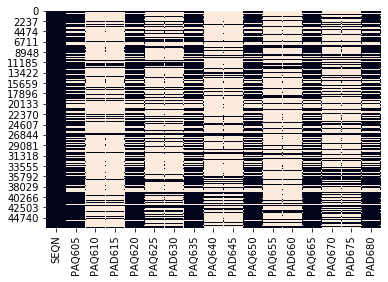

In [1301]:
# Recheck missing data. 
sns.heatmap(question21_all.isnull(), cbar=False)

**22. Reproductive Health**

In [1302]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question22_dtype_dict = {"SEQN": int}
question22_all = read_nhanes_data(question22_dtype_dict, "RHQ_", False)
question22_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17616 entries, 0 to 17615
Data columns (total 66 columns):
SEQN       17616 non-null int32
RHQ010     15749 non-null float64
RHQ020     156 non-null float64
RHQ031     15566 non-null float64
RHD042     4099 non-null float64
RHQ060     6887 non-null float64
RHQ070     350 non-null float64
RHQ131     12794 non-null float64
RHD143     3662 non-null float64
RHD152     133 non-null float64
RHQ160     10843 non-null float64
RHQ162     10842 non-null float64
RHQ163     812 non-null float64
RHQ166     10792 non-null float64
RHQ169     5928 non-null float64
RHQ172     10264 non-null float64
RHD173     1800 non-null float64
RHQ171     10262 non-null float64
RHD180     8584 non-null float64
RHD190     10082 non-null float64
RHQ197     703 non-null float64
RHQ200     701 non-null float64
RHQ205     6121 non-null float64
RHD280     12808 non-null float64
RHQ291     2920 non-null float64
RHQ305     12672 non-null float64
RHQ332     1519 non-null floa

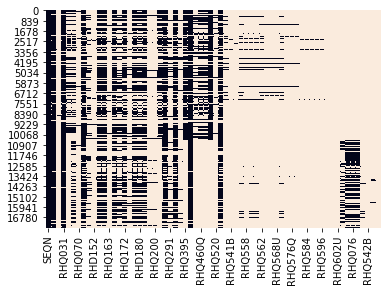

In [1303]:
# Look at null data. 
sns.heatmap(question22_all.isnull(), cbar=False)

In [1304]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("RHQ_")
drop_column_list

['RHQ541C',
 'RHQ460U',
 'RHD442',
 'RHD042',
 'RHQ074',
 'RHQ510',
 'RHQ542C',
 'RHQ600',
 'RHQ520',
 'RHQ542D',
 'RHQ542B',
 'RHQ568U',
 'RHQ562',
 'RHQ078',
 'RHQ541A',
 'RHQ574',
 'RHD043',
 'RHQ566',
 'RHQ205',
 'RHQ395',
 'RHQ460Q',
 'RHQ558',
 'RHQ076',
 'RHQ584',
 'RHQ568Q',
 'RHQ542A',
 'RHQ541B',
 'RHD152']

In [1305]:
# Drop columns that do not span all 10 years of data. 
question22_all = question22_all.drop(drop_column_list, axis=1)
question22_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17616 entries, 0 to 17615
Data columns (total 38 columns):
SEQN       17616 non-null int32
RHQ010     15749 non-null float64
RHQ020     156 non-null float64
RHQ031     15566 non-null float64
RHQ060     6887 non-null float64
RHQ070     350 non-null float64
RHQ131     12794 non-null float64
RHD143     3662 non-null float64
RHQ160     10843 non-null float64
RHQ162     10842 non-null float64
RHQ163     812 non-null float64
RHQ166     10792 non-null float64
RHQ169     5928 non-null float64
RHQ172     10264 non-null float64
RHD173     1800 non-null float64
RHQ171     10262 non-null float64
RHD180     8584 non-null float64
RHD190     10082 non-null float64
RHQ197     703 non-null float64
RHQ200     701 non-null float64
RHD280     12808 non-null float64
RHQ291     2920 non-null float64
RHQ305     12672 non-null float64
RHQ332     1519 non-null float64
RHQ420     15550 non-null float64
RHQ540     12818 non-null float64
RHQ554     2029 non-null f

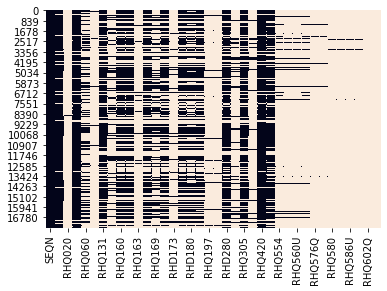

In [1306]:
# Recheck missing data. 
sns.heatmap(question22_all.isnull(), cbar=False)

**23. Sleep Disorders**

In [1307]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question23_dtype_dict = {"SEQN": int}
question23_all = read_nhanes_data(question23_dtype_dict, "SLQ_", False)
question23_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 31 columns):
SEQN       32401 non-null int32
SLD010H    26055 non-null float64
SLD020M    6546 non-null float64
SLQ030     12873 non-null float64
SLQ040     12873 non-null float64
SLQ050     32400 non-null float64
SLQ060     26073 non-null float64
SLQ070A    301 non-null float64
SLQ070B    107 non-null float64
SLQ070C    18 non-null float64
SLQ070D    74 non-null float64
SLQ080     6546 non-null float64
SLQ090     6546 non-null float64
SLQ100     6546 non-null float64
SLQ110     6546 non-null float64
SLQ120     12873 non-null float64
SLQ130     6546 non-null float64
SLQ140     6546 non-null float64
SLQ150     6546 non-null float64
SLQ160     6546 non-null float64
SLQ170     6546 non-null float64
SLQ180     6546 non-null float64
SLQ190     6546 non-null float64
SLQ200     6546 non-null float64
SLQ210     6546 non-null float64
SLQ220     6546 non-null float64
SLQ230     6546 non-null float64
S

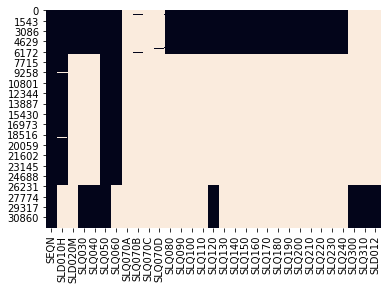

In [1308]:
# Look at null data. 
sns.heatmap(question23_all.isnull(), cbar=False)

In [1309]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("SLQ_")
drop_column_list

['SLQ310',
 'SLD012',
 'SLD010H',
 'SLQ060',
 'SLQ040',
 'SLQ300',
 'SLQ230',
 'SLQ080',
 'SLQ070B',
 'SLQ120',
 'SLD020M',
 'SLQ180',
 'SLQ100',
 'SLQ240',
 'SLQ070C',
 'SLQ190',
 'SLQ210',
 'SLQ130',
 'SLQ090',
 'SLQ030',
 'SLQ170',
 'SLQ220',
 'SLQ150',
 'SLQ110',
 'SLQ140',
 'SLQ160',
 'SLQ070D',
 'SLQ070A',
 'SLQ200']

In [1310]:
# Drop columns that do not span all 10 years of data. 
question23_all = question23_all.drop(drop_column_list, axis=1)
question23_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 2 columns):
SEQN      32401 non-null int32
SLQ050    32400 non-null float64
dtypes: float64(1), int32(1)
memory usage: 379.8 KB


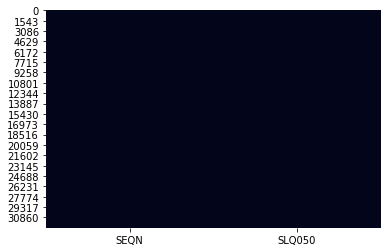

In [1311]:
# Recheck missing data. 
sns.heatmap(question23_all.isnull(), cbar=False)

**24. Smoking – Cigarette Use**

In [1312]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question24_dtype_dict = {"SEQN": int}
question24_all = read_nhanes_data(question24_dtype_dict, "SMQ_", False)
question24_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35632 entries, 0 to 35631
Data columns (total 57 columns):
SEQN        35632 non-null int32
SMQ020      29817 non-null float64
SMD030      13038 non-null float64
SMQ040      13038 non-null float64
SMQ050Q     6937 non-null float64
SMQ050U     6797 non-null float64
SMD055      6330 non-null float64
SMD057      6580 non-null float64
SMQ077      3498 non-null float64
SMD641      7030 non-null float64
SMD650      6557 non-null float64
SMD093      6105 non-null float64
SMDUPCA     3826 non-null object
SMD100BR    5650 non-null object
SMD100FL    5644 non-null float64
SMD100MN    5646 non-null float64
SMD100LN    5646 non-null float64
SMD100TR    4261 non-null float64
SMD100NI    4261 non-null float64
SMD100CO    4261 non-null float64
SMQ620      2298 non-null float64
SMD630      1148 non-null float64
SMQ660      453 non-null float64
SMQ664M     173 non-null float64
SMQ664C     77 non-null float64
SMQ664W     1 non-null float64
SMQ664B     1 

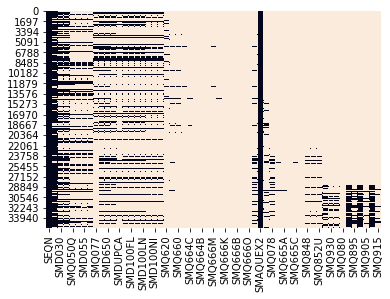

In [1313]:
# Look at null data. 
sns.heatmap(question24_all.isnull(), cbar=False)

In [1314]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("SMQ_")
drop_column_list

['SMQ664B',
 'SMQ895',
 'SMQ664O',
 'SMQ664C',
 'SMQ078',
 'SMQ665B',
 'SMQ915',
 'SMQ620',
 'SMQ848',
 'SMQ664W',
 'SMQ621',
 'SMQ890',
 'SMQ910',
 'SMQ666M',
 'SMQ661',
 'SMQ666S',
 'SMQ666C',
 'SMQ935',
 'SMQ077',
 'SMQ665C',
 'SMQ925',
 'SMQ666B',
 'SMQ905',
 'SMQ930',
 'SMQ900',
 'SMQ660',
 'SMQ852U',
 'SMQ666W',
 'SMQ852Q',
 'SMQ664M',
 'SMQ666O',
 'SMQ666K',
 'SMQ665A',
 'SMQ665D',
 'SMQ080']

In [1315]:
# Drop columns that do not span all 10 years of data. 
question24_all = question24_all.drop(drop_column_list, axis=1)
question24_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35632 entries, 0 to 35631
Data columns (total 22 columns):
SEQN        35632 non-null int32
SMQ020      29817 non-null float64
SMD030      13038 non-null float64
SMQ040      13038 non-null float64
SMQ050Q     6937 non-null float64
SMQ050U     6797 non-null float64
SMD055      6330 non-null float64
SMD057      6580 non-null float64
SMD641      7030 non-null float64
SMD650      6557 non-null float64
SMD093      6105 non-null float64
SMDUPCA     3826 non-null object
SMD100BR    5650 non-null object
SMD100FL    5644 non-null float64
SMD100MN    5646 non-null float64
SMD100LN    5646 non-null float64
SMD100TR    4261 non-null float64
SMD100NI    4261 non-null float64
SMD100CO    4261 non-null float64
SMD630      1148 non-null float64
SMQ670      3081 non-null float64
SMAQUEX2    35632 non-null float64
dtypes: float64(19), int32(1), object(2)
memory usage: 5.8+ MB


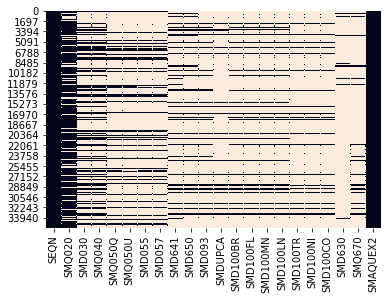

In [1316]:
# Recheck missing data. 
sns.heatmap(question24_all.isnull(), cbar=False)

**25. Smoking – Household Smokers**

In [1317]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question25_dtype_dict = {"SEQN": int}
question25_all = read_nhanes_data(question25_dtype_dict, "SMQFAM_", False)
question25_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 8 columns):
SEQN       50588 non-null int32
SMD410     30257 non-null float64
SMD415     4586 non-null float64
SMD415A    4348 non-null float64
SMD430     4348 non-null float64
SMD460     19708 non-null float64
SMD470     5165 non-null float64
SMD480     2251 non-null float64
dtypes: float64(7), int32(1)
memory usage: 2.9 MB


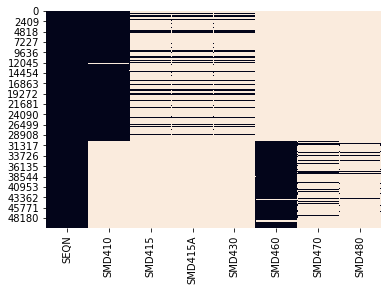

In [1318]:
# Look at null data. 
sns.heatmap(question25_all.isnull(), cbar=False)

In [1319]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("SMQFAM_")
drop_column_list

['SMD415A', 'SMD480', 'SMD470', 'SMD460', 'SMD415', 'SMD410', 'SMD430']

In [1320]:
# Drop columns that do not span all 10 years of data. => No columns span entire 10 year period. 
question25_all = question25_all.drop(drop_column_list, axis=1)
question25_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50588 entries, 0 to 50587
Data columns (total 1 columns):
SEQN    50588 non-null int32
dtypes: int32(1)
memory usage: 197.7 KB


**26. Smoking – Recent Tobacco Use**

In [1321]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question26_dtype_dict = {"SEQN": int}
question26_all = read_nhanes_data(question26_dtype_dict, "SMQRTU_", False)
question26_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 36 columns):
SEQN       34558 non-null int32
SMQ680     18731 non-null float64
SMQ690A    5791 non-null float64
SMQ690B    77 non-null float64
SMQ690C    705 non-null float64
SMQ690D    350 non-null float64
SMQ690E    189 non-null float64
SMQ690F    105 non-null float64
SMQ710     5789 non-null float64
SMQ720     5789 non-null float64
SMQ725     5789 non-null float64
SMQ740     77 non-null float64
SMQ750     49 non-null float64
SMQ755     49 non-null float64
SMQ770     705 non-null float64
SMQ780     371 non-null float64
SMQ785     371 non-null float64
SMQ800     350 non-null float64
SMQ815     240 non-null float64
SMQ817     189 non-null float64
SMQ819     95 non-null float64
SMQ830     105 non-null float64
SMQ840     105 non-null float64
SMAQUEX    34558 non-null float64
SMQ681     12590 non-null float64
SMQ690G    97 non-null float64
SMQ845     97 non-null float64
SMQ690H    215 non-null 

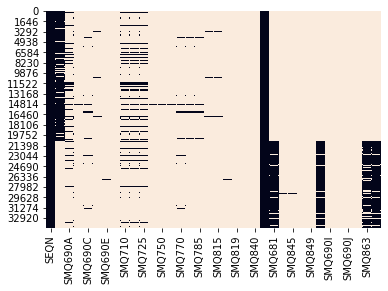

In [1322]:
# Look at null data. 
sns.heatmap(question26_all.isnull(), cbar=False)

In [1323]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("SMQRTU_")
drop_column_list

['SMQ690G',
 'SMQ750',
 'SMQ863',
 'SMQ681',
 'SMQ857',
 'SMQ861',
 'SMQ815',
 'SMQ680',
 'SMQ755',
 'SMDANY',
 'SMQ690I',
 'SMQ851',
 'SMQ845',
 'SMQ849',
 'SMQ785',
 'SMQ690J',
 'SMQ780',
 'SMQ690H',
 'SMQ819']

In [1324]:
# Drop columns that do not span all 10 years of data. 
question26_all = question26_all.drop(drop_column_list, axis=1)
question26_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 17 columns):
SEQN       34558 non-null int32
SMQ690A    5791 non-null float64
SMQ690B    77 non-null float64
SMQ690C    705 non-null float64
SMQ690D    350 non-null float64
SMQ690E    189 non-null float64
SMQ690F    105 non-null float64
SMQ710     5789 non-null float64
SMQ720     5789 non-null float64
SMQ725     5789 non-null float64
SMQ740     77 non-null float64
SMQ770     705 non-null float64
SMQ800     350 non-null float64
SMQ817     189 non-null float64
SMQ830     105 non-null float64
SMQ840     105 non-null float64
SMAQUEX    34558 non-null float64
dtypes: float64(16), int32(1)
memory usage: 4.4 MB


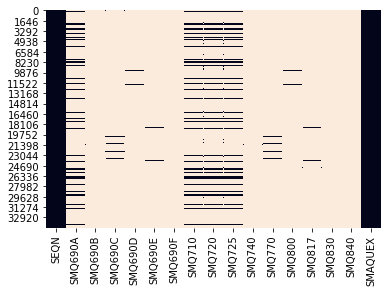

In [1325]:
# Recheck missing data. 
sns.heatmap(question26_all.isnull(), cbar=False)

**27. Sexual Behavior**

In [1326]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question27_dtype_dict = {"SEQN": int}
question27_all = read_nhanes_data(question27_dtype_dict, "SXQ_", False)
question27_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24623 entries, 0 to 24622
Data columns (total 63 columns):
SEQN      24623 non-null int32
SXAISC    4625 non-null float64
SXQ021    4124 non-null float64
SXD031    20121 non-null float64
SXQ101    1947 non-null float64
SXQ350    1541 non-null float64
SXQ130    2297 non-null float64
SXD171    10325 non-null float64
SXQ400    1352 non-null float64
SXQ410    2159 non-null float64
SXQ430    103 non-null float64
SXQ450    1541 non-null float64
SXQ470    1299 non-null float64
SXQ490    862 non-null float64
SXQ510    1352 non-null float64
SXQ530    1221 non-null float64
SXQ550    646 non-null float64
SXQ570    39 non-null float64
SXQ590    6324 non-null float64
SXQ600    6324 non-null float64
SXQ610    14359 non-null float64
SXQ251    13629 non-null float64
SXQ260    16315 non-null float64
SXQ265    16315 non-null float64
SXQ270    16313 non-null float64
SXQ272    16313 non-null float64
SXQ280    8392 non-null float64
SXQ292    6973 non-null f

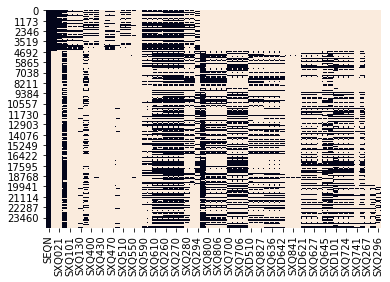

In [1327]:
# Look at null data. 
sns.heatmap(question27_all.isnull(), cbar=False)

In [1328]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("SXQ_")
drop_column_list

['SXD642',
 'SXQ636',
 'SXQ700',
 'SXQ510',
 'SXQ841',
 'SXQ803',
 'SXQ295',
 'SXQ627',
 'SXQ292',
 'SXQ294',
 'SXQ827',
 'SXQ400',
 'SXD021',
 'SXQ709',
 'SXQ706',
 'SXQ809',
 'SXQ703',
 'SXQ267',
 'SXQ741',
 'SXQ350',
 'SXD621',
 'SXQ101',
 'SXD633',
 'SXQ470',
 'SXQ021',
 'SXQ800',
 'SXQ836',
 'SXQ296',
 'SXQ450',
 'SXQ530',
 'SXQ806',
 'SXQ753',
 'SXQ648',
 'SXQ570',
 'SXD450',
 'SXQ727',
 'SXQ639',
 'SXQ624',
 'SXD630',
 'SXAISC',
 'SXD510',
 'SXD101',
 'SXQ430',
 'SXQ645',
 'SXQ724',
 'SXQ824',
 'SXQ853']

In [1329]:
# Drop columns that do not span all 10 years of data.  
question27_all = question27_all.drop(drop_column_list, axis=1)
question27_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24623 entries, 0 to 24622
Data columns (total 16 columns):
SEQN      24623 non-null int32
SXD031    20121 non-null float64
SXQ130    2297 non-null float64
SXD171    10325 non-null float64
SXQ410    2159 non-null float64
SXQ490    862 non-null float64
SXQ550    646 non-null float64
SXQ590    6324 non-null float64
SXQ600    6324 non-null float64
SXQ610    14359 non-null float64
SXQ251    13629 non-null float64
SXQ260    16315 non-null float64
SXQ265    16315 non-null float64
SXQ270    16313 non-null float64
SXQ272    16313 non-null float64
SXQ280    8392 non-null float64
dtypes: float64(15), int32(1)
memory usage: 2.9 MB


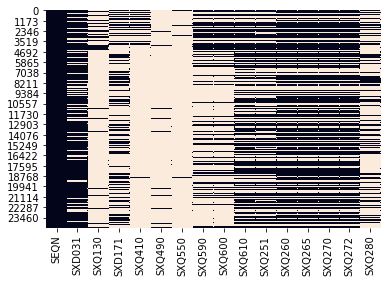

In [1330]:
# Recheck missing data. 
sns.heatmap(question27_all.isnull(), cbar=False)

**28. Weight History**

In [1331]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question28_dtype_dict = {"SEQN": int}
question28_all = read_nhanes_data(question28_dtype_dict, "WHQ_", False)
question28_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 67 columns):
SEQN       32401 non-null int32
WHD010     32187 non-null float64
WHD020     32183 non-null float64
WHQ030     32358 non-null float64
WHQ040     32358 non-null float64
WHD045     13052 non-null float64
WHD050     32193 non-null float64
WHQ060     6120 non-null float64
WHQ070     28553 non-null float64
WHD080A    8170 non-null float64
WHD080B    4200 non-null float64
WHD080C    4480 non-null float64
WHD080D    8408 non-null float64
WHD080E    2210 non-null float64
WHD080F    1198 non-null float64
WHD080G    557 non-null float64
WHD080H    606 non-null float64
WHD080I    354 non-null float64
WHD080J    801 non-null float64
WHD080K    125 non-null float64
WHD080L    184 non-null float64
WHD080M    5456 non-null float64
WHD080N    677 non-null float64
WHD080O    3261 non-null float64
WHD080P    124 non-null float64
WHD080Q    4677 non-null float64
WHD080R    3596 non-null float64
WH

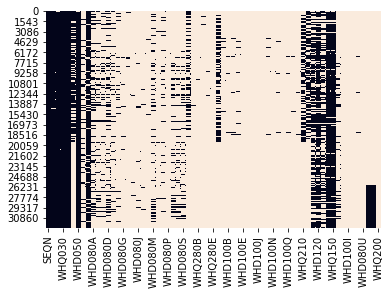

In [1332]:
# Look at null data. 
sns.heatmap(question28_all.isnull(), cbar=False)

In [1333]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("WHQ_")
drop_column_list

['WHD100R',
 'WHQ280E',
 'WHD100P',
 'WHD100H',
 'WHD100E',
 'WHD100Q',
 'WHQ280D',
 'WHD100G',
 'WHD100L',
 'WHQ210',
 'WHQ090',
 'WHD100T',
 'WHQ190',
 'WHQ225',
 'WHD220',
 'WHQ280B',
 'WHQ280A',
 'WHD100J',
 'WHD100S',
 'WHD100C',
 'WHD100D',
 'WHD100I',
 'WHQ280C',
 'WHQ200',
 'WHD045',
 'WHD100F',
 'WHD100N',
 'WHQ270',
 'WHD100B',
 'WHD100A',
 'WHD080T',
 'WHD100O',
 'WHD080U',
 'WHD100M',
 'WHD100K']

In [1334]:
# Drop columns that do not span all 10 years of data.  
question28_all = question28_all.drop(drop_column_list, axis=1)
question28_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 32 columns):
SEQN       32401 non-null int32
WHD010     32187 non-null float64
WHD020     32183 non-null float64
WHQ030     32358 non-null float64
WHQ040     32358 non-null float64
WHD050     32193 non-null float64
WHQ060     6120 non-null float64
WHQ070     28553 non-null float64
WHD080A    8170 non-null float64
WHD080B    4200 non-null float64
WHD080C    4480 non-null float64
WHD080D    8408 non-null float64
WHD080E    2210 non-null float64
WHD080F    1198 non-null float64
WHD080G    557 non-null float64
WHD080H    606 non-null float64
WHD080I    354 non-null float64
WHD080J    801 non-null float64
WHD080K    125 non-null float64
WHD080L    184 non-null float64
WHD080M    5456 non-null float64
WHD080N    677 non-null float64
WHD080O    3261 non-null float64
WHD080P    124 non-null float64
WHD080Q    4677 non-null float64
WHD080R    3596 non-null float64
WHD080S    3520 non-null float64
WHD

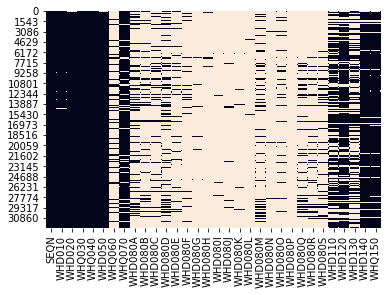

In [1335]:
# Recheck missing data. 
sns.heatmap(question28_all.isnull(), cbar=False)

**29. Weight History – Youth**

In [1336]:
# Read all five years of data in and concatenate into one dataframe. Specify integer types for those columns
#    which do not have NaN data. 
question29_dtype_dict = {"SEQN": int}
question29_all = read_nhanes_data(question29_dtype_dict, "WHQMEC_", False)
question29_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7433 entries, 0 to 7432
Data columns (total 25 columns):
SEQN       7433 non-null int32
WHQ030M    7014 non-null float64
WHQ500     7012 non-null float64
WHQ510A    503 non-null float64
WHQ510B    777 non-null float64
WHQ510C    467 non-null float64
WHQ510D    148 non-null float64
WHQ510E    218 non-null float64
WHQ510F    49 non-null float64
WHQ510G    67 non-null float64
WHQ510H    31 non-null float64
WHQ510I    94 non-null float64
WHQ510J    164 non-null float64
WHQ510K    20 non-null float64
WHQ510L    86 non-null float64
WHQ510P    126 non-null float64
WHQ510N    31 non-null float64
WHQ510U    32 non-null float64
WHQ520     7012 non-null float64
WHQ530     2168 non-null float64
WHQ540     2166 non-null float64
WHQ550     2166 non-null float64
WHQ560     2166 non-null float64
WHQ570     2166 non-null float64
WHQ580     2166 non-null float64
dtypes: float64(24), int32(1)
memory usage: 1.4 MB


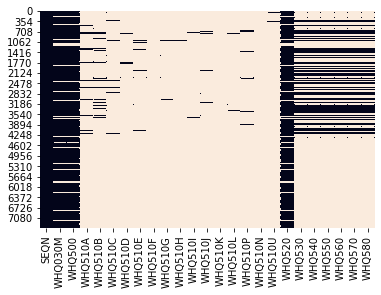

In [1337]:
# Look at null data. 
sns.heatmap(question29_all.isnull(), cbar=False)

In [1338]:
# Determine columns not in all 10 years of data. 
drop_column_list = changed_columns("WHQMEC_")
drop_column_list

['WHQ510G',
 'WHQ570',
 'WHQ550',
 'WHQ530',
 'WHQ510H',
 'WHQ510J',
 'WHQ510E',
 'WHQ540',
 'WHQ510C',
 'WHQ510P',
 'WHQ510D',
 'WHQ510F',
 'WHQ510K',
 'WHQ510I',
 'WHQ510A',
 'WHQ510B',
 'WHQ560',
 'WHQ510U',
 'WHQ580',
 'WHQ510L',
 'WHQ510N']

In [1339]:
# Drop columns that do not span all 10 years of data.  
question29_all = question29_all.drop(drop_column_list, axis=1)
question29_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7433 entries, 0 to 7432
Data columns (total 4 columns):
SEQN       7433 non-null int32
WHQ030M    7014 non-null float64
WHQ500     7012 non-null float64
WHQ520     7012 non-null float64
dtypes: float64(3), int32(1)
memory usage: 203.3 KB


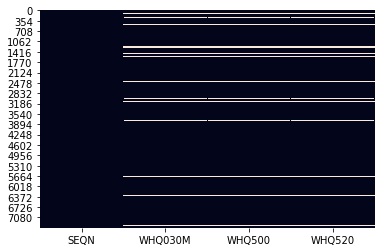

In [1340]:
# Recheck missing data. 
sns.heatmap(question29_all.isnull(), cbar=False)

### Merge the questionnaire data and write out to a csv file. 

In [1341]:
# Acculturation, Alcohol Use 
questionnaire_all = pd.merge(question1_all, question2_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39784 entries, 0 to 39783
Data columns (total 7 columns):
SEQN       39784 non-null int32
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
dtypes: float64(6), int32(1)
memory usage: 2.3 MB


In [1342]:
# Blood Pressure & Cholesterol 
questionnaire_all = pd.merge(questionnaire_all, question3_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39784 entries, 0 to 39783
Data columns (total 17 columns):
SEQN       39784 non-null int32
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
dtypes: float64(16), int32(1)
memory usage: 5.3 MB


In [1343]:
# Consumer Behavior 
questionnaire_all = pd.merge(questionnaire_all, question4_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 17 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
dtypes: float64(16), int64(1)
memory usage: 6.9 MB


In [1344]:
# Current Health Status 
questionnaire_all = pd.merge(questionnaire_all, question5_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 25 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
dtypes: float64(24), int64(1)
memory usage: 10.

In [1345]:
# Cardiovascular Health 
questionnaire_all = pd.merge(questionnaire_all, question6_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 41 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
CDQ001     19338 non-null float64
CDQ002     48

In [1346]:
# Diabetes
questionnaire_all = pd.merge(questionnaire_all, question7_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 58 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
CDQ001     19338 non-null float64
CDQ002     48

In [1347]:
# Diet Behavior & Nutrition 
questionnaire_all = pd.merge(questionnaire_all, question8_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 81 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
CDQ001     19338 non-null float64
CDQ002     48

In [1348]:
# Mental Health – Depression Screener 
questionnaire_all = pd.merge(questionnaire_all, question9_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Data columns (total 91 columns):
SEQN       50588 non-null int64
ACD040     11178 non-null float64
ALQ101     26171 non-null float64
ALQ110     7750 non-null float64
ALQ120Q    21977 non-null float64
ALQ120U    17272 non-null float64
ALQ130     17298 non-null float64
BPD035     10616 non-null float64
BPQ020     32400 non-null float64
BPQ030     10658 non-null float64
BPQ040A    10658 non-null float64
BPQ050A    9240 non-null float64
BPQ060     24680 non-null float64
BPQ070     21921 non-null float64
BPQ080     26926 non-null float64
BPQ090D    17126 non-null float64
BPQ100D    6992 non-null float64
HSAQUEX    46685 non-null float64
HSD010     31439 non-null float64
HSQ500     42323 non-null float64
HSQ510     42323 non-null float64
HSQ520     42323 non-null float64
HSQ571     28300 non-null float64
HSQ580     1339 non-null float64
HSQ590     28299 non-null float64
CDQ001     19338 non-null float64
CDQ002     48

In [1349]:
# Drug Use 
questionnaire_all = pd.merge(questionnaire_all, question10_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 126 entries, SEQN to DUQ430
dtypes: float64(125), int64(1)
memory usage: 49.0 MB


In [1350]:
# Early Childhood 
questionnaire_all = pd.merge(questionnaire_all, question11_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 135 entries, SEQN to ECQ150
dtypes: float64(134), int64(1)
memory usage: 52.5 MB


In [1351]:
# Health Insurance 
questionnaire_all = pd.merge(questionnaire_all, question12_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 150 entries, SEQN to HIQ210
dtypes: float64(149), int64(1)
memory usage: 58.3 MB


In [1352]:
# Housing Characteristics 
questionnaire_all = pd.merge(questionnaire_all, question13_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 152 entries, SEQN to HOQ065
dtypes: float64(151), int64(1)
memory usage: 59.1 MB


In [1353]:
# Hospital Utilization & Access to Care 
questionnaire_all = pd.merge(questionnaire_all, question14_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 158 entries, SEQN to HUQ090
dtypes: float64(157), int64(1)
memory usage: 61.4 MB


In [1354]:
# Immunization
questionnaire_all = pd.merge(questionnaire_all, question15_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 160 entries, SEQN to IMQ020
dtypes: float64(159), int64(1)
memory usage: 62.1 MB


In [1355]:
# Income
questionnaire_all = pd.merge(questionnaire_all, question16_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 172 entries, SEQN to INDFMMPC
dtypes: float64(171), int64(1)
memory usage: 66.8 MB


In [1356]:
# Medical Conditions 
questionnaire_all = pd.merge(questionnaire_all, question17_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 246 entries, SEQN to MCQ300C
dtypes: float64(245), int64(1)
memory usage: 95.3 MB


In [1357]:
# Occupation
questionnaire_all = pd.merge(questionnaire_all, question18_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 254 entries, SEQN to OCD395
dtypes: float64(253), int64(1)
memory usage: 98.4 MB


In [1358]:
# Oral Health 
questionnaire_all = pd.merge(questionnaire_all, question19_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 254 entries, SEQN to OCD395
dtypes: float64(253), int64(1)
memory usage: 98.4 MB


In [1359]:
# Physical Functioning 
questionnaire_all = pd.merge(questionnaire_all, question20_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 288 entries, SEQN to PFQ090
dtypes: float64(287), int64(1)
memory usage: 111.5 MB


In [1360]:
# Physical Activity 
questionnaire_all = pd.merge(questionnaire_all, question21_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 304 entries, SEQN to PAD680
dtypes: float64(303), int64(1)
memory usage: 117.7 MB


In [1361]:
# Reproductive Health 
questionnaire_all = pd.merge(questionnaire_all, question22_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 341 entries, SEQN to RHQ602U
dtypes: float64(340), int64(1)
memory usage: 132.0 MB


In [1362]:
# Sleep Disorders 
questionnaire_all = pd.merge(questionnaire_all, question23_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 342 entries, SEQN to SLQ050
dtypes: float64(341), int64(1)
memory usage: 132.4 MB


In [1363]:
# Smoking – Cigarette Use 
questionnaire_all = pd.merge(questionnaire_all, question24_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 363 entries, SEQN to SMAQUEX2
dtypes: float64(360), int64(1), object(2)
memory usage: 140.5+ MB


In [1364]:
# Smoking – Household Smokers 
questionnaire_all = pd.merge(questionnaire_all, question25_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 363 entries, SEQN to SMAQUEX2
dtypes: float64(360), int64(1), object(2)
memory usage: 140.5+ MB


In [1365]:
# Smoking – Recent Tobacco Use 
questionnaire_all = pd.merge(questionnaire_all, question26_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 379 entries, SEQN to SMAQUEX
dtypes: float64(376), int64(1), object(2)
memory usage: 146.7+ MB


In [1366]:
# Sexual Behavior 
questionnaire_all = pd.merge(questionnaire_all, question27_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 394 entries, SEQN to SXQ280
dtypes: float64(391), int64(1), object(2)
memory usage: 152.5+ MB


In [1367]:
# Weight History 
questionnaire_all = pd.merge(questionnaire_all, question28_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 425 entries, SEQN to WHQ150
dtypes: float64(422), int64(1), object(2)
memory usage: 164.4+ MB


In [1368]:
# Weight History – Youth 
questionnaire_all = pd.merge(questionnaire_all, question29_all, on='SEQN', how='outer')
questionnaire_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 50587
Columns: 428 entries, SEQN to WHQ520
dtypes: float64(425), int64(1), object(2)
memory usage: 165.6+ MB


In [1369]:
# Write questionnaire csv file. 
questionnaire_all.to_csv('data/questionnaire_all.csv', na_rep='nan', index=False)